# Modeling Stock Prices and Portfolios Prediction - Capstone Project

* Student name: ***Deepali Sharma***
* Student pace: ***Flex***
* Scheduled project review date/time: ***June, 2023***
* Instructor name: ***Abhineet Kulkarni***

# Business Problem
**We would like to invest some money into stock market and want to build a portfolio that will maximize returns with as little risk as possible. We therefore want to minimize the risk involved while maximizing the profit.**

# Analysis Approach
* This is a multi-step problem that can be divided as follows:
    * First step us to build models that can predict the stock prices. The idea is that even though the model can not get the stock prices right, it should be able to predict the general trend of ups and downs in the stcoks movement. We will try to use a couple of models and compare their performances:
        * Stacked LSTM model
        * ARIMA/GARCH models: done here only as exploratory analysis and will be included later as  keep improving the code quality.
    * Once we have a reliable model, we will generate predictions and then calculate returns on stocks and eventually build profitable portifolios.
    * We will use **Shapre Ratio** and also check **Volatility** as the measures to predict portfolios.
* <span style="color:lightblue"> One needs to include sentinet analysis as well to understand the effect of news and other factors on stocks price movement. However, at this point, we have not included it due to lack of time. </span>.
* <span style="color:lightblue"> Other thing to include is the information contained in the SEC filings of the companies and incorporate that into models.</span>

# Executive Summary
* To Be added once the project is complete

In [1]:
#Import all the needed libraries
import requests
import json
import os, sys, shutil,time
print(sys.executable)

# import basic libs
import pandas as pd
import numpy as np
import random
import math
import datetime

#import plotting libs
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

#import sklearn libs
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
#from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
#from sklearn.metrics import roc_curve, auc
#from sklearn.metrics import plot_confusion_matrix # plot_confusion_matrix is a visual tool added in the latest version of scikit-learn
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score,confusion_matrix, classification_report

#import statsmodels related stuff
import statsmodels.formula.api as smf
#import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

#import NN/Keras related libs

from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.metrics import mean_absolute_percentage_error
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.wrappers import scikit_learn
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# stock related imports
import yfinance as yf

from ta import add_all_ta_features 
from ta.utils import dropna
from arch import arch_model

from fastai.tabular.core import add_datepart
from finta import TA

#import warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/anaconda3/bin/python


/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


* Additional libraries that were installed

In [2]:
#!pip install finta
#pip install arch
#!pip install fastai
#!pip install ta

# Data Collection
* For now we will use the top 100 companies by weight as listed in S&P. Below is the list of symbols that has to be used for downloading the data.

## Define the tickers (symbols) for the topmost 100 S&P500 companies:

* We may only use a few (topmost 29 companies by weight for now) for our current project. Later once the analysis is more solid, we can include all the 100 or 500 that can be used for the portfolio prediction. The symbols and abbreviations can be found at the following link (https://www.slickcharts.com/sp500).
* The chosen order of symbols in the list is based on their weights in S&P index as described in the above mentioned link.

## Yahoo Finance to Download the DATA

* We will use the **yfinance** library in Python to download the data. Though Quandl provides more information on the data, it is not free anymore and is a paid service. 
* We chose a period of 10 years to look at the historical data. Also this period is used so that all the listed companies have data for the selected period.

In [3]:
#S&P top 30 companies by weight
#https://www.slickcharts.com/sp500
SP500_top30 =['AAPL','MSFT', 'AMZN','NVDA','GOOGL','GOOG','TSLA','META','UNH','XOM','JNJ','JPM',\
             'JPM','V','LLY','PG','AVGO','MA','HD','CVX','MRK','PEP','KO','COST','PFE','WMT','MCD',\
              'BAC','CRM']#'ABBV'
# period of 16 years from 12-31-2022 backwards go back to 01-04-2008
date_range = ('06-01-2012', '12-31-2022')
max_stocker = '05-31-2023'
INTERVAL = '1d'
min_date = datetime.datetime.strptime(date_range[0], "%m-%d-%Y")
max_date = datetime.datetime.strptime(max_stocker, "%m-%d-%Y")

In [4]:
tickers = SP500_top30[0:29]
tickerobjs = {} 
for ticker in tickers:
    tickerobjs[ticker] = yf.download(ticker, start=min_date, end=max_date, interval=INTERVAL)
    tickerobjs[ticker]= tickerobjs[ticker].reset_index(level=0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# Data Exploration, Cleaning and Feature Engineering
* We will first look at the minimum and maximum dates for all these stocks. Just for simplicity we want to mke sure that all the stocks have data for the period we selected

In [5]:
for i, (k, v) in enumerate(tickerobjs.items()):
    print(k, min(v['Date']), min(v['Adj Close']), max(v['Adj Close']))

AAPL 2012-06-01 00:00:00 12.029553413391113 180.4342803955078
MSFT 2012-06-01 00:00:00 21.642330169677734 338.3359069824219
AMZN 2012-06-01 00:00:00 10.41100025177002 186.57049560546875
NVDA 2012-06-01 00:00:00 2.610290288925171 401.0684814453125
GOOGL 2012-06-01 00:00:00 13.990240097045898 149.8385009765625
GOOG 2012-06-01 00:00:00 13.92405891418457 150.70899963378906
TSLA 2012-06-01 00:00:00 1.7400000095367432 409.9700012207031
META 2012-06-01 00:00:00 17.729999542236328 382.17999267578125
UNH 2012-06-01 00:00:00 43.05183792114258 549.2251586914062
XOM 2012-06-01 00:00:00 26.335975646972656 117.32194519042969
JNJ 2012-06-01 00:00:00 45.551448822021484 179.75257873535156
JPM 2012-06-01 00:00:00 22.77521514892578 164.01576232910156
V 2012-06-01 00:00:00 25.96466827392578 247.30255126953125
LLY 2012-06-01 00:00:00 30.62028694152832 442.3800048828125
PG 2012-06-01 00:00:00 42.93049621582031 159.20980834960938
AVGO 2012-06-01 00:00:00 22.63102149963379 808.4230346679688
MA 2012-06-01 00:0

Lets just look at first index and see how the data looks like

In [6]:
tickerobjs['AAPL']

Date        Open        High         Low       Close   Adj Close   
0    2012-06-01   20.327143   20.451786   20.018572   20.035357   17.028910  \
1    2012-06-04   20.053572   20.267857   19.589287   20.153214   17.129076   
2    2012-06-05   20.045357   20.231071   19.940357   20.101070   17.084757   
3    2012-06-06   20.277500   20.494642   20.196428   20.409286   17.346722   
4    2012-06-07   20.617500   20.618570   20.375000   20.418571   17.354616   
...         ...         ...         ...         ...         ...         ...   
2761 2023-05-23  173.130005  173.380005  171.279999  171.559998  171.559998   
2762 2023-05-24  171.089996  172.419998  170.520004  171.839996  171.839996   
2763 2023-05-25  172.410004  173.899994  171.690002  172.990005  172.990005   
2764 2023-05-26  173.320007  175.770004  173.110001  175.429993  175.429993   
2765 2023-05-30  176.960007  178.990005  176.570007  177.300003  177.300003   

         Volume  
0     520987600  
1     556995600  
2     388214400  
3     401455600  
4     379766800  
...         ...  
2761   50747300  
2762   45143500  
2763   56058300  
2764   54835000  
2765   55964400  

[2766 rows x 7 columns]

## Stationarity Test
* Original Series Stationarity Check: We are going to look at only one stock for these studies "AAPL". Later I will incorporate a more elegant technique to look collectively at all the stocks involved in analysis

In [7]:
# Lets load some libraries needed for this
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import scipy.stats as scs

In [8]:
#Define a function to look at the time-series which will show autocorrelation, partial auto-correlation,
#qq plots and a probablilty plot
def tsplot(series, lags=30, figsize=(12, 8), style='bmh'):
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        y = series
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout  = (2, 2)
        #ts_ax   = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax  = plt.subplot2grid(layout, (0, 0))
        pacf_ax = plt.subplot2grid(layout, (0, 1))
        qq_ax   = plt.subplot2grid(layout, (1, 0))
        pp_ax   = plt.subplot2grid(layout, (1, 1))
        
        #y.plot(ax=ts_ax)
        #ts_ax.plot()
        #ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, zero = False, ax=acf_ax, alpha=0.5)
        plot_pacf(y, lags=lags, zero= False, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

In [9]:
#ADFuller test is another means to look at the stationarity of series in question
def print_adfuller_test(series):
    significance=.05
    results = adfuller(series,autolag='AIC')
    dfresults = pd.Series(results[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    for key,value in results[4].items():
        dfresults['Critical Value (%s)'%key] = value
        
    print('Augmented Dickey-Fuller Test Results:')
    print(dfresults)    
    if(results[1])<0.05:
        print ("Series is stationary")
    else:
        print ("Series is *NOT* stationary")

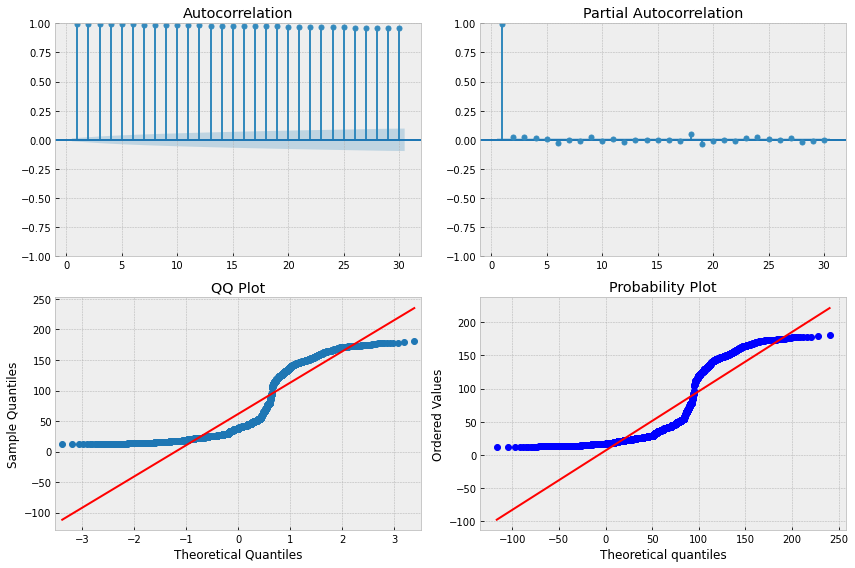

In [10]:
tsplot(tickerobjs['AAPL']['Adj Close'], lags=30)

In [11]:
print_adfuller_test(tickerobjs['AAPL']['Adj Close'])

Augmented Dickey-Fuller Test Results:
ADF Test Statistic         0.646703
P-Value                    0.988712
# Lags Used               22.000000
# Observations Used     2743.000000
Critical Value (1%)       -3.432736
Critical Value (5%)       -2.862594
Critical Value (10%)      -2.567331
dtype: float64
Series is *NOT* stationary


## Transformation Techniques
Clearly this series is Non-Stationary as can be seen from QQ, Probabilty plots and also the large p-value for ADFuller test(Null Hypothesis: series is staionary). So before one applies the ARIMA Models, it needs to be transformed to stationary using one of the following transofomations.
* **Log Transformation:** Taking the log of each data point will dampen the effect of variance over time
* **Differencing:** Taking the difference between consecutive data points usually removes the trend changes over time.
* **Log Tranformation followed by Differencing (not used here):** This technique removes both mean and variance changes over time. We will nly look at the first two as those two transformations seem to work for this dataset

To see which tranformation works best for our use case, lets plot the data and its summary statistics over time.

In [12]:
def add_log_returns(df):
    df.set_index("Date", inplace=True)
    df.loc[df.index, 'LogRets'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    df.loc[df.index[0], 'LogRets'] = 0
    df.loc[df.index,"Diff"] = df["Adj Close"].diff()
    df.loc[df.index[0], 'Diff'] = 0
    #df.loc[df.index, 'CumLogRets'] = df['LogRets'].cumsum()
    #df.loc[df.index, 'CumRets']   = np.exp(df['CumLogRets'])

In [13]:
eda_df = tickerobjs['AAPL'].copy()
add_log_returns(eda_df)
eda_df

Open        High         Low       Close   Adj Close   
Date                                                                     
2012-06-01   20.327143   20.451786   20.018572   20.035357   17.028910  \
2012-06-04   20.053572   20.267857   19.589287   20.153214   17.129076   
2012-06-05   20.045357   20.231071   19.940357   20.101070   17.084757   
2012-06-06   20.277500   20.494642   20.196428   20.409286   17.346722   
2012-06-07   20.617500   20.618570   20.375000   20.418571   17.354616   
...                ...         ...         ...         ...         ...   
2023-05-23  173.130005  173.380005  171.279999  171.559998  171.559998   
2023-05-24  171.089996  172.419998  170.520004  171.839996  171.839996   
2023-05-25  172.410004  173.899994  171.690002  172.990005  172.990005   
2023-05-26  173.320007  175.770004  173.110001  175.429993  175.429993   
2023-05-30  176.960007  178.990005  176.570007  177.300003  177.300003   

               Volume   LogRets      Diff  
Date                                       
2012-06-01  520987600  0.000000  0.000000  
2012-06-04  556995600  0.005865  0.100166  
2012-06-05  388214400 -0.002591 -0.044319  
2012-06-06  401455600  0.015217  0.261965  
2012-06-07  379766800  0.000455  0.007895  
...               ...       ...       ...  
2023-05-23   50747300 -0.015271 -2.639999  
2023-05-24   45143500  0.001631  0.279999  
2023-05-25   56058300  0.006670  1.150009  
2023-05-26   54835000  0.014006  2.439987  
2023-05-30   55964400  0.010603  1.870010  

[2766 rows x 8 columns]

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.684042e+01
P-Value                 1.139273e-29
# Lags Used             8.000000e+00
# Observations Used     2.757000e+03
Critical Value (1%)    -3.432724e+00
Critical Value (5%)    -2.862589e+00
Critical Value (10%)   -2.567328e+00
dtype: float64
Series is stationary


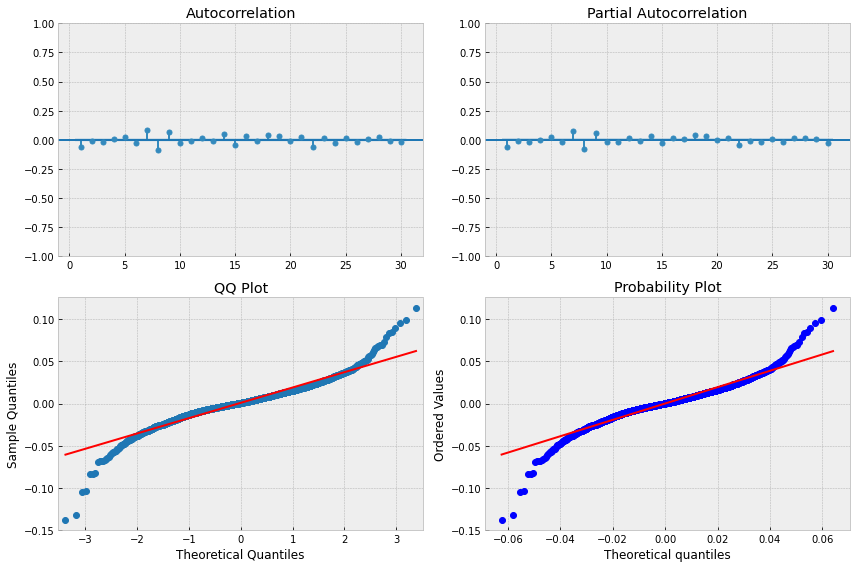

In [14]:
tsplot(eda_df['LogRets'], lags=30)
print_adfuller_test(eda_df['LogRets'])

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.090707e+01
P-Value                 1.121143e-19
# Lags Used             2.100000e+01
# Observations Used     2.744000e+03
Critical Value (1%)    -3.432735e+00
Critical Value (5%)    -2.862594e+00
Critical Value (10%)   -2.567331e+00
dtype: float64
Series is stationary


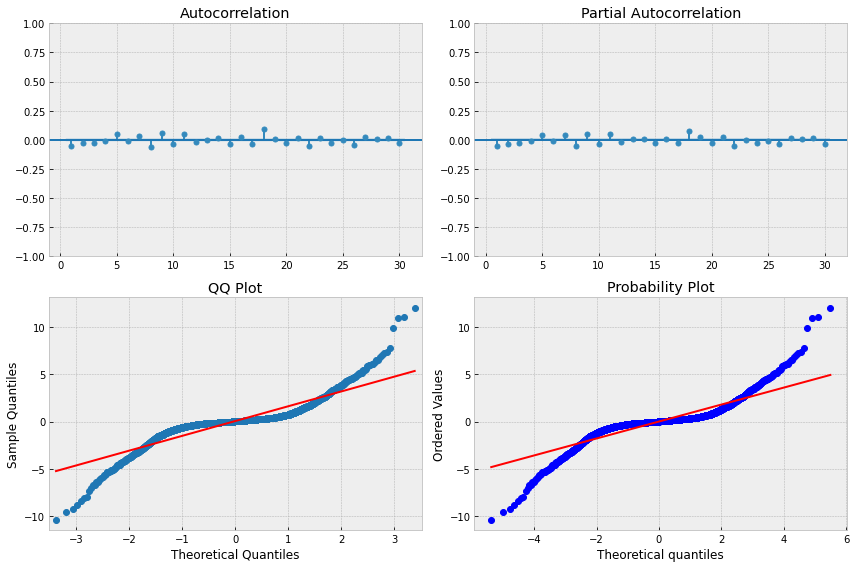

In [15]:
tsplot(eda_df['Diff'], lags=30)
print_adfuller_test(eda_df['Diff'])

* The p-values for both the Log returns and differenced returns are very very small, implying that those series are stationary. However, the qq plot looks better for log-returns. So ffor ARCH/GARCH models we need to build our models on logreturns.
* I have done the ARIMA/GARCH models on logreturns in the other notebook contained in the same directory "EDA.ipynb". Those studies need more exploration for developing a model

## Adding Financial Indicators to the Data
* We will add a few financial indicators to the data. For this we have used the python library **FINTA**(https://pypi.org/project/finta/).
    * **Moving Averages (MA)**: Moving averages smooth out price data over a specific time period, providing a clearer view of the underlying trend. Common types include the Simple Moving Average (SMA) and the **Exponential Moving Average (EMA)**. We will use EMA.
    * **Relative Strength Index (RSI)**: RSI is a momentum oscillator that measures the speed and change of price movements. It helps identify overbought and oversold conditions, indicating potential reversals or trend continuations.
    * **Moving Average Convergence Divergence (MACD)**: MACD is a trend-following momentum indicator that shows the relationship between two moving averages. It provides signals for potential buy and sell opportunities when the lines cross or diverge. 
    * **Bollinger Bands**: Bollinger Bands consist of a moving average and upper and lower bands that represent the standard deviation from the moving average. They help identify periods of high or low volatility and potential price reversals.
    * **Average True Range (ATR)**: ATR measures the volatility of a stock or market by considering the range between high and low prices over a specific period. It helps assess potential price movements and set stop-loss levels.
    * **On-balance volume (OBV)**: OBV is a technical trading momentum indicator that uses volume flow to predict changes in stock price
    * **Ichimoku Cloud**: The Ichimoku Cloud is a comprehensive indicator that provides insights into support and resistance levels, trend direction, and momentum. It consists of various lines and a cloud area.

* Another library that we will use is **FASTAI**. This provides with a functionality *add_datepart* that adds features such as *year, month, week,day, day of the week, day of the month, day of the year* and a few others. For complete documentation please see this link(https://docs.fast.ai).

In [16]:
stocks_data = {}

for i, (ticker, stocker) in enumerate(tickerobjs.items()):
    #df = stocker.make_df(date_range[0], date_range[1])
    df = stocker
    # ddd date features
    add_datepart(df, 'Date', drop=False)
    df = df.rename(columns={"Open": "open", "Close": "close", "Low": "low", "High": "high","Volume": "volume"})
    ema = TA.EMA(df)
    bb  = TA.BBANDS(df)
    rsi = TA.RSI(df)
    macd = TA.MACD(df)
    atr  = TA.ATR(df)
    ichimoku = TA.ICHIMOKU(df)
    obv      = TA.OBV(df)
    # drop unwanted columns date feature columns
    df = df.drop(['Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Elapsed'], axis=1)
    df['Is_month_end'] = df['Is_month_end'].astype(int)
    df['Is_month_start'] = df['Is_month_start'].astype(int)
    df['Exponential_moving_average'] = ema.copy()
    df = pd.concat([df, bb, rsi, macd, atr, ichimoku, obv], axis = 1)
    
    # setting index as date
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']
    # sort df by date
    df = df.sort_index(ascending=True, axis=0)
    df = df.dropna()
    print(f"Nan Values: {ticker},{df.isna().sum().sum()}")
    
    stocks_data[ticker] = df

Nan Values: AAPL,0
Nan Values: MSFT,0
Nan Values: AMZN,0
Nan Values: NVDA,0
Nan Values: GOOGL,0
Nan Values: GOOG,0
Nan Values: TSLA,0
Nan Values: META,0
Nan Values: UNH,0
Nan Values: XOM,0
Nan Values: JNJ,0
Nan Values: JPM,0
Nan Values: V,0
Nan Values: LLY,0
Nan Values: PG,0
Nan Values: AVGO,0
Nan Values: MA,0
Nan Values: HD,0
Nan Values: CVX,0
Nan Values: MRK,0
Nan Values: PEP,0
Nan Values: KO,0
Nan Values: COST,0
Nan Values: PFE,0
Nan Values: WMT,0
Nan Values: MCD,0
Nan Values: BAC,0
Nan Values: CRM,0


* Lets just make sure by looking at our AAPL stock dataframe that we have all the new added columns

In [17]:
print(type(stocks_data))
print((stocks_data["AAPL"].columns))

<class 'dict'>
Index(['Date', 'open', 'high', 'low', 'close', 'Adj Close', 'volume', 'Year',
       'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
       'Is_month_start', 'Exponential_moving_average', 'BB_UPPER', 'BB_MIDDLE',
       'BB_LOWER', '14 period RSI', 'MACD', 'SIGNAL', '14 period ATR',
       'TENKAN', 'KIJUN', 'senkou_span_a', 'SENKOU', 'CHIKOU', 'OBV'],
      dtype='object')


In [18]:
# A function to look at the distributions/trends of columns
def plot_stocks_columns(dict_df,col_name):
    plt.figure(figsize=(10, 5))
    for i, (ticker, df) in enumerate(dict_df.items()):
        plt.plot(df[col_name], linewidth=1, alpha=0.9, label=ticker)
        plt.legend()

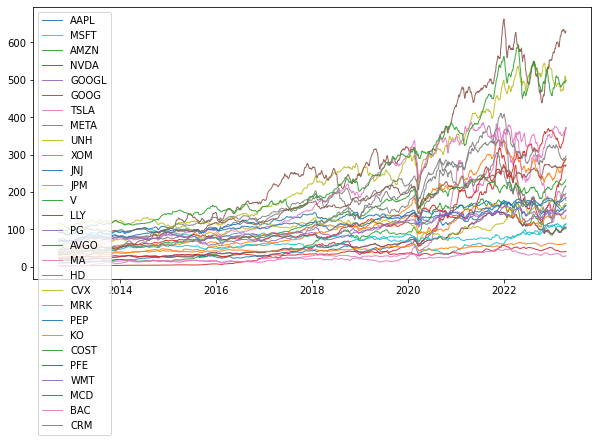

In [19]:
plot_stocks_columns(stocks_data,'Exponential_moving_average')
#plt.plot(stocks_data["AAPL"]['Exponential_moving_average'], linewidth=1, alpha=0.8, label="AAPL")

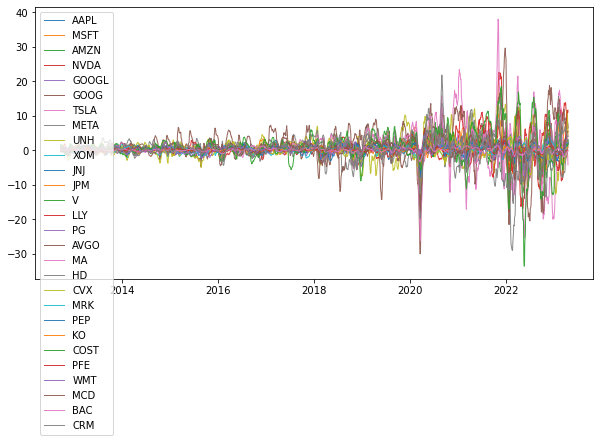

In [20]:
plot_stocks_columns(stocks_data,'MACD')

In [21]:
#plot_stocks_columns(stocks_data,'CHIKOU')

In [22]:
#plot_stocks_columns(stocks_data,'14 period RSI')

In [23]:
#plot_stocks_columns(stocks_data,'14 period ATR')

In [24]:
#plot_stocks_columns(stocks_data,'volume')

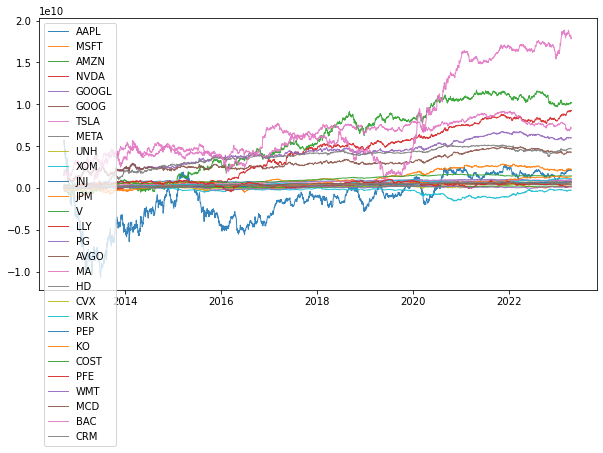

In [25]:
plot_stocks_columns(stocks_data,'OBV')

* Lets look at  the columns that are highly correlated. We will have a model built using only the columns that are not OR slightly correlated. For this again we will just focus on one stock for now and create a dropping list

In [26]:
def correlation_matrix_plot(corr_df):
    fig, ax = plt.subplots(figsize=(21,10))
    Mask = np.triu(corr_df)
    sns.heatmap(corr_df, xticklabels=corr_df.columns, yticklabels=corr_df.columns,mask=Mask,\
                annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax = ax)
    #ax.grid(True)
    plt.title('Stocks Correlation')
    ticks = np.arange(0,9,1)
    #plt.show()

In [27]:
float_df = stocks_data["AAPL"].select_dtypes(exclude = "object")
#float_df = float_df.drop(['high', 'low', 'close', 'Year', 'Week', 'Dayofyear', 'Exponential_moving_average', 'BB_UPPER'\
#                          , 'BB_MIDDLE', 'BB_LOWER', 'SIGNAL', 'TENKAN', 'KIJUN', 'senkou_span_a',\
#                         'SENKOU', 'CHIKOU'], axis=1)
float_df = float_df.drop(["Adj Close"], axis=1)
corr = float_df.corr()

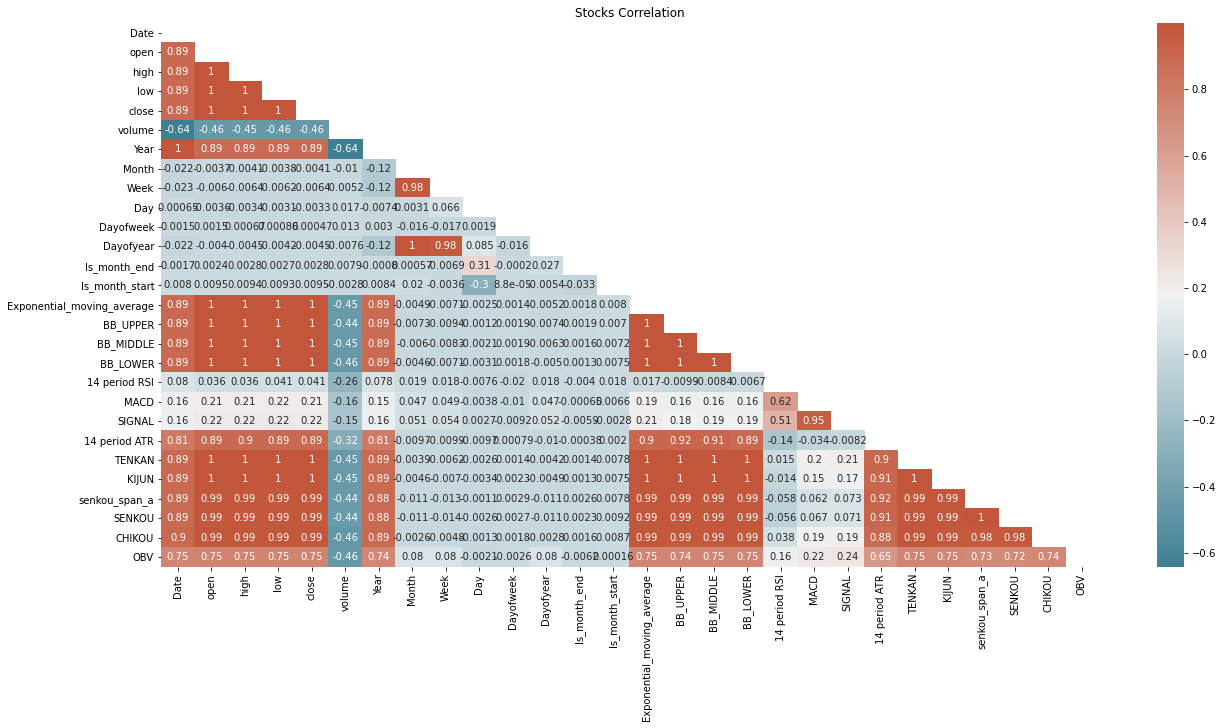

In [28]:
correlation_matrix_plot(corr)

In [29]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [30]:
#upper

In [31]:
print(to_drop)

['high', 'low', 'close', 'Year', 'Week', 'Dayofyear', 'Exponential_moving_average', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER', 'SIGNAL', 'TENKAN', 'KIJUN', 'senkou_span_a', 'SENKOU', 'CHIKOU']


In [32]:
#(float_df.corr(method ='pearson'))

* Although its not an issue on run-time at this point even including all the columns. It can however quickly evolve into a time-consuming affair once we will have all the 500 companies included. So lets look at what PCA tells us about the number of variables that can suffice. 
* One can autoatize this part and make it stocks-specific to be included in a more advanced analysis

In [33]:
from sklearn.decomposition import PCA
pca_1 = PCA(n_components=3)
pca_2 = PCA(n_components=5)
pca_3 = PCA(n_components=6)

principalComponents = pca_1.fit_transform(corr)
principalComponents = pca_2.fit_transform(corr)
principalComponents = pca_3.fit_transform(corr)

print(np.sum(pca_1.explained_variance_ratio_))
print(np.sum(pca_2.explained_variance_ratio_))
print(np.sum(pca_3.explained_variance_ratio_))

0.9619046139610852
0.9849857008660812
0.9923903479100369


* Only 6 variables can be sufficient to achieve the same efficiency as with all the variables included

In [34]:
# This is another method to look at the important columns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# define number of features to keep
k = 10
# perform feature selection
float_df = stocks_data["AAPL"].select_dtypes(exclude = "object")
X = float_df.drop(['Adj Close','Date'],  axis=1)
y = float_df["Adj Close"]
X_new = SelectKBest(f_regression, k=k).fit_transform(X, y)
# get feature names of selected features
selected_features = X.columns[SelectKBest(f_regression, k=k).fit(X, y).get_support()]
# print selected features

print(selected_features)

Index(['open', 'high', 'low', 'close', 'Exponential_moving_average',
       'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER', 'TENKAN', 'KIJUN'],
      dtype='object')


In [35]:
print(to_drop)

['high', 'low', 'close', 'Year', 'Week', 'Dayofyear', 'Exponential_moving_average', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER', 'SIGNAL', 'TENKAN', 'KIJUN', 'senkou_span_a', 'SENKOU', 'CHIKOU']


# Model Creation
### LONG SHORT-TERM MEMORY (LSTM) Model:  
(https://github.com/MohammadFneish7/Keras_LSTM_Diagram)
* We will attempt to use the Long Short-Term Memory (LSTM) model, a common deep learning recurrent neural network (RNN) used in predicting time series data. The diagram credit goes to (https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/)

<img src="./lstm_diagram.png" alt="LSTM" class="bg-primary" width="600px" height="600px">

* LSTM has logic gates (input, output and forget gates) which give inherent ability for it to retain information that is more relevant and forgo unnecessary information. This makes LSTM a good model for interpreting patterns over long periods.
* The important thing to note about LSTM is the input, which needs to be in the form of a 3D vector (samples, time-steps, features). Hence, the input has to be reshaped to fit this.

## TEST TRAIN Split:
* We will perform a train test split of 80:20, with a 10% reserved for validation data set
* **Adjusted Close** will be used as "y" i.e. the column that we want to predict.

In [36]:
(stocks_data.keys())

dict_keys(['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'GOOG', 'TSLA', 'META', 'UNH', 'XOM', 'JNJ', 'JPM', 'V', 'LLY', 'PG', 'AVGO', 'MA', 'HD', 'CVX', 'MRK', 'PEP', 'KO', 'COST', 'PFE', 'WMT', 'MCD', 'BAC', 'CRM'])

In [37]:
TRAIN_SPLIT    = 0.8  # 80% of total dataset
VAL_TEST_SPLIT = 0.5  # 50% of the remaining dataset

total_count = len(stocks_data[list(stocks_data.keys())[0]])
train_count = int(total_count * TRAIN_SPLIT)
left = total_count - train_count
valid_count = int(left * VAL_TEST_SPLIT)
test_count = int(left - valid_count)

print(sum([train_count, valid_count, test_count]))
total_count, train_count, valid_count, test_count

2658


(2658, 2126, 266, 266)

* To make sure that all the stocks included here have similar number of entries

In [38]:
for i, (ticker, df) in enumerate(stocks_data.items()):
    print(i, ticker, len(df))

0 AAPL 2658
1 MSFT 2641
2 AMZN 2662
3 NVDA 2647
4 GOOGL 2661
5 GOOG 2663
6 TSLA 2660
7 META 2655
8 UNH 2654
9 XOM 2655
10 JNJ 2647
11 JPM 2649
12 V 2652
13 LLY 2651
14 PG 2645
15 AVGO 2658
16 MA 2659
17 HD 2657
18 CVX 2652
19 MRK 2640
20 PEP 2648
21 KO 2632
22 COST 2653
23 PFE 2627
24 WMT 2653
25 MCD 2650
26 BAC 2616
27 CRM 2654


In [39]:
#x_columns = [
#    'Open', 'High', 'Low', 'Volume', 'Month', 'Week', 'Day', 'Dayofweek', 
#    'Dayofyear', 'Is_month_end', 'Is_month_start']
#pick_columns = ['Open', 'High', 'Low', 'Volume', 'Month', 'Week', 'Day', 'Dayofweek', 
#    'Dayofyear', 'Is_month_end', 'Is_month_start','Adj Close']

In [40]:
y_column = ['Adj Close']
cols_to_delete = ['Adj Close','Date','close']

In [41]:
type(stocks_data)

dict

* The cell below creates a train-test-validation split on all the stocks dataframes based on the %age we have defined above. We created a list of dictionaries for each stock with items as dataframes corresponding to train, test, validation sets

In [42]:
for i, (ticker, df) in enumerate(stocks_data.items()):
    x_df = df.drop(columns=['Adj Close','Date'], axis=1)
    x_df = df.drop(cols_to_delete,axis=1)
    y_df = df[y_column]
    stocks_data[ticker] = {
        'x': x_df, 'y': y_df,
        'x_train': x_df[0:train_count], 'y_train': y_df[0:train_count],
        'x_valid': x_df[train_count:train_count+valid_count], 'y_valid': y_df[train_count:train_count+valid_count],
        'x_test': x_df[train_count+valid_count:], 'y_test': y_df[train_count+valid_count:],
    }

* Lets check to make sure that all the intended changes are there

In [43]:
stocks_data['AAPL']

{'x':                   open        high         low     volume  Year  Month  Week   
 Date                                                                           
 2012-09-20   24.969999   25.002144   24.772142  336568400  2012      9    38  \
 2012-09-21   25.086071   25.181070   24.977142  571589200  2012      9    38   
 2012-09-24   24.530714   24.825714   24.392857  639766400  2012      9    39   
 2012-09-25   24.580713   24.742144   24.035713  518789600  2012      9    39   
 2012-09-26   23.883572   24.024643   23.614286  576503200  2012      9    39   
 ...                ...         ...         ...        ...   ...    ...   ...   
 2023-04-17  165.089996  165.389999  164.029999   41516200  2023      4    16   
 2023-04-18  166.100006  167.410004  165.649994   49923000  2023      4    16   
 2023-04-19  165.800003  168.160004  165.539993   47720200  2023      4    16   
 2023-04-20  166.089996  167.869995  165.559998   52456400  2023      4    16   
 2023-04-21  165.050003

### Create Time Series Generators
* **Keras** provides the **TimeseriesGenerator** that can be used to automatically transform a univariate or multivariate time series dataset into a **supervised learning problem**.

* There are two parts to using the TimeseriesGenerator: **defining it** and **using it** to train models.
* In addition to specifying the input and output aspects of your time series problem, there are some additional parameters that you should configure; for example:
    * **length**: The number of lag observations to use in the input portion of each sample (e.g. 3).
    * **batch_size**: The number of samples to return on each iteration (e.g. 32).
    
We must define a length argument based on designed framing of the problem. That is the desired number of lag observations to use as input.
we must also define the batch size as the batch size of our model during training. If the number of samples in teh dataset is less than batch size, one can set the batch size in the generator and in the model to the total number of samples in generator found via calculating its length.

In [44]:
#Import all the needed libs
from numpy import hstack
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import TensorBoard, ModelCheckpoint
from time import time

## Normalization of the Data
* Below we will normalize the data using MinMaxScalar. We will perform the scaling on the whole dataset and then transform train dataset and test dataset to scaled values 

In [45]:
for i, (ticker, ds) in enumerate(stocks_data.items()):
    x_series = []
    y_series = []
    x_train_series = []
    y_train_series = []
    x_valid_series = []
    y_valid_series = []
    x_test_series = []
    y_test_series = []
    
    ds['x_values'] = ds['x'].values
    ds['y_values'] = ds['y'].values
    
    ds['x_train_values'] = ds['x_train'].values
    ds['y_train_values'] = ds['y_train'].values
    
    ds['x_valid_values'] = ds['x_valid'].values
    ds['y_valid_values'] = ds['y_valid'].values
    
    ds['x_test_values'] = ds['x_test'].values
    ds['y_test_values'] = ds['y_test'].values
    
    # Append values
    x_series.append(ds['x_values'])
    y_series.append(ds['y_values'])
    
    x_train_series.append(ds['x_train_values'])
    y_train_series.append(ds['y_train_values'])
    
    x_valid_series.append(ds['x_valid_values'])
    y_valid_series.append(ds['y_valid_values'])
    
    x_test_series.append(ds['x_test_values'])
    y_test_series.append(ds['y_test_values'])
    

    x_dataset = hstack(tuple(x_series))
    y_dataset = hstack(tuple(y_series))

    x_train_dataset = hstack(tuple(x_train_series))
    y_train_dataset = hstack(tuple(y_train_series))

    x_valid_dataset = hstack(tuple(x_valid_series))
    y_valid_dataset = hstack(tuple(y_valid_series))

    x_test_dataset = hstack(tuple(x_test_series))
    y_test_dataset = hstack(tuple(y_test_series))

    # fit scalers on full series
    x_scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaler = MinMaxScaler(feature_range=(0, 1))

    x_dataset = x_scaler.fit_transform(x_dataset)
    y_dataset = y_scaler.fit_transform(y_dataset)
    
    # Scale train and validation datasets
    x_train_dataset = x_scaler.transform(x_train_dataset)
    y_train_dataset = y_scaler.transform(y_train_dataset)

    x_valid_dataset = x_scaler.transform(x_valid_dataset)
    y_valid_dataset = y_scaler.transform(y_valid_dataset)

    x_test_dataset = x_scaler.transform(x_test_dataset)
    y_test_dataset = y_scaler.transform(y_test_dataset)
    
    ds['x_train_dataset'] = x_train_dataset
    ds['y_train_dataset'] = y_train_dataset
    
    ds['x_valid_dataset'] = x_valid_dataset
    ds['y_valid_dataset'] = y_valid_dataset
    
    ds['x_test_dataset'] = x_test_dataset
    ds['y_test_dataset'] = y_test_dataset
    
    # Store feature scalers
    ds['x_scaler'] = x_scaler
    ds['y_scaler'] = y_scaler
    
    print('*' * 5 + 'Train shapes for ' + ticker)
    print(x_train_dataset.shape, y_train_dataset.shape) 
    
    print('*' * 5 + 'Validation shapes for ' + ticker)
    print(x_valid_dataset.shape, y_valid_dataset.shape) 
    
    print('*' * 5 + 'Test shapes for ' + ticker)
    print(x_test_dataset.shape, y_test_dataset.shape) 

*****Train shapes for AAPL
(2126, 26) (2126, 1)
*****Validation shapes for AAPL
(266, 26) (266, 1)
*****Test shapes for AAPL
(266, 26) (266, 1)
*****Train shapes for MSFT
(2126, 26) (2126, 1)
*****Validation shapes for MSFT
(266, 26) (266, 1)
*****Test shapes for MSFT
(249, 26) (249, 1)
*****Train shapes for AMZN
(2126, 26) (2126, 1)
*****Validation shapes for AMZN
(266, 26) (266, 1)
*****Test shapes for AMZN
(270, 26) (270, 1)
*****Train shapes for NVDA
(2126, 26) (2126, 1)
*****Validation shapes for NVDA
(266, 26) (266, 1)
*****Test shapes for NVDA
(255, 26) (255, 1)
*****Train shapes for GOOGL
(2126, 26) (2126, 1)
*****Validation shapes for GOOGL
(266, 26) (266, 1)
*****Test shapes for GOOGL
(269, 26) (269, 1)
*****Train shapes for GOOG
(2126, 26) (2126, 1)
*****Validation shapes for GOOG
(266, 26) (266, 1)
*****Test shapes for GOOG
(271, 26) (271, 1)
*****Train shapes for TSLA
(2126, 26) (2126, 1)
*****Validation shapes for TSLA
(266, 26) (266, 1)
*****Test shapes for TSLA
(268, 26

In [46]:
stocks_data['AAPL'].keys()

dict_keys(['x', 'y', 'x_train', 'y_train', 'x_valid', 'y_valid', 'x_test', 'y_test', 'x_values', 'y_values', 'x_train_values', 'y_train_values', 'x_valid_values', 'y_valid_values', 'x_test_values', 'y_test_values', 'x_train_dataset', 'y_train_dataset', 'x_valid_dataset', 'y_valid_dataset', 'x_test_dataset', 'y_test_dataset', 'x_scaler', 'y_scaler'])

In [47]:
pd.DataFrame(stocks_data['AAPL']['x_train_dataset'])
#(stocks_data['AAPL']['y_scaler'])

0         1         2         3         4         5         6    
0     0.065851  0.063620  0.066631  0.211392  0.000000  0.727273  0.711538  \
1     0.066539  0.064681  0.067871  0.376243  0.000000  0.727273  0.711538   
2     0.063248  0.062574  0.064338  0.424065  0.000000  0.727273  0.730769   
3     0.063544  0.062079  0.062178  0.339208  0.000000  0.727273  0.730769   
4     0.059414  0.057825  0.059629  0.379690  0.000000  0.727273  0.730769   
...        ...       ...       ...       ...       ...       ...       ...   
2121  0.639281  0.648186  0.634146  0.100276  0.818182  0.181818  0.153846   
2122  0.634718  0.638344  0.627796  0.083169  0.818182  0.181818  0.153846   
2123  0.634422  0.632771  0.619572  0.083597  0.818182  0.181818  0.173077   
2124  0.623165  0.639055  0.635174  0.066166  0.818182  0.181818  0.173077   
2125  0.638925  0.639708  0.639165  0.053833  0.818182  0.181818  0.173077   

            7     8         9   ...        16        17        18        19   
0     0.633333  0.75  0.719780  ...  0.682238  0.510367  0.498959  0.024267  \
1     0.666667  1.00  0.722527  ...  0.689939  0.510193  0.499543  0.022369   
2     0.766667  0.00  0.730769  ...  0.582241  0.507739  0.499463  0.024827   
3     0.800000  0.25  0.733516  ...  0.424599  0.501933  0.498102  0.029794   
4     0.833333  0.50  0.736264  ...  0.362724  0.495349  0.495545  0.031425   
...        ...   ...       ...  ...       ...       ...       ...       ...   
2121  0.100000  0.75  0.167582  ...  0.196461  0.260146  0.302724  0.600764   
2122  0.133333  1.00  0.170330  ...  0.238554  0.252715  0.285090  0.627764   
2123  0.233333  0.00  0.178571  ...  0.152546  0.220917  0.263886  0.649001   
2124  0.266667  0.25  0.181319  ...  0.288418  0.225449  0.247935  0.670131   
2125  0.300000  0.50  0.184066  ...  0.268509  0.225549  0.235196  0.662554   

            20        21        22        23        24        25  
0     0.059592  0.056436  0.044022  0.039631  0.045364  0.965167  
1     0.059710  0.056862  0.044650  0.039631  0.043519  1.000000  
2     0.059710  0.057787  0.044856  0.040773  0.043778  0.961013  
3     0.061557  0.058822  0.046024  0.042719  0.039583  0.929398  
4     0.060275  0.058822  0.047910  0.044702  0.041245  0.894266  
...        ...       ...       ...       ...       ...       ...  
2121  0.666850  0.726718  0.749462  0.739906  0.697910  0.725102  
2122  0.661311  0.716966  0.749462  0.739906  0.716891  0.734473  
2123  0.657172  0.699923  0.749462  0.739906  0.702611  0.725065  
2124  0.657172  0.699923  0.754024  0.739906  0.717308  0.732958  
2125  0.657172  0.699923  0.756530  0.739906  0.715285  0.726137  

[2126 rows x 26 columns]

* Here we will use the KERAS TimeSeriesGenerator to create train, test and validation sample. We are using a window length of 90 days for these samples

In [48]:
window_length = 90
BATCH_SIZE = int(window_length / 5)

for i, (ticker, ds) in enumerate(stocks_data.items()):
    x_train_dataset = ds['x_train_dataset']
    y_train_dataset = ds['y_train_dataset']
    
    x_valid_dataset = ds['x_valid_dataset']
    y_valid_dataset = ds['y_valid_dataset']
    
    x_test_dataset = ds['x_test_dataset']
    y_test_dataset = ds['y_test_dataset']
    
    train_generator = TimeseriesGenerator(x_train_dataset, y_train_dataset, length=window_length, batch_size=BATCH_SIZE)
    print('Train samples for {}: {}'.format(ticker, len(train_generator)))

    valid_generator = TimeseriesGenerator(x_valid_dataset, y_valid_dataset, length=window_length, batch_size=BATCH_SIZE)
    print('Validation samples for {}: {}'.format(ticker, len(valid_generator)))

    test_generator = TimeseriesGenerator(x_test_dataset, y_test_dataset, length=window_length, batch_size=BATCH_SIZE)
    print('Test samples for {}: {}'.format(ticker, len(test_generator)))
    
    ds['train_generator'] = train_generator
    ds['valid_generator'] = valid_generator
    ds['test_generator'] = test_generator

Train samples for AAPL: 114
Validation samples for AAPL: 10
Test samples for AAPL: 10
Train samples for MSFT: 114
Validation samples for MSFT: 10
Test samples for MSFT: 9
Train samples for AMZN: 114
Validation samples for AMZN: 10
Test samples for AMZN: 10
Train samples for NVDA: 114
Validation samples for NVDA: 10
Test samples for NVDA: 10
Train samples for GOOGL: 114
Validation samples for GOOGL: 10
Test samples for GOOGL: 10
Train samples for GOOG: 114
Validation samples for GOOG: 10
Test samples for GOOG: 11
Train samples for TSLA: 114
Validation samples for TSLA: 10
Test samples for TSLA: 10
Train samples for META: 114
Validation samples for META: 10
Test samples for META: 10
Train samples for UNH: 114
Validation samples for UNH: 10
Test samples for UNH: 10
Train samples for XOM: 114
Validation samples for XOM: 10
Test samples for XOM: 10
Train samples for JNJ: 114
Validation samples for JNJ: 10
Test samples for JNJ: 10
Train samples for JPM: 114
Validation samples for JPM: 10
Tes

## Fit Stacked LSTM Model on Generator Data
* We chose 50 input layers, have added dropout and one additional layer with 50 units.
* We am also choosing an EarlyStopping parameter with *validation loss* as monitor parameter and a patiemce of 10.
* We will have to study the affect of other parameters like hyperparamter optimization such as learning rate and different optimizers.
* To check the model performnce, we will use **MAPE**, which is mean absolute percentage error.
* We will set the EPOCHS to 100.
* Also used is **TensorBoard**, which is a visualization tool provided with TensorFlow. This callback logs events for TensorBoard, including: Metrics summary plots, Training graph visualization, Weight histograms (https://keras.io/api/callbacks/tensorboard/#:~:text=TensorBoard%20is%20a%20visualization%20tool,Weight%20histograms).
* We will perform model fitting on all the 30 stocks that we started with.

In [49]:
#print(stocks_data['AAPL'].columns)

In [50]:
EPOCHS = 100
early_stopping = [EarlyStopping(monitor='val_loss', patience=10)]

for i, (ticker, ds) in enumerate(stocks_data.items()):
    train_generator = ds['train_generator']
    valid_generator = ds['valid_generator']
    test_generator = ds['test_generator']
    
    OUTPUT_SIZE = 1
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(window_length, OUTPUT_SIZE * 26)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(OUTPUT_SIZE))
    
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mean_absolute_percentage_error'])
    #model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mean_absolute_error'])
    
    # Tensorboard
    tensorboard = TensorBoard(log_dir='logs/{}-{}'.format(ticker, time()))
    
    # Checkpoint
    filepath='models/{}.weights.best.hdf5'.format(ticker)
    #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [tensorboard,early_stopping]
    
    print('*' * 5 + 'Training for {}'.format(ticker))
    model.fit_generator(
        train_generator, 
        validation_data=valid_generator, 
        shuffle=False,
        epochs=EPOCHS, 
        verbose=1, 
        callbacks=callbacks_list
    )
    model.save(filepath)
    
    
    
    # --Plots while training
    val_loss = model.evaluate_generator(valid_generator)
    print('Val loss for {}: {}'.format(ticker, val_loss))
    
    # Make test predictions
    test_predict = model.predict_generator(test_generator)
    predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
    predicted_df = predicted_df.rename(columns={0: ticker})
    
    original_test = stocks_data[ticker]['y_test'].iloc[window_length:]
    predicted_df.index = original_test.index
    
    predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)
    
    #%matplotlib inline
    #plt.figure(figsize=(12, 8))

    #plt.plot(predicted_ticker[ticker], linewidth=1, alpha=0.8)
    #plt.plot(stocks_data[ticker]['y'], linewidth=1, alpha=0.8)
    #plt.title('Plot for {}, val loss: {}'.format(ticker.upper(), val_loss))
    #plt.savefig('plots/{}'.format(ticker))
    #plt.show()
    #plot_model_performance(model,train_generator,test_generator,"accuracy", "val_accuracy")

*****Training for AAPL
Epoch 1/100
114/114 [==============================] - 6s 29ms/step - loss: 0.0036 - mean_absolute_percentage_error: 77467.9766 - val_loss: 0.0470 - val_mean_absolute_percentage_error: 23.7060
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0044 - mean_absolute_percentage_error: 68036.1797 - val_loss: 0.0412 - val_mean_absolute_percentage_error: 21.9138
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0028 - mean_absolute_percentage_error: 56038.4727 - val_loss: 0.0332 - val_mean_absolute_percentage_error: 19.1724
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0027 - mean_absolute_percentage_error: 74777.9531 - val_loss: 0.0591 - val_mean_absolute_percentage_error: 26.6315
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0018 - mean_absolute_percentage_error: 19154.1641 - val_loss: 0.0653 - val_mean_absolute_percentage_error: 27.9690
Epoch 6/100


Epoch 24/100
114/114 [==============================] - 3s 25ms/step - loss: 6.9554e-04 - mean_absolute_percentage_error: 39.4099 - val_loss: 0.0029 - val_mean_absolute_percentage_error: 4.7336
Epoch 25/100
114/114 [==============================] - 3s 25ms/step - loss: 8.4201e-04 - mean_absolute_percentage_error: 62.0910 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 5.9286
Epoch 26/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0011 - mean_absolute_percentage_error: 66.3901 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 7.2333
Val loss for MSFT: [0.006579188629984856, 7.2332763671875]
*****Training for AMZN
Epoch 1/100
114/114 [==============================] - 6s 35ms/step - loss: 0.0056 - mean_absolute_percentage_error: 76.3310 - val_loss: 0.0297 - val_mean_absolute_percentage_error: 17.5944
Epoch 2/100
114/114 [==============================] - 3s 28ms/step - loss: 0.0086 - mean_absolute_percentage_error: 138.6842 - val_loss: 0.0173 - val

Epoch 41/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0013 - mean_absolute_percentage_error: 46.6747 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.6316
Epoch 42/100
114/114 [==============================] - 3s 25ms/step - loss: 8.7652e-04 - mean_absolute_percentage_error: 26.5258 - val_loss: 0.0017 - val_mean_absolute_percentage_error: 3.7040
Epoch 43/100
114/114 [==============================] - 3s 25ms/step - loss: 8.5567e-04 - mean_absolute_percentage_error: 24.8050 - val_loss: 0.0014 - val_mean_absolute_percentage_error: 3.4031
Epoch 44/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0010 - mean_absolute_percentage_error: 26.0325 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 6.1553
Epoch 45/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0012 - mean_absolute_percentage_error: 40.5105 - val_loss: 0.0019 - val_mean_absolute_percentage_error: 3.9074
Epoch 46/100
114/114 [====================

Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0013 - mean_absolute_percentage_error: 24.3244 - val_loss: 0.0125 - val_mean_absolute_percentage_error: 11.2910
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0015 - mean_absolute_percentage_error: 22.2467 - val_loss: 0.0012 - val_mean_absolute_percentage_error: 3.0687
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0012 - mean_absolute_percentage_error: 23.1933 - val_loss: 0.0080 - val_mean_absolute_percentage_error: 8.8388
Epoch 6/100
114/114 [==============================] - 3s 25ms/step - loss: 8.6770e-04 - mean_absolute_percentage_error: 12.8329 - val_loss: 0.0026 - val_mean_absolute_percentage_error: 4.6051
Epoch 7/100
114/114 [==============================] - 3s 25ms/step - loss: 9.9243e-04 - mean_absolute_percentage_error: 15.2572 - val_loss: 0.0022 - val_mean_absolute_percentage_error: 4.1371
Epoch 8/100
114/114 [=========================

Epoch 8/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0036 - mean_absolute_percentage_error: 415.5876 - val_loss: 0.0124 - val_mean_absolute_percentage_error: 14.6605
Epoch 9/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0018 - mean_absolute_percentage_error: 121.8626 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 21.0731
Epoch 10/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0046 - mean_absolute_percentage_error: 280.6341 - val_loss: 0.0106 - val_mean_absolute_percentage_error: 12.6760
Epoch 11/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0041 - mean_absolute_percentage_error: 510.6664 - val_loss: 0.0080 - val_mean_absolute_percentage_error: 7.7741
Epoch 12/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0011 - mean_absolute_percentage_error: 55.8079 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 9.2723
Epoch 13/100
114/114 [=======================

114/114 [==============================] - 3s 25ms/step - loss: 9.0997e-04 - mean_absolute_percentage_error: 38.5581 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 15.1631
Epoch 17/100
114/114 [==============================] - 3s 25ms/step - loss: 6.5984e-04 - mean_absolute_percentage_error: 20.7723 - val_loss: 0.0109 - val_mean_absolute_percentage_error: 10.4847
Epoch 18/100
114/114 [==============================] - 3s 25ms/step - loss: 6.8169e-04 - mean_absolute_percentage_error: 18.1893 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 15.0980
Epoch 19/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0010 - mean_absolute_percentage_error: 36.1167 - val_loss: 0.0132 - val_mean_absolute_percentage_error: 11.7627
Val loss for UNH: [0.013232707977294922, 11.762728691101074]
*****Training for XOM
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0115 - mean_absolute_percentage_error: 93452.3438 - val_loss: 0.0630 - val_m

Epoch 39/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0019 - mean_absolute_percentage_error: 19888.4570 - val_loss: 0.0163 - val_mean_absolute_percentage_error: 26.2484
Epoch 40/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0018 - mean_absolute_percentage_error: 25969.8516 - val_loss: 0.0162 - val_mean_absolute_percentage_error: 27.4192
Epoch 41/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0017 - mean_absolute_percentage_error: 33685.8320 - val_loss: 0.0136 - val_mean_absolute_percentage_error: 24.3492
Epoch 42/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0016 - mean_absolute_percentage_error: 25223.3594 - val_loss: 0.0102 - val_mean_absolute_percentage_error: 19.1071
Epoch 43/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0018 - mean_absolute_percentage_error: 10931.2773 - val_loss: 0.0101 - val_mean_absolute_percentage_error: 17.8433
Epoch 44/100
114/114 [========

114/114 [==============================] - 3s 25ms/step - loss: 0.0017 - mean_absolute_percentage_error: 12.8157 - val_loss: 0.0014 - val_mean_absolute_percentage_error: 3.4994
Epoch 13/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0016 - mean_absolute_percentage_error: 11.8315 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 5.6565
Epoch 14/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0023 - mean_absolute_percentage_error: 14.9016 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 5.6762
Epoch 15/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0025 - mean_absolute_percentage_error: 18.1643 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 4.0340
Epoch 16/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0017 - mean_absolute_percentage_error: 14.7147 - val_loss: 0.0023 - val_mean_absolute_percentage_error: 4.5258
Epoch 17/100
114/114 [==============================] - 3s 25ms

Epoch 20/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0011 - mean_absolute_percentage_error: 9.7608 - val_loss: 0.0017 - val_mean_absolute_percentage_error: 3.8754
Epoch 21/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0014 - mean_absolute_percentage_error: 12.4774 - val_loss: 0.0022 - val_mean_absolute_percentage_error: 4.5045
Epoch 22/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0011 - mean_absolute_percentage_error: 9.4327 - val_loss: 0.0021 - val_mean_absolute_percentage_error: 4.4283
Epoch 23/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0011 - mean_absolute_percentage_error: 14.9941 - val_loss: 0.0016 - val_mean_absolute_percentage_error: 3.7694
Epoch 24/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0016 - mean_absolute_percentage_error: 21.7745 - val_loss: 0.0017 - val_mean_absolute_percentage_error: 3.8916
Epoch 25/100
114/114 [==============================

114/114 [==============================] - 3s 25ms/step - loss: 2.9035e-04 - mean_absolute_percentage_error: 16.9731 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 26.0790
Epoch 25/100
114/114 [==============================] - 3s 25ms/step - loss: 2.4168e-04 - mean_absolute_percentage_error: 14.6998 - val_loss: 0.0251 - val_mean_absolute_percentage_error: 24.6784
Epoch 26/100
114/114 [==============================] - 3s 26ms/step - loss: 2.4633e-04 - mean_absolute_percentage_error: 15.2946 - val_loss: 0.0157 - val_mean_absolute_percentage_error: 19.0407
Epoch 27/100
114/114 [==============================] - 3s 26ms/step - loss: 3.6228e-04 - mean_absolute_percentage_error: 26.2070 - val_loss: 0.0242 - val_mean_absolute_percentage_error: 24.2043
Epoch 28/100
114/114 [==============================] - 3s 25ms/step - loss: 2.7601e-04 - mean_absolute_percentage_error: 15.2146 - val_loss: 0.0291 - val_mean_absolute_percentage_error: 26.7595
Val loss for LLY: [0.02907717227935791

114/114 [==============================] - 3s 25ms/step - loss: 0.0016 - mean_absolute_percentage_error: 81.2371 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 7.1334
Epoch 9/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0010 - mean_absolute_percentage_error: 96.1666 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 7.0977
Epoch 10/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0010 - mean_absolute_percentage_error: 33.7019 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 6.2915
Epoch 11/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0017 - mean_absolute_percentage_error: 120.3112 - val_loss: 0.0022 - val_mean_absolute_percentage_error: 4.8031
Epoch 12/100
114/114 [==============================] - 3s 25ms/step - loss: 8.8109e-04 - mean_absolute_percentage_error: 58.2620 - val_loss: 0.0024 - val_mean_absolute_percentage_error: 4.5506
Epoch 13/100
114/114 [==============================] - 3s 

Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0041 - mean_absolute_percentage_error: 53.1688 - val_loss: 0.0253 - val_mean_absolute_percentage_error: 16.3060
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0037 - mean_absolute_percentage_error: 54.4648 - val_loss: 0.0335 - val_mean_absolute_percentage_error: 19.4478
Epoch 6/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0018 - mean_absolute_percentage_error: 36.1715 - val_loss: 0.0321 - val_mean_absolute_percentage_error: 19.0448
Epoch 7/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0013 - mean_absolute_percentage_error: 20.3515 - val_loss: 0.0340 - val_mean_absolute_percentage_error: 19.8705
Epoch 8/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0013 - mean_absolute_percentage_error: 22.4265 - val_loss: 0.0394 - val_mean_absolute_percentage_error: 21.7925
Epoch 9/100
114/114 [=============================

Epoch 10/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0012 - mean_absolute_percentage_error: 19.2386 - val_loss: 0.0025 - val_mean_absolute_percentage_error: 7.2137
Epoch 11/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0012 - mean_absolute_percentage_error: 16.4083 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 9.9510
Epoch 12/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0011 - mean_absolute_percentage_error: 17.9005 - val_loss: 0.0024 - val_mean_absolute_percentage_error: 7.0660
Epoch 13/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0011 - mean_absolute_percentage_error: 15.6623 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 8.0927
Epoch 14/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0010 - mean_absolute_percentage_error: 14.7553 - val_loss: 0.0020 - val_mean_absolute_percentage_error: 6.5428
Epoch 15/100
114/114 [============================

114/114 [==============================] - 3s 25ms/step - loss: 8.2591e-04 - mean_absolute_percentage_error: 19.3023 - val_loss: 0.0012 - val_mean_absolute_percentage_error: 5.1793
Epoch 53/100
114/114 [==============================] - 3s 25ms/step - loss: 6.8465e-04 - mean_absolute_percentage_error: 23.7146 - val_loss: 0.0027 - val_mean_absolute_percentage_error: 7.7743
Epoch 54/100
114/114 [==============================] - 3s 25ms/step - loss: 5.3798e-04 - mean_absolute_percentage_error: 10.7095 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 6.0175
Epoch 55/100
114/114 [==============================] - 3s 25ms/step - loss: 5.7742e-04 - mean_absolute_percentage_error: 20.2561 - val_loss: 0.0022 - val_mean_absolute_percentage_error: 6.9686
Epoch 56/100
114/114 [==============================] - 3s 25ms/step - loss: 6.0272e-04 - mean_absolute_percentage_error: 12.8634 - val_loss: 0.0014 - val_mean_absolute_percentage_error: 5.3762
Epoch 57/100
114/114 [=====================

Epoch 9/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0020 - mean_absolute_percentage_error: 17.0469 - val_loss: 0.0114 - val_mean_absolute_percentage_error: 12.2898
Epoch 10/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0016 - mean_absolute_percentage_error: 14.7969 - val_loss: 0.0085 - val_mean_absolute_percentage_error: 9.6942
Epoch 11/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0015 - mean_absolute_percentage_error: 15.1949 - val_loss: 0.0021 - val_mean_absolute_percentage_error: 4.4551
Epoch 12/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0015 - mean_absolute_percentage_error: 15.2937 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 5.3867
Epoch 13/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0012 - mean_absolute_percentage_error: 12.8044 - val_loss: 0.0019 - val_mean_absolute_percentage_error: 4.2052
Epoch 14/100
114/114 [============================

114/114 [==============================] - 3s 25ms/step - loss: 6.4099e-04 - mean_absolute_percentage_error: 14.3670 - val_loss: 0.0416 - val_mean_absolute_percentage_error: 23.0750
Epoch 17/100
114/114 [==============================] - 3s 25ms/step - loss: 7.0881e-04 - mean_absolute_percentage_error: 24.3769 - val_loss: 0.0421 - val_mean_absolute_percentage_error: 22.9855
Epoch 18/100
114/114 [==============================] - 3s 25ms/step - loss: 5.1697e-04 - mean_absolute_percentage_error: 11.2658 - val_loss: 0.0451 - val_mean_absolute_percentage_error: 24.0161
Epoch 19/100
114/114 [==============================] - 3s 25ms/step - loss: 4.8791e-04 - mean_absolute_percentage_error: 13.1621 - val_loss: 0.0364 - val_mean_absolute_percentage_error: 20.8300
Epoch 20/100
114/114 [==============================] - 3s 25ms/step - loss: 5.6021e-04 - mean_absolute_percentage_error: 12.2224 - val_loss: 0.0409 - val_mean_absolute_percentage_error: 22.5684
Epoch 21/100
114/114 [================

114/114 [==============================] - 3s 25ms/step - loss: 4.2126e-04 - mean_absolute_percentage_error: 12.9406 - val_loss: 0.0206 - val_mean_absolute_percentage_error: 15.8018
Val loss for COST: [0.020625092089176178, 15.801782608032227]
*****Training for PFE
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0052 - mean_absolute_percentage_error: 30.8755 - val_loss: 0.0656 - val_mean_absolute_percentage_error: 31.0284
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0047 - mean_absolute_percentage_error: 31.1444 - val_loss: 0.0499 - val_mean_absolute_percentage_error: 25.9874
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0040 - mean_absolute_percentage_error: 29.9383 - val_loss: 0.0554 - val_mean_absolute_percentage_error: 27.6395
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0034 - mean_absolute_percentage_error: 27.3355 - val_loss: 0.0500 - val_mean_absolute_

Epoch 22/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0012 - mean_absolute_percentage_error: 16076.5137 - val_loss: 0.0014 - val_mean_absolute_percentage_error: 3.5871
Epoch 23/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0013 - mean_absolute_percentage_error: 23549.0137 - val_loss: 0.0014 - val_mean_absolute_percentage_error: 3.5363
Epoch 24/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0012 - mean_absolute_percentage_error: 3909.4937 - val_loss: 9.6392e-04 - val_mean_absolute_percentage_error: 2.9345
Epoch 25/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0014 - mean_absolute_percentage_error: 44148.8984 - val_loss: 0.0015 - val_mean_absolute_percentage_error: 3.6974
Epoch 26/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0022 - mean_absolute_percentage_error: 32047.4688 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 5.9706
Epoch 27/100
114/114 [==========

114/114 [==============================] - 3s 25ms/step - loss: 0.0012 - mean_absolute_percentage_error: 11.8562 - val_loss: 0.0077 - val_mean_absolute_percentage_error: 9.9559
Epoch 18/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0014 - mean_absolute_percentage_error: 13.0414 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 7.8661
Epoch 19/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0014 - mean_absolute_percentage_error: 15.9968 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 9.5730
Epoch 20/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0012 - mean_absolute_percentage_error: 13.7231 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 9.0686
Epoch 21/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0013 - mean_absolute_percentage_error: 14.8959 - val_loss: 0.0100 - val_mean_absolute_percentage_error: 11.8380
Epoch 22/100
114/114 [==============================] - 3s 25m

114/114 [==============================] - 5s 29ms/step - loss: 0.0053 - mean_absolute_percentage_error: 46.0078 - val_loss: 0.0521 - val_mean_absolute_percentage_error: 25.4526
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0091 - mean_absolute_percentage_error: 77.5558 - val_loss: 0.0158 - val_mean_absolute_percentage_error: 12.4287
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0078 - mean_absolute_percentage_error: 72.2953 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 12.5336
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0091 - mean_absolute_percentage_error: 83.9481 - val_loss: 0.0108 - val_mean_absolute_percentage_error: 11.7678
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0064 - mean_absolute_percentage_error: 64.9171 - val_loss: 0.0111 - val_mean_absolute_percentage_error: 12.2085
Epoch 6/100
114/114 [==============================] - 3s 25ms

In [51]:
#model.history.history()
predicted_ticker

CRM   Adj Close
Date                              
2022-08-16  243.807114  189.589996
2022-08-17  244.893509  187.960007
2022-08-18  244.536697  187.929993
2022-08-19  243.044312  183.770004
2022-08-22  239.830734  176.979996
...                ...         ...
2023-04-17  244.283066  197.080002
2023-04-18  245.906891  198.500000
2023-04-19  247.697464  198.919998
2023-04-20  248.399841  197.509995
2023-04-21  247.726974  199.029999

[172 rows x 2 columns]

In [52]:
len(stocks_data)

28

# Generating Final Data Frame for the Predicted Data
* We will now generate the predicted stocks distribution using the best models fit above 

Val loss for AAPL: 0.018755709752440453


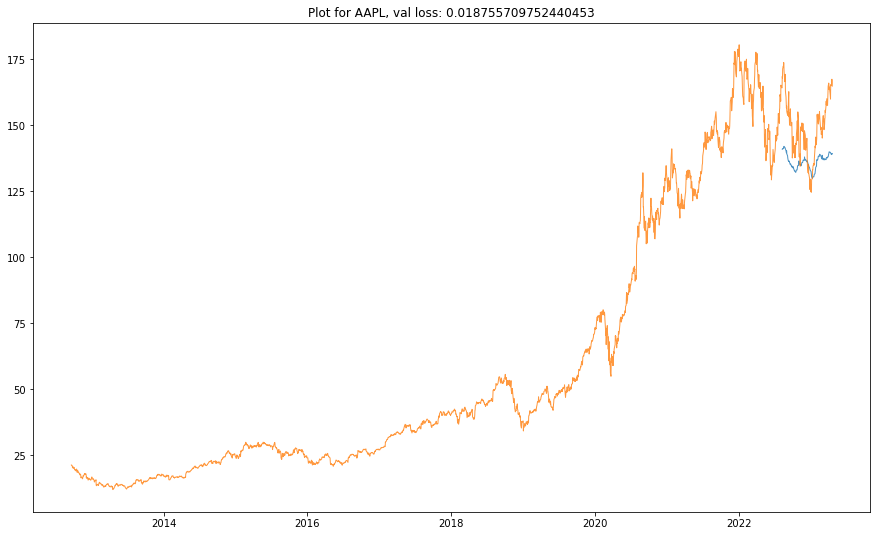

--------------------------
Final Train Loss: 0.0141
Final Test Loss: 0.0088
--------------------------
Final Train MAPE: 364.0033874511719
Final Test MAPE: 9.358200073242188
Val loss for MSFT: 0.006579188629984856


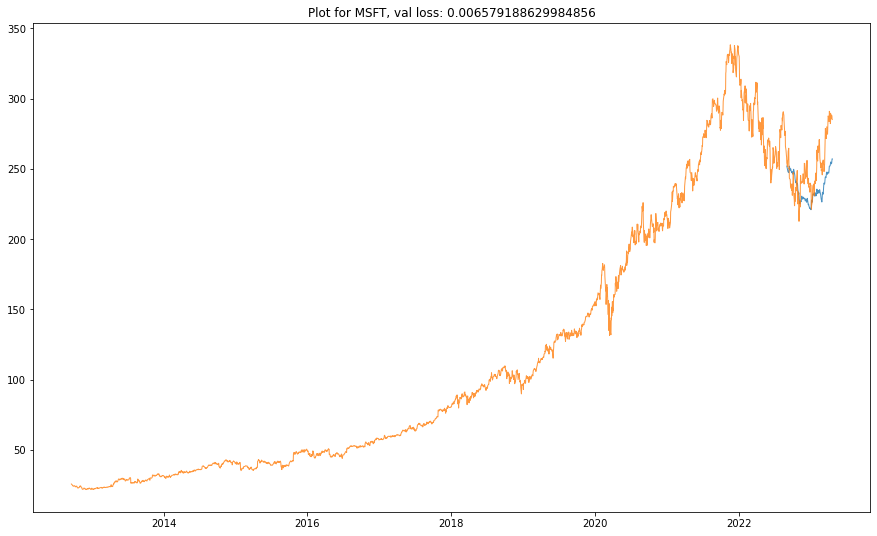

--------------------------
Final Train Loss: 0.0035
Final Test Loss: 0.004
--------------------------
Final Train MAPE: 324.0845947265625
Final Test MAPE: 7.121799945831299
Val loss for AMZN: 0.002437398536130786


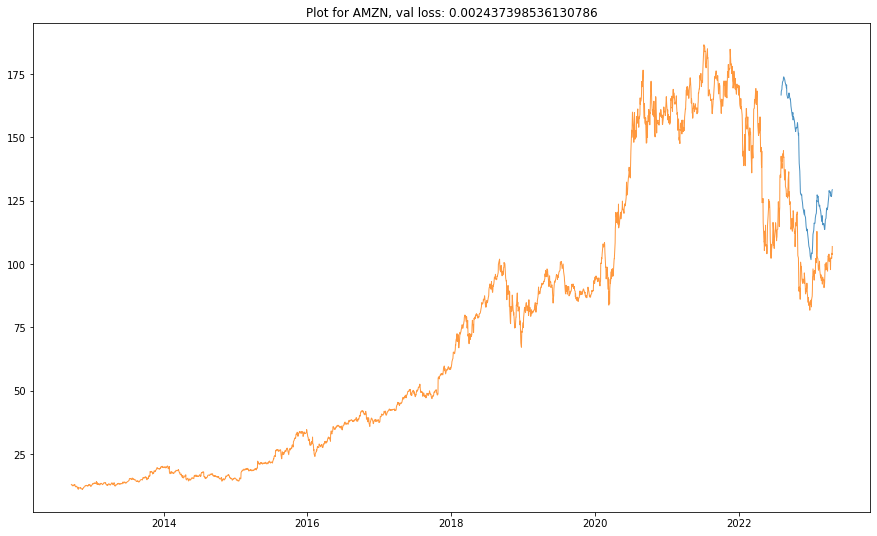

--------------------------
Final Train Loss: 0.0044
Final Test Loss: 0.0314
--------------------------
Final Train MAPE: 319.3966064453125
Final Test MAPE: 33.68479919433594
Val loss for NVDA: 0.06949380040168762


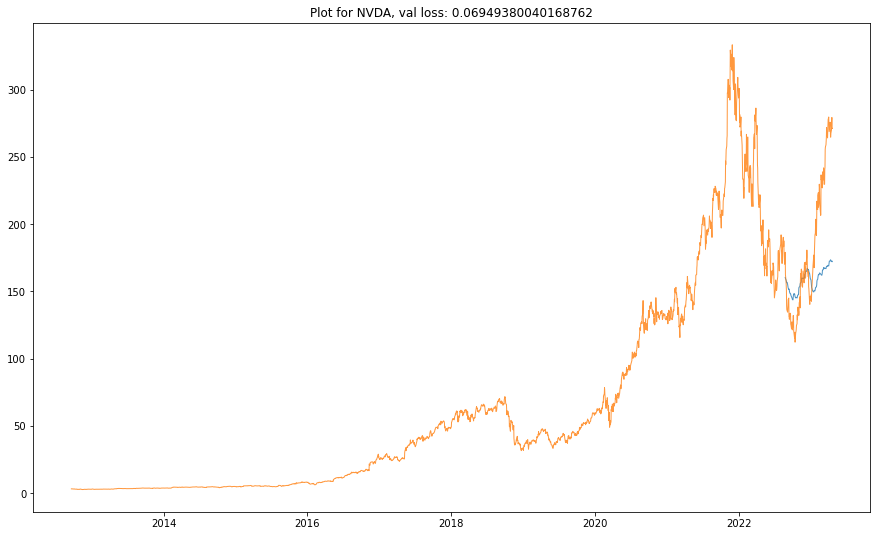

--------------------------
Final Train Loss: 0.0017
Final Test Loss: 0.0229
--------------------------
Final Train MAPE: 1545.339599609375
Final Test MAPE: 21.579599380493164
Val loss for GOOGL: 0.021317314356565475


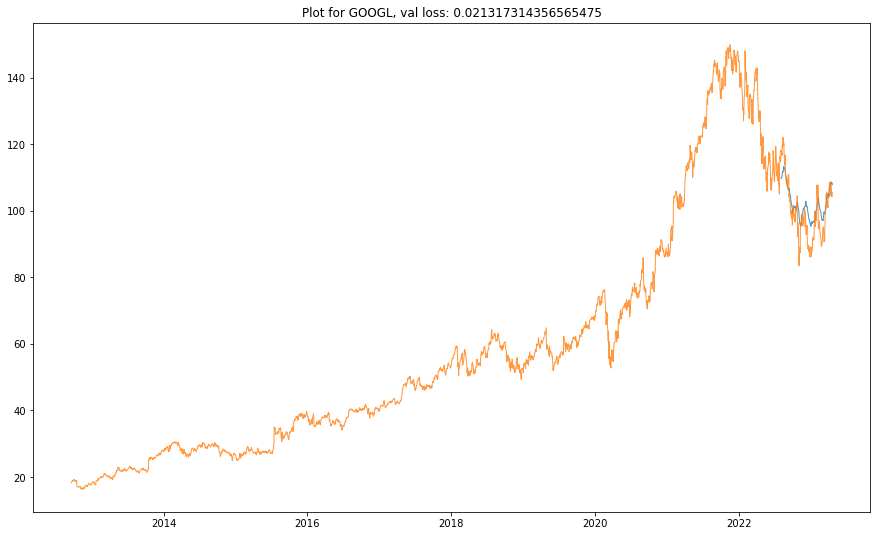

--------------------------
Final Train Loss: 0.0085
Final Test Loss: 0.0017
--------------------------
Final Train MAPE: 162.09410095214844
Final Test MAPE: 8.273200035095215
Val loss for GOOG: 0.011272846721112728


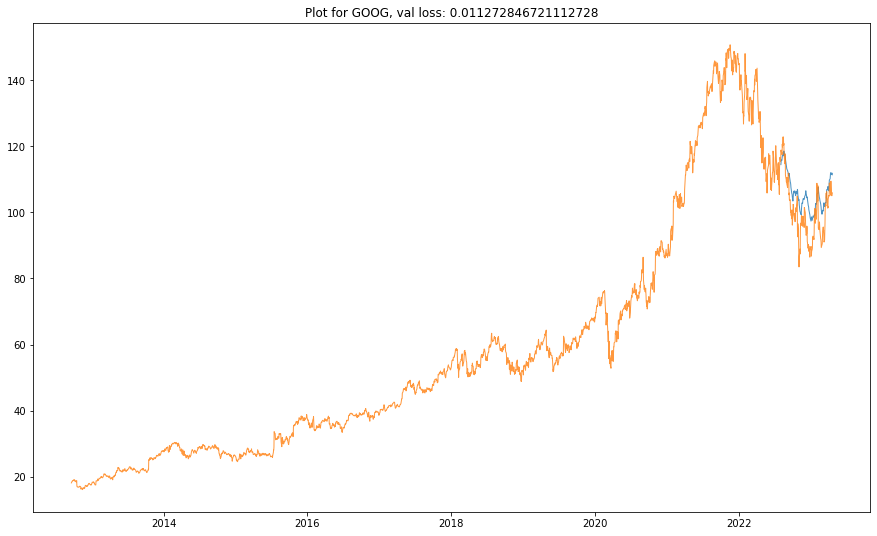

--------------------------
Final Train Loss: 0.004
Final Test Loss: 0.003
--------------------------
Final Train MAPE: 175.56900024414062
Final Test MAPE: 9.906299591064453
Val loss for TSLA: 0.004176241345703602


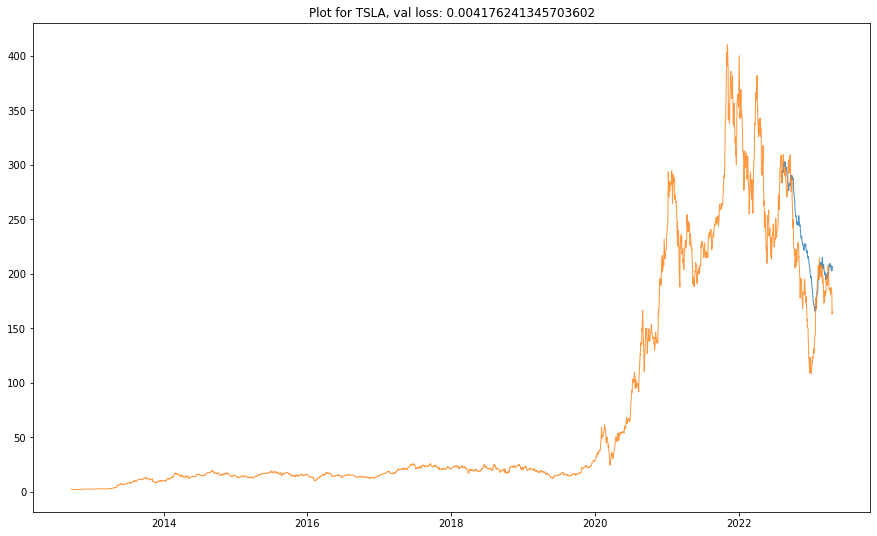

--------------------------
Final Train Loss: 0.0094
Final Test Loss: 0.0084
--------------------------
Final Train MAPE: 1467.8043212890625
Final Test MAPE: 32.22090148925781
Val loss for META: 0.01902913860976696


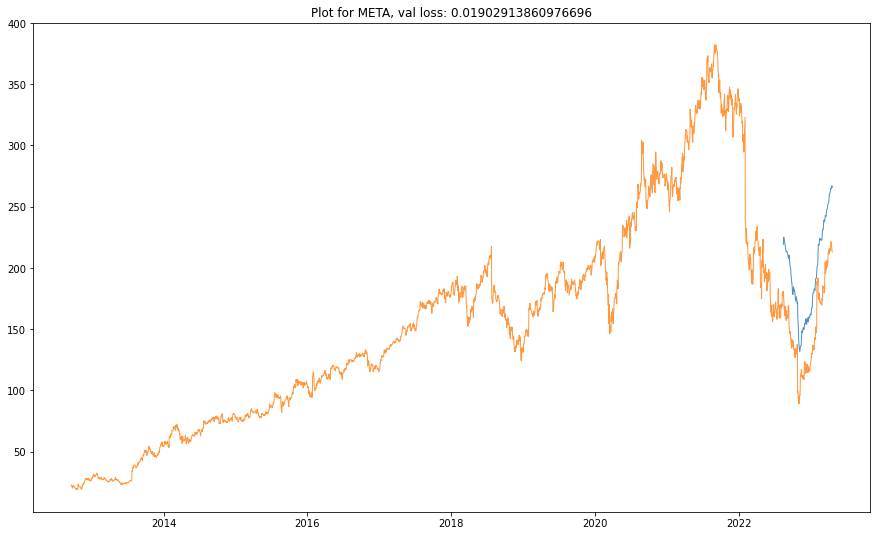

--------------------------
Final Train Loss: 0.009
Final Test Loss: 0.0156
--------------------------
Final Train MAPE: 115.80809783935547
Final Test MAPE: 41.99129867553711
Val loss for UNH: 0.013232707977294922


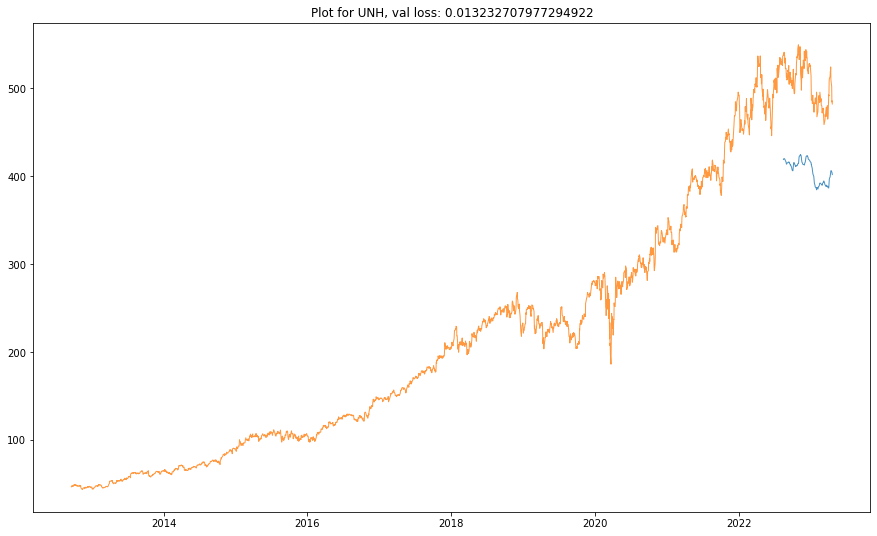

--------------------------
Final Train Loss: 0.0035
Final Test Loss: 0.0392
--------------------------
Final Train MAPE: 234.03399658203125
Final Test MAPE: 19.43429946899414
Val loss for XOM: 0.013828233815729618


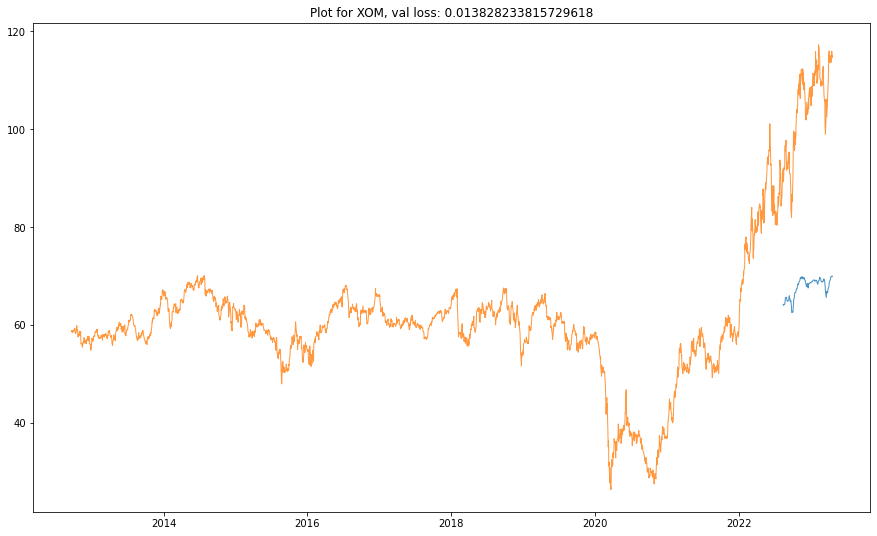

--------------------------
Final Train Loss: 0.0019
Final Test Loss: 0.1707
--------------------------
Final Train MAPE: 21.773300170898438
Final Test MAPE: 34.89899826049805
Val loss for JNJ: 0.0009414380183443427


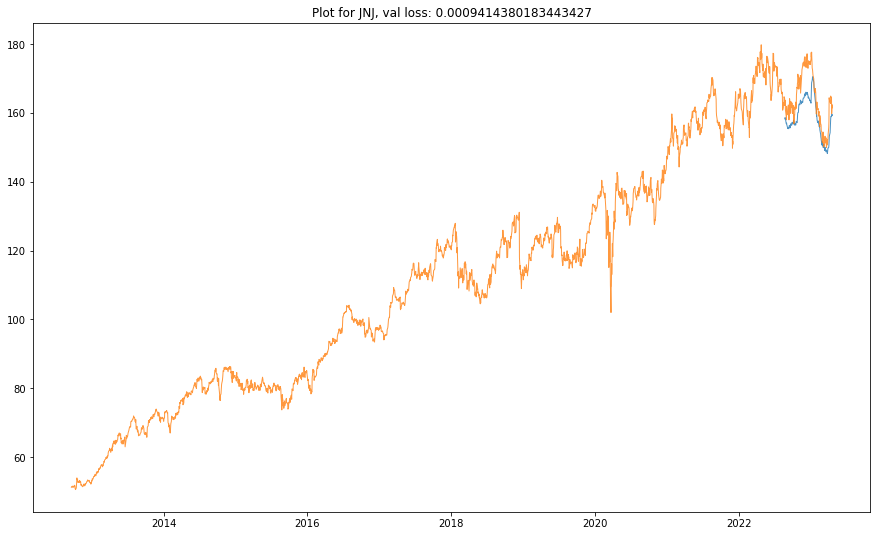

--------------------------
Final Train Loss: 0.0018
Final Test Loss: 0.0024
--------------------------
Final Train MAPE: 64.68250274658203
Final Test MAPE: 5.246799945831299
Val loss for JPM: 0.0011603920720517635


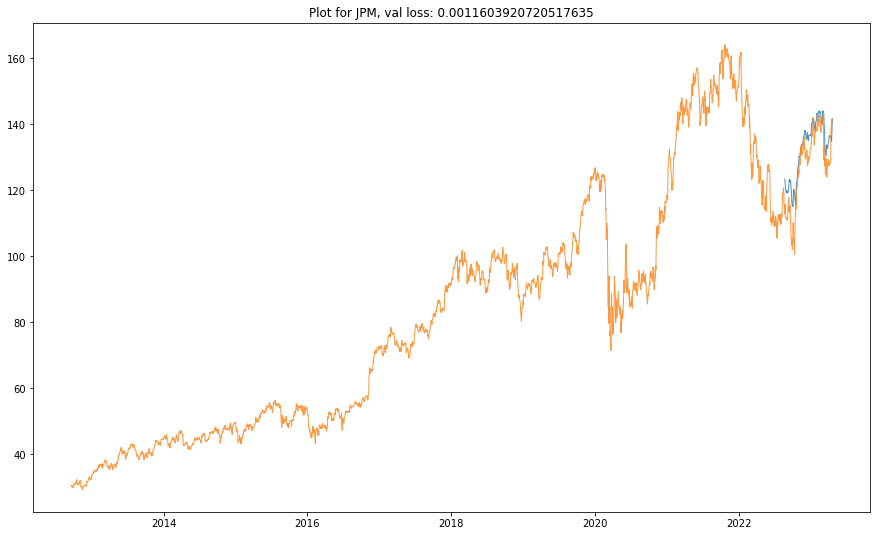

--------------------------
Final Train Loss: 0.0022
Final Test Loss: 0.0024
--------------------------
Final Train MAPE: 110.17430114746094
Final Test MAPE: 9.928600311279297
Val loss for V: 0.003387417644262314


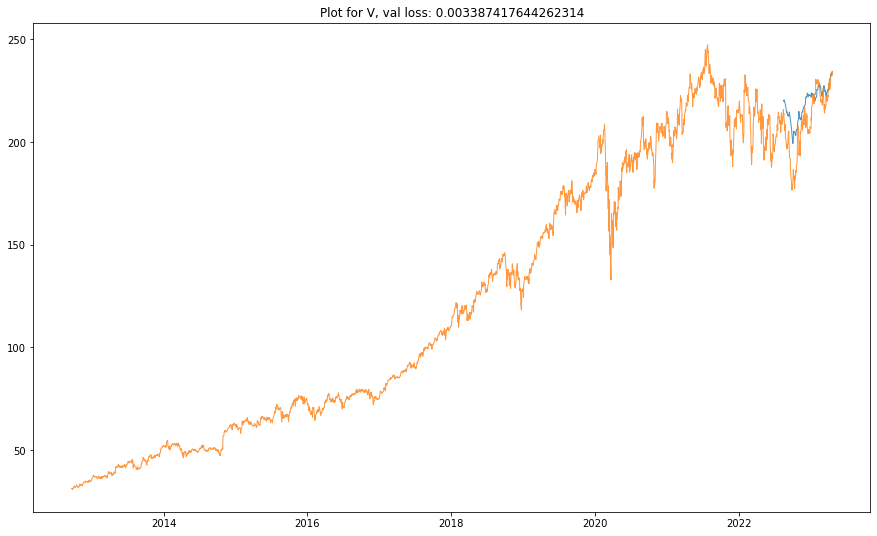

--------------------------
Final Train Loss: 0.0019
Final Test Loss: 0.0032
--------------------------
Final Train MAPE: 171.0478973388672
Final Test MAPE: 7.59089994430542
Val loss for LLY: 0.02907717227935791


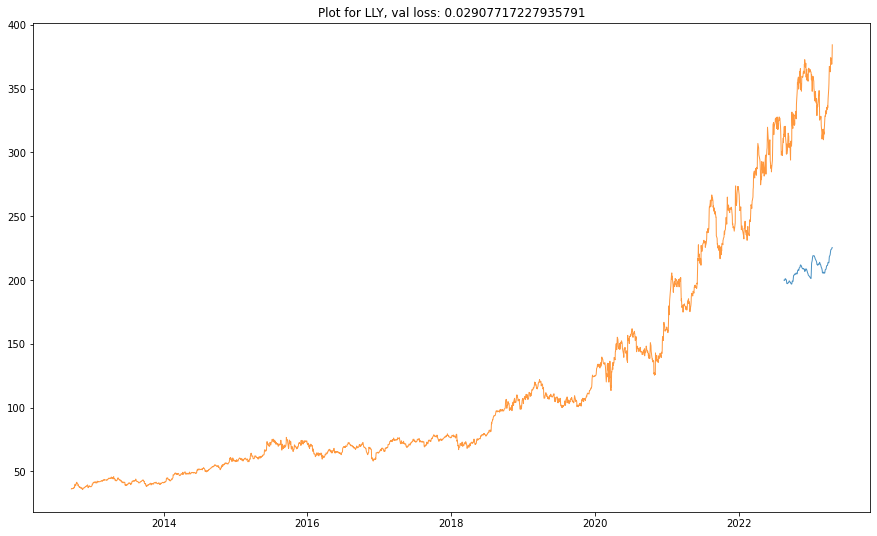

--------------------------
Final Train Loss: 0.002
Final Test Loss: 0.1455
--------------------------
Final Train MAPE: 193.94219970703125
Final Test MAPE: 38.50320053100586
Val loss for PG: 0.002582307206466794


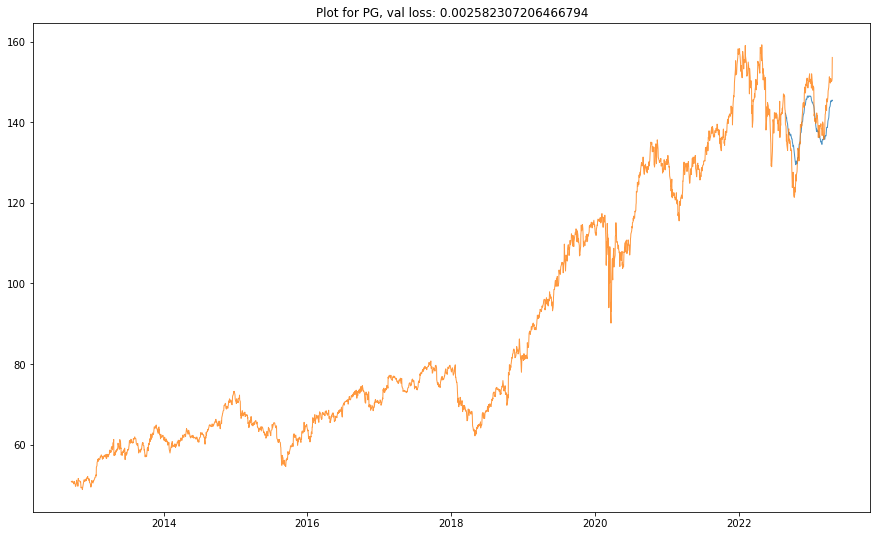

--------------------------
Final Train Loss: 0.001
Final Test Loss: 0.0017
--------------------------
Final Train MAPE: 85.87519836425781
Final Test MAPE: 5.543700218200684
Val loss for AVGO: 0.0063486602157354355


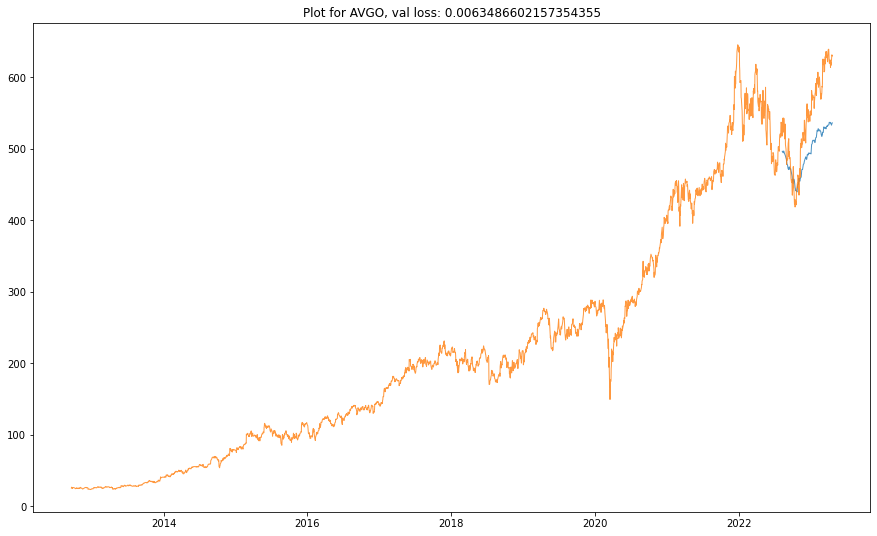

--------------------------
Final Train Loss: 0.0012
Final Test Loss: 0.0086
--------------------------
Final Train MAPE: 424.9880065917969
Final Test MAPE: 12.306099891662598
Val loss for MA: 0.0016674858052283525


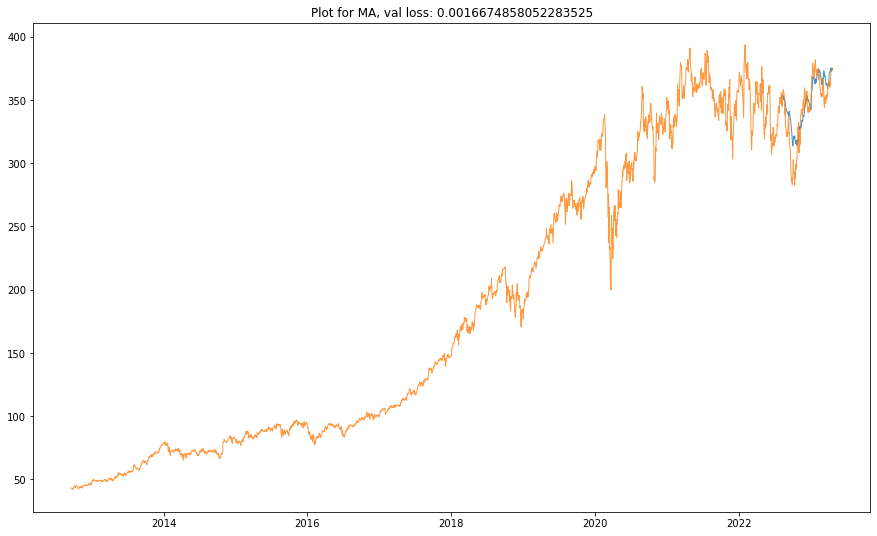

--------------------------
Final Train Loss: 0.0023
Final Test Loss: 0.0017
--------------------------
Final Train MAPE: 216.8188934326172
Final Test MAPE: 7.767099857330322
Val loss for HD: 0.03710341826081276


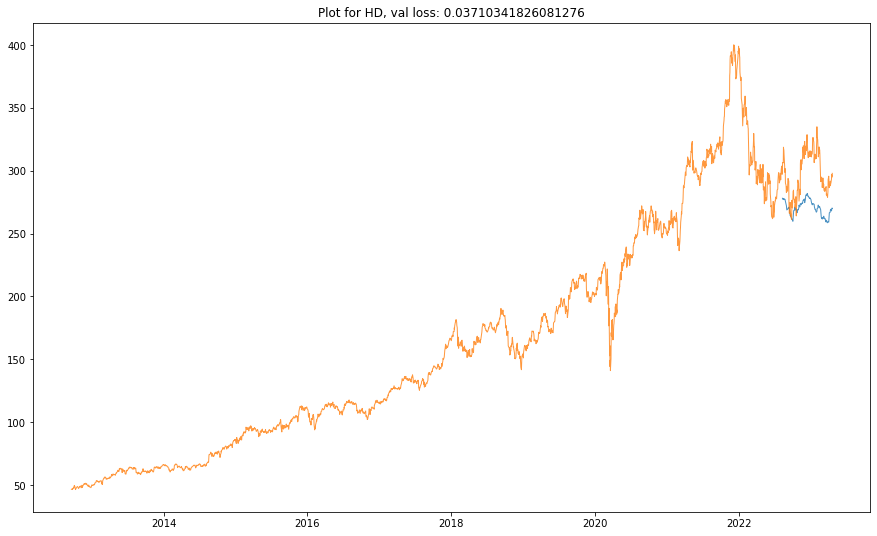

--------------------------
Final Train Loss: 0.0135
Final Test Loss: 0.0076
--------------------------
Final Train MAPE: 144.47779846191406
Final Test MAPE: 9.128999710083008
Val loss for CVX: 0.047098852694034576


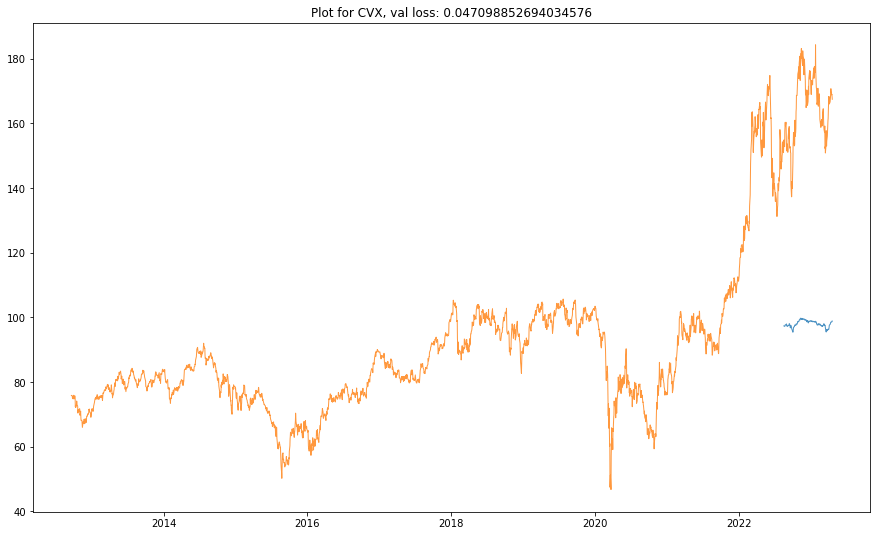

--------------------------
Final Train Loss: 0.0057
Final Test Loss: 0.2423
--------------------------
Final Train MAPE: 21.35460090637207
Final Test MAPE: 40.40079879760742
Val loss for MRK: 0.0024471732322126627


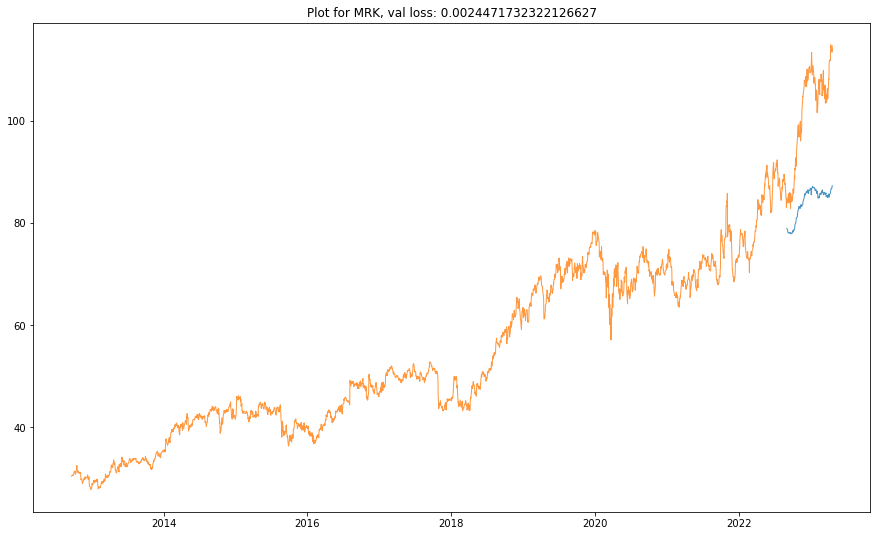

--------------------------
Final Train Loss: 0.0008
Final Test Loss: 0.0483
--------------------------
Final Train MAPE: 76.1707992553711
Final Test MAPE: 17.2716007232666
Val loss for PEP: 0.02314388006925583


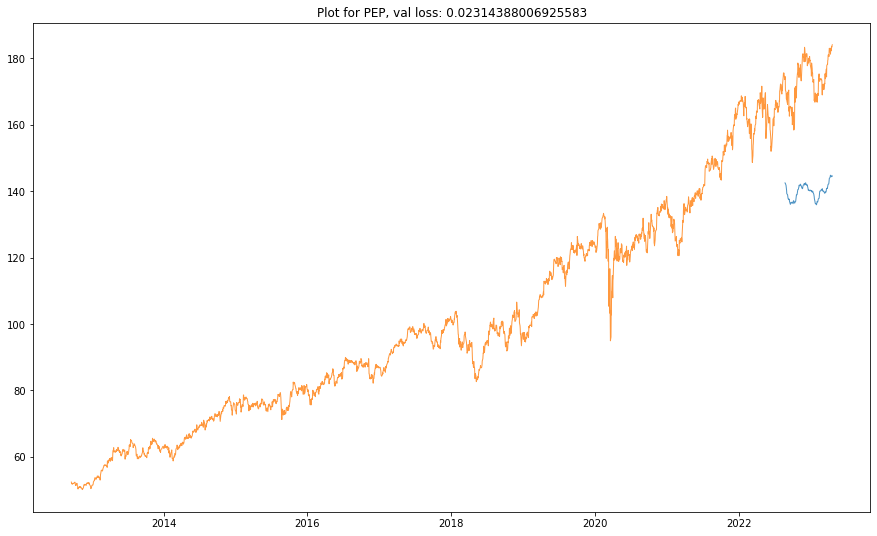

--------------------------
Final Train Loss: 0.0042
Final Test Loss: 0.0644
--------------------------
Final Train MAPE: 61.89569854736328
Final Test MAPE: 19.324499130249023
Val loss for KO: 0.0012284517288208008


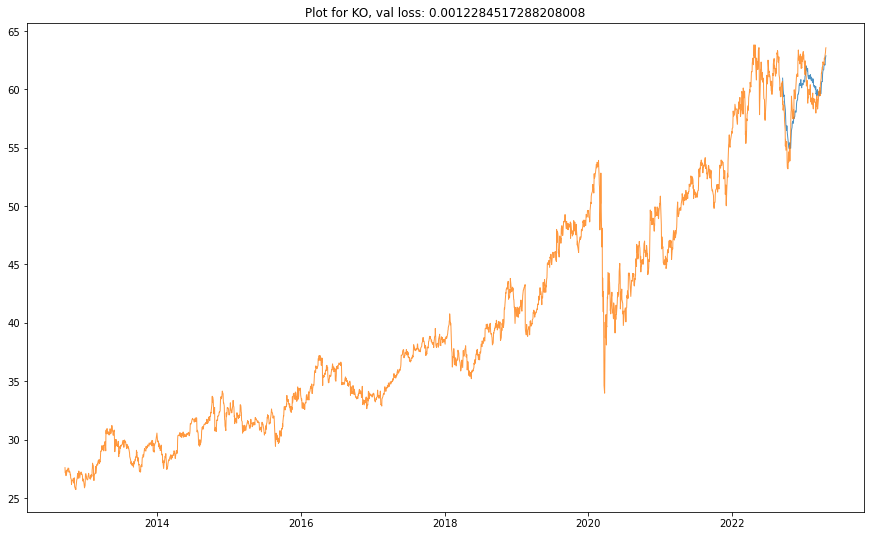

--------------------------
Final Train Loss: 0.0051
Final Test Loss: 0.0018
--------------------------
Final Train MAPE: 65.64250183105469
Final Test MAPE: 4.378499984741211
Val loss for COST: 0.020625092089176178


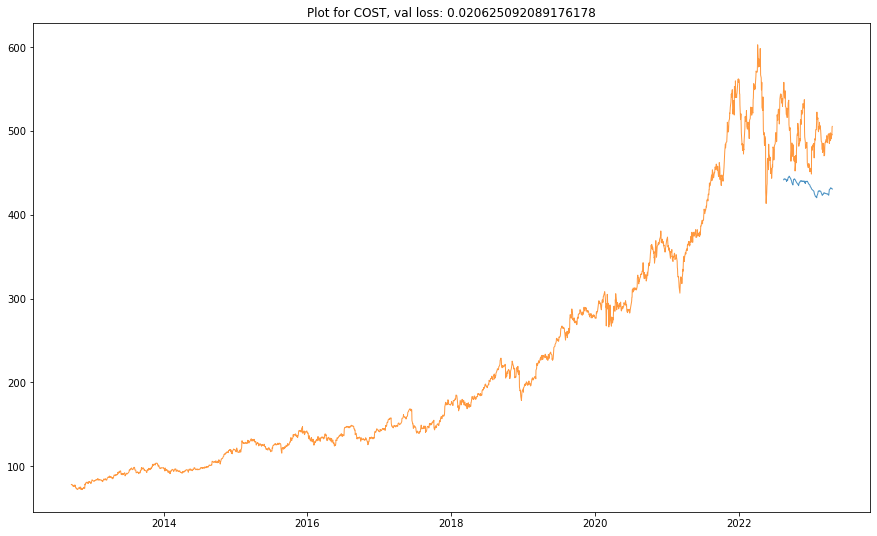

--------------------------
Final Train Loss: 0.0002
Final Test Loss: 0.0143
--------------------------
Final Train MAPE: 191.81959533691406
Final Test MAPE: 11.833600044250488
Val loss for PFE: 0.03839615359902382


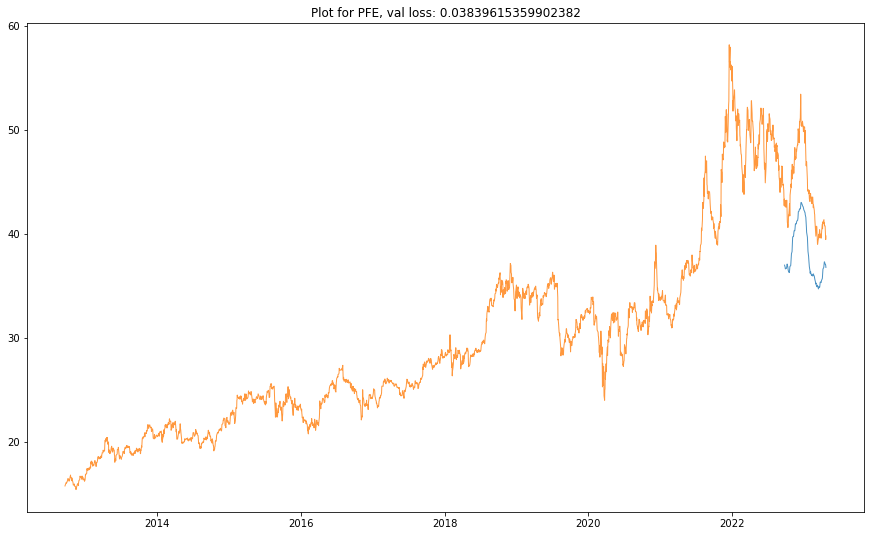

--------------------------
Final Train Loss: 0.0034
Final Test Loss: 0.0218
--------------------------
Final Train MAPE: 49.616600036621094
Final Test MAPE: 14.034199714660645
Val loss for WMT: 0.007005983963608742


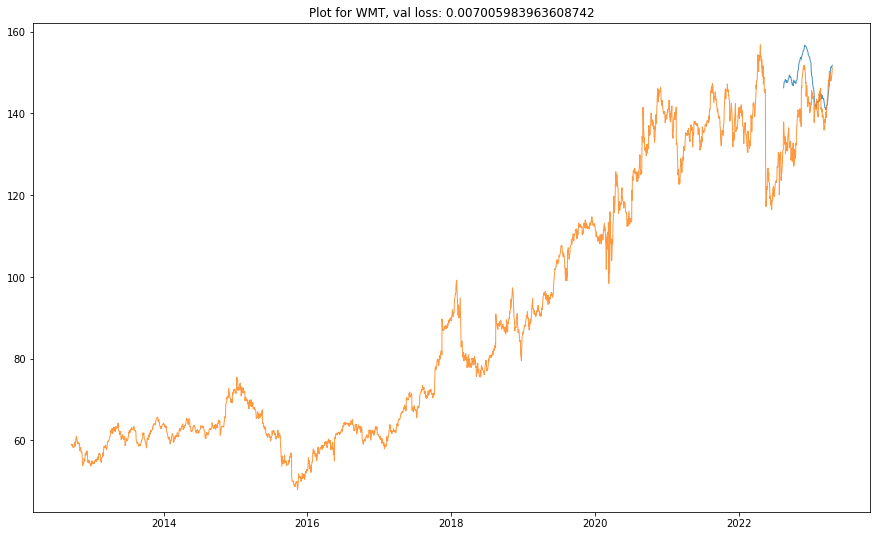

--------------------------
Final Train Loss: 0.0183
Final Test Loss: 0.009
--------------------------
Final Train MAPE: 100.21179962158203
Final Test MAPE: 6.698299884796143
Val loss for MCD: 0.006446716375648975


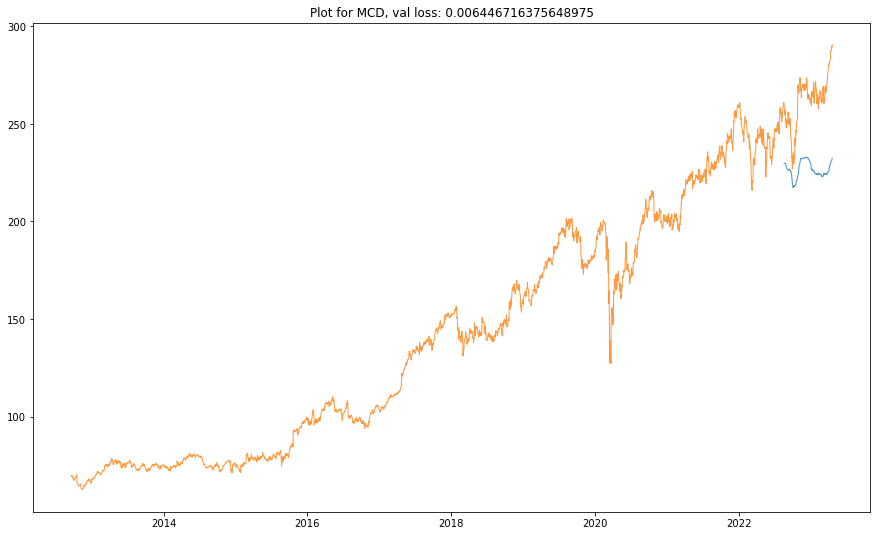

--------------------------
Final Train Loss: 0.0062
Final Test Loss: 0.0267
--------------------------
Final Train MAPE: 106.743896484375
Final Test MAPE: 13.355799674987793
Val loss for BAC: 0.011262410320341587


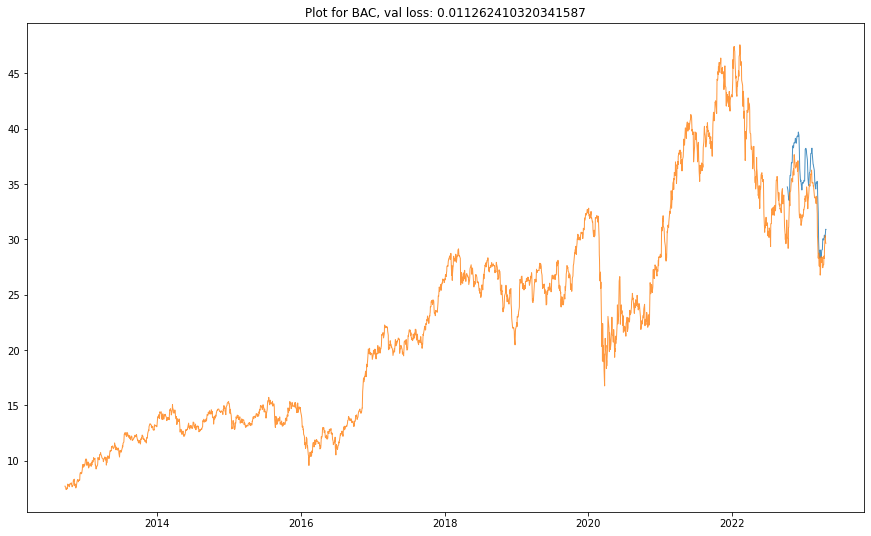

--------------------------
Final Train Loss: 0.0024
Final Test Loss: 0.0043
--------------------------
Final Train MAPE: 102.08360290527344
Final Test MAPE: 12.848299980163574
Val loss for CRM: 0.0033841729164123535


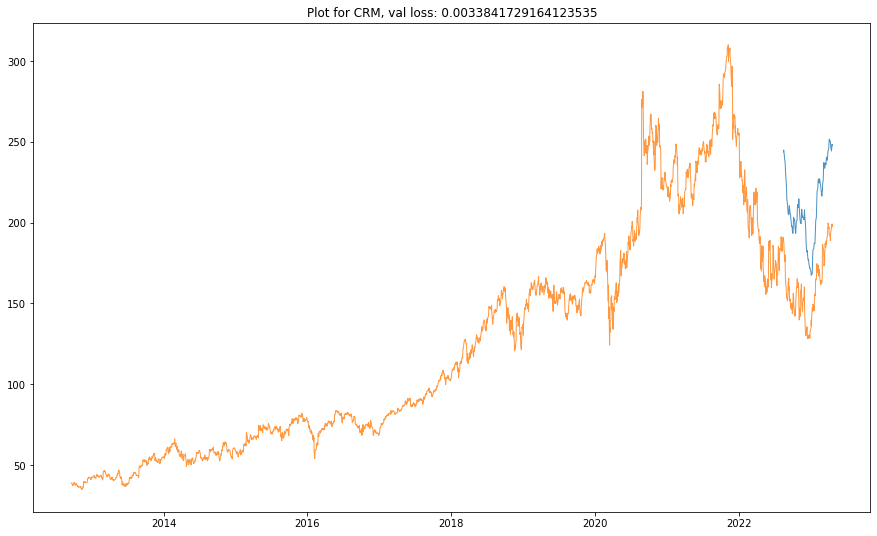

--------------------------
Final Train Loss: 0.0075
Final Test Loss: 0.0345
--------------------------
Final Train MAPE: 153.42979431152344
Final Test MAPE: 33.63130187988281


In [53]:
total_test_mape =0
total_train_mape =0

for i, (ticker, ds) in enumerate(stocks_data.items()):
    train_generator = ds['train_generator']
    valid_generator = ds['valid_generator']
    test_generator = ds['test_generator']
    
    x_scaler = ds['x_scaler']
    y_scaler = ds['y_scaler']
    
    filepath='models/{}.weights.best.hdf5'.format(ticker)
    OUTPUT_SIZE = 1
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(window_length, OUTPUT_SIZE*26)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(OUTPUT_SIZE))
    
    model.load_weights(filepath)

    model.compile(loss='mean_squared_error', optimizer='adam')
    
    val_loss = model.evaluate_generator(valid_generator)
    print('Val loss for {}: {}'.format(ticker, val_loss))
    
    # Make test predictions
    test_predict = model.predict_generator(test_generator)
    predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
    predicted_df = predicted_df.rename(columns={0: ticker})
    original_test = stocks_data[ticker]['y_test'].iloc[window_length:]
    predicted_df.index = original_test.index
    predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)
    test_acc = np.mean(mean_absolute_percentage_error(original_test,predicted_ticker[ticker]))
    
    train_predict = model.predict_generator(train_generator)
    train_predicted_df = pd.DataFrame(y_scaler.inverse_transform(train_predict))
    train_predicted_df = train_predicted_df.rename(columns={0: ticker})
    original_train = stocks_data[ticker]['y_train'].iloc[window_length:]
    train_predicted_df.index = original_train.index
    
    train_predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)
    train_acc = np.mean(mean_absolute_percentage_error(original_train,train_predicted_ticker[ticker]))
    
    total_train_mape+=train_acc
    total_test_mape+=test_acc
    
    %matplotlib inline
    plt.figure(figsize=(15, 9))

    plt.plot(predicted_ticker[ticker], linewidth=1, alpha=0.8)
    plt.plot(stocks_data[ticker]['y'], linewidth=1, alpha=0.8)
    #plt.plot(train_predicted_ticker[ticker], linewidth=1, alpha=0.8)
    #plt.plot(stocks_data[ticker]['y'], linewidth=1, alpha=0.8)
    plt.title('Plot for {}, val loss: {}'.format(ticker.upper(), val_loss))
    plt.savefig('plots/{}'.format(ticker))
    plt.show()
    #plot_model_performance(modelF,model,train_x,test_x,"accuracy", "val_accuracy")
    #plot_model_performance(model,train_generator,test_generator,"accuracy", "val_accuracy")
    train_loss = model.evaluate_generator(train_generator);
    test_loss  = model.evaluate_generator(test_generator);
    print('--------------------------')
    print(f'Final Train Loss: {np.round(train_loss,4)}')
    print(f'Final Test Loss: {np.round(test_loss,4)}') 
    print('--------------------------')
    print(f'Final Train MAPE: {np.round(train_acc,4)}')
    print(f'Final Test MAPE: {np.round(test_acc,4)}') 
    #print('\n')

In [54]:
print(f'Final MAPE score: Train={np.round(total_train_mape/len(stocks_data))}')
print(f'Final MAPE score: Test={np.round(total_test_mape/len(stocks_data))}')

Final MAPE score: Train=253.0
Final MAPE score: Test=17.0


## Write Predictions to a CSV File

In [55]:
count = 0

for i, (ticker, ds) in enumerate(stocks_data.items()):
    train_generator = ds['train_generator']
    valid_generator = ds['valid_generator']
    test_generator = ds['test_generator']
    
    x_scaler = ds['x_scaler']
    y_scaler = ds['y_scaler']
    
    filepath='models/{}.weights.best.hdf5'.format(ticker)
    OUTPUT_SIZE = 1
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(window_length, OUTPUT_SIZE * 26)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(OUTPUT_SIZE))
    
    model.load_weights(filepath)

    model.compile(loss='mean_squared_error', optimizer='adam')
    
#     val_loss = model.evaluate_generator(valid_generator)
#     print('Val loss for {}: {}'.format(ticker, val_loss))
    
    # Make test predictions
    test_predict = model.predict_generator(test_generator)
    predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
    predicted_df = predicted_df.rename(columns={0: ticker})
    
    original_test = stocks_data[ticker]['y_test'].iloc[window_length:]
    predicted_df.index = original_test.index
    
    if count > 0:
        predicted_ticker = pd.concat([predicted_df[ticker], predicted_ticker], axis=1)
    else: 
        predicted_ticker = predicted_df[ticker]
        
    count += 1

In [56]:
predicted_ticker.to_csv('predicted_adj_close_50.csv')

## Build RETURNS Dataframe to Predict Portfolios:
* We will use PANDAS pct_change method to build returns. This method basically returns the difference of value to the previous value

In [57]:
data = pd.read_csv('predicted_adj_close_50.csv')
data.index = data['Date']
data = data.drop(['Date'],axis=1)
data = data.sort_index(ascending=True, axis=0)
#data = data.iloc[0:91]
returns = data.pct_change()[1:]
returns

CRM       BAC       MCD       WMT       PFE      COST   
Date                                                                     
2022-08-04       NaN       NaN       NaN       NaN       NaN       NaN  \
2022-08-05       NaN       NaN       NaN       NaN       NaN       NaN   
2022-08-08       NaN       NaN       NaN       NaN       NaN       NaN   
2022-08-09       NaN       NaN       NaN       NaN       NaN       NaN   
2022-08-10       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2023-04-17 -0.007998 -0.004942  0.000725 -0.000815 -0.004703 -0.001510   
2023-04-18  0.006647  0.007377  0.000772  0.000173 -0.001640  0.000009   
2023-04-19  0.007281  0.010531  0.002462  0.001340  0.000010 -0.000769   
2023-04-20  0.002836  0.005898  0.001410  0.000935 -0.002204  0.000129   
2023-04-21 -0.002709 -0.000269  0.000807  0.000766 -0.005410 -0.001047   

                  KO       PEP       MRK       CVX  ...       XOM       UNH   
Date                                                ...                       
2022-08-04       NaN       NaN       NaN       NaN  ...       NaN       NaN  \
2022-08-05       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2022-08-08       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2022-08-09       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2022-08-10       NaN       NaN       NaN       NaN  ...       NaN       NaN   
...              ...       ...       ...       ...  ...       ...       ...   
2023-04-17 -0.000579 -0.002069  0.002428  0.000199  ... -0.000017 -0.000571   
2023-04-18  0.007318  0.000969 -0.001064 -0.000083  ... -0.000206 -0.003067   
2023-04-19  0.002339  0.000633  0.003176  0.002694  ...  0.001010 -0.000641   
2023-04-20  0.001958  0.000377  0.001898  0.000653  ...  0.001467 -0.002267   
2023-04-21  0.000958 -0.000446  0.001883 -0.000208  ... -0.000705 -0.004428   

                META      TSLA      GOOG     GOOGL      NVDA      AMZN   
Date                                                                     
2022-08-04       NaN       NaN  0.008134       NaN       NaN       NaN  \
2022-08-05       NaN       NaN  0.004102  0.003264       NaN  0.009075   
2022-08-08       NaN -0.001172 -0.001321 -0.000286       NaN  0.004530   
2022-08-09       NaN  0.021379  0.005119  0.006871       NaN  0.008706   
2022-08-10       NaN  0.012395  0.005488  0.005171       NaN  0.001155   
...              ...       ...       ...       ...       ...       ...   
2023-04-17 -0.001011 -0.016250 -0.004126 -0.002759 -0.004185 -0.003148   
2023-04-18  0.004496  0.016258  0.001662  0.002795  0.001155  0.008455   
2023-04-19  0.003739  0.006373  0.002572  0.000966  0.001517  0.004935   
2023-04-20  0.000035 -0.004324 -0.000887 -0.002121 -0.000390  0.006585   
2023-04-21 -0.003088 -0.015784 -0.004053 -0.003963 -0.002188  0.001054   

                MSFT      AAPL  
Date                            
2022-08-04       NaN       NaN  
2022-08-05       NaN       NaN  
2022-08-08       NaN       NaN  
2022-08-09       NaN       NaN  
2022-08-10       NaN       NaN  
...              ...       ...  
2023-04-17 -0.004380 -0.002198  
2023-04-18  0.002933  0.000245  
2023-04-19  0.006756  0.002371  
2023-04-20  0.004228  0.000522  
2023-04-21 -0.000059 -0.000968  

[180 rows x 28 columns]

In [58]:
returns.isna().sum()

CRM       9
BAC      46
MCD      12
WMT      10
PFE      36
COST     10
KO       28
PEP      15
MRK      22
CVX      11
HD        6
MA        4
AVGO      5
PG       17
LLY      12
V        10
JPM      14
JNJ      14
XOM       8
UNH       9
META      8
TSLA      2
GOOG      0
GOOGL     1
NVDA     16
AMZN      1
MSFT     22
AAPL      5
dtype: int64

In [59]:
Covariance = returns.cov()
Correlation = returns.corr()
np.round(Correlation,3)

CRM    BAC    MCD    WMT    PFE   COST     KO    PEP    MRK    CVX   
CRM    1.000  0.370  0.278  0.204  0.042  0.180  0.363  0.388 -0.060  0.297  \
BAC    0.370  1.000  0.288  0.307  0.376  0.209  0.265  0.377  0.058  0.397   
MCD    0.278  0.288  1.000  0.633  0.533  0.378  0.233  0.434  0.375  0.569   
WMT    0.204  0.307  0.633  1.000  0.681  0.355  0.214  0.519  0.380  0.431   
PFE    0.042  0.376  0.533  0.681  1.000  0.413  0.349  0.557  0.212  0.368   
COST   0.180  0.209  0.378  0.355  0.413  1.000  0.224  0.214 -0.271  0.306   
KO     0.363  0.265  0.233  0.214  0.349  0.224  1.000  0.489 -0.189  0.169   
PEP    0.388  0.377  0.434  0.519  0.557  0.214  0.489  1.000  0.232  0.379   
MRK   -0.060  0.058  0.375  0.380  0.212 -0.271 -0.189  0.232  1.000  0.257   
CVX    0.297  0.397  0.569  0.431  0.368  0.306  0.169  0.379  0.257  1.000   
HD     0.427  0.276  0.408  0.388  0.426  0.529  0.531  0.565 -0.031  0.540   
MA     0.585  0.547  0.424  0.271  0.428  0.447  0.568  0.421 -0.005  0.519   
AVGO   0.638  0.488  0.357  0.200  0.351  0.174  0.583  0.428  0.021  0.349   
PG     0.309  0.303  0.599  0.589  0.758  0.250  0.460  0.538  0.240  0.433   
LLY    0.190  0.309  0.208  0.118  0.212  0.188  0.269  0.408  0.171  0.419   
V      0.483  0.528  0.623  0.471  0.523  0.522  0.324  0.400  0.200  0.599   
JPM    0.455  0.823  0.411  0.414  0.413  0.293  0.293  0.365  0.168  0.437   
JNJ    0.206  0.471  0.376  0.407  0.628  0.272  0.382  0.465  0.209  0.504   
XOM    0.331  0.488  0.356  0.373  0.290  0.316  0.213  0.332  0.117  0.773   
UNH    0.020  0.278  0.546  0.614  0.681  0.576  0.133  0.465  0.198  0.468   
META   0.504  0.156  0.029 -0.033 -0.084  0.329  0.308  0.151 -0.259  0.211   
TSLA   0.460  0.240  0.098  0.349  0.342  0.225  0.432  0.438 -0.293  0.124   
GOOG   0.679  0.352  0.291  0.209  0.234  0.424  0.386  0.349 -0.160  0.400   
GOOGL  0.649  0.278  0.250  0.156  0.172  0.368  0.433  0.341 -0.184  0.326   
NVDA   0.467  0.196  0.477  0.376  0.470  0.562  0.323  0.333 -0.149  0.225   
AMZN   0.618  0.125 -0.088  0.095 -0.187 -0.128  0.203  0.198 -0.069  0.051   
MSFT   0.608  0.291  0.186  0.140  0.237  0.342  0.272  0.280 -0.089  0.371   
AAPL   0.637  0.174  0.325  0.467  0.241 -0.105  0.243  0.409  0.233  0.267   

       ...    XOM    UNH   META   TSLA   GOOG  GOOGL   NVDA   AMZN   MSFT   
CRM    ...  0.331  0.020  0.504  0.460  0.679  0.649  0.467  0.618  0.608  \
BAC    ...  0.488  0.278  0.156  0.240  0.352  0.278  0.196  0.125  0.291   
MCD    ...  0.356  0.546  0.029  0.098  0.291  0.250  0.477 -0.088  0.186   
WMT    ...  0.373  0.614 -0.033  0.349  0.209  0.156  0.376  0.095  0.140   
PFE    ...  0.290  0.681 -0.084  0.342  0.234  0.172  0.470 -0.187  0.237   
COST   ...  0.316  0.576  0.329  0.225  0.424  0.368  0.562 -0.128  0.342   
KO     ...  0.213  0.133  0.308  0.432  0.386  0.433  0.323  0.203  0.272   
PEP    ...  0.332  0.465  0.151  0.438  0.349  0.341  0.333  0.198  0.280   
MRK    ...  0.117  0.198 -0.259 -0.293 -0.160 -0.184 -0.149 -0.069 -0.089   
CVX    ...  0.773  0.468  0.211  0.124  0.400  0.326  0.225  0.051  0.371   
HD     ...  0.461  0.496  0.349  0.375  0.601  0.538  0.553  0.154  0.409   
MA     ...  0.454  0.382  0.513  0.453  0.707  0.617  0.508  0.271  0.689   
AVGO   ...  0.318  0.141  0.467  0.404  0.619  0.593  0.454  0.328  0.610   
PG     ...  0.265  0.438  0.217  0.363  0.420  0.363  0.461  0.064  0.477   
LLY    ...  0.327  0.240  0.144  0.004  0.326  0.333 -0.098  0.235  0.378   
V      ...  0.501  0.550  0.331  0.219  0.633  0.588  0.577  0.076  0.540   
JPM    ...  0.531  0.361  0.256  0.202  0.393  0.314  0.346  0.208  0.405   
JNJ    ...  0.383  0.419  0.137  0.279  0.390  0.347  0.114  0.146  0.547   
XOM    ...  1.000  0.350  0.212  0.146  0.311  0.246  0.244  0.129  0.318   
UNH    ...  0.350  1.000 -0.007  0.223  0.245  0.136  0.478 -0.210  0.187   
META   ...  0.212 -0.007  1.000  0.333  0.682  0.671  0.325  0.376  0.667   
TSLA   ...  0.146  0.22

In [60]:
Covariance

CRM       BAC           MCD       WMT       PFE          COST   
CRM    1.348197e-04  0.000054  7.479050e-06  0.000007  0.000002  4.181577e-06  \
BAC    5.382456e-05  0.000157  7.551364e-06  0.000013  0.000024  4.918288e-06   
MCD    7.479050e-06  0.000008  5.275716e-06  0.000005  0.000006  1.736729e-06   
WMT    7.428081e-06  0.000013  4.531567e-06  0.000010  0.000011  2.212283e-06   
PFE    2.443693e-06  0.000024  6.468619e-06  0.000011  0.000026  4.226273e-06   
COST   4.181577e-06  0.000005  1.736729e-06  0.000002  0.000004  3.965594e-06   
KO     1.782930e-05  0.000013  2.355428e-06  0.000003  0.000007  1.896816e-06   
PEP    1.057455e-05  0.000010  2.331807e-06  0.000004  0.000006  1.000852e-06   
MRK   -2.244808e-06  0.000002  2.857513e-06  0.000004  0.000004 -1.778532e-06   
CVX    8.832255e-06  0.000011  3.335890e-06  0.000003  0.000005  1.551008e-06   
HD     1.941049e-05  0.000013  3.700558e-06  0.000005  0.000008  4.135984e-06   
MA     3.834440e-05  0.000037  5.531147e-06  0.000005  0.000012  5.033106e-06   
AVGO   2.853133e-05  0.000022  3.174215e-06  0.000002  0.000007  1.337639e-06   
PG     1.285347e-05  0.000013  4.946690e-06  0.000007  0.000014  1.794278e-06   
LLY    9.565567e-06  0.000017  2.060672e-06  0.000002  0.000005  1.620964e-06   
V      2.480374e-05  0.000026  6.346814e-06  0.000007  0.000012  4.590958e-06   
JPM    3.832447e-05  0.000072  6.830415e-06  0.000009  0.000015  4.236974e-06   
JNJ    1.002398e-05  0.000026  3.617665e-06  0.000005  0.000014  2.269555e-06   
XOM    1.740488e-05  0.000023  3.735273e-06  0.000005  0.000007  2.854008e-06   
UNH    7.199009e-07  0.000011  3.913875e-06  0.000006  0.000011  3.560513e-06   
META   7.895838e-05  0.000027  8.975175e-07 -0.000001 -0.000006  8.848379e-06   
TSLA   7.006462e-05  0.000042  2.963970e-06  0.000014  0.000024  5.876710e-06   
GOOG   5.106500e-05  0.000029  4.354083e-06  0.000004  0.000008  5.476422e-06   
GOOGL  4.265595e-05  0.000020  3.264730e-06  0.000003  0.000005  4.145872e-06   
NVDA   2.963213e-05  0.000013  5.977652e-06  0.000006  0.000013  6.126451e-06   
AMZN   7.167775e-05  0.000017 -2.037015e-06  0.000003 -0.000010 -2.547539e-06   
MSFT   4.101214e-05  0.000022  2.549309e-06  0.000003  0.000007  4.040986e-06   
AAPL   2.422473e-05  0.000007  2.460486e-06  0.000005  0.000004 -6.829331e-07   

             KO       PEP           MRK       CVX  ...       XOM   
CRM    0.000018  0.000011 -2.244808e-06  0.000009  ...  0.000017  \
BAC    0.000013  0.000010  2.486082e-06  0.000011  ...  0.000023   
MCD    0.000002  0.000002  2.857513e-06  0.000003  ...  0.000004   
WMT    0.000003  0.000004  3.941389e-06  0.000003  ...  0.000005   
PFE    0.000007  0.000006  3.598809e-06  0.000005  ...  0.000007   
COST   0.000002  0.000001 -1.778532e-06  0.000002  ...  0.000003   
KO     0.000018  0.000005 -2.644353e-06  0.000002  ...  0.000004   
PEP    0.000005  0.000005  1.675244e-06  0.000002  ...  0.000004   
MRK   -0.000003  0.000002  1.066144e-05  0.000002  ...  0.000002   
CVX    0.000002  0.000002  2.160696e-06  0.000006  ...  0.000009   
HD     0.000009  0.000005 -4.046965e-07  0.000005  ...  0.000008   
MA     0.000014  0.000006 -8.505236e-08  0.000007  ...  0.000012   
AVGO   0.000009  0.000004  2.564567e-07  0.000003  ...  0.000006   
PG     0.000007  0.000004  2.779084e-06  0.000004  ...  0.000004   
LLY    0.000005  0.000004  2.420438e-06  0.000005  ...  0.000006   
V      0.000006  0.000004  2.904703e-06  0.000007  ...  0.000010   
JPM    0.000009  0.000006  3.977833e-06  0.000008  ...  0.000018   
JNJ    0.000007  0.000004  2.879722e-06  0.000005  ...  0.000007   
XOM    0.000004  0.000004  1.740027e-06  0.000009  ...  0.000020   
UNH    0.000002  0.000003  2.061173e-06  0.000004  ...  0.000005   
META   0.000018  0.000005 -1.172296e-05  0.000007  ...  0.000013   
TSLA   0.000025  0.000013 -1.280173e-05  0.000004  ...  0.000009   
GOOG   0.000011  0.000005 -3.446165e-06  0.000007  ...  0.000009   
GOOGL  0.000011  0.000005 -3.44735

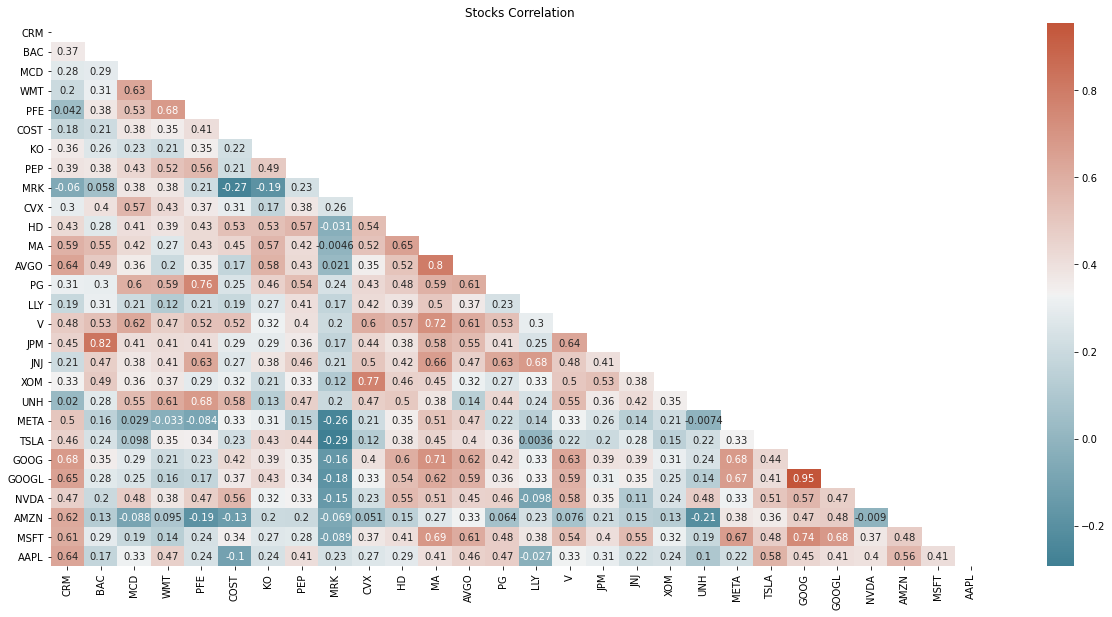

In [61]:
correlation_matrix_plot(Correlation)

In [62]:
companies = SP500_top30[0:28]#['AAPL', 'MSFT', 'META', 'TSLA', 'UNH', 'GOOGL']
mean_Covariance = Covariance.mean()
mean_Covariance

CRM      3.051575e-05
BAC      2.626064e-05
MCD      3.864705e-06
WMT      5.406559e-06
PFE      8.792072e-06
COST     3.093901e-06
KO       8.279357e-06
PEP      4.877177e-06
MRK      1.307821e-07
CVX      4.952276e-06
HD       9.295683e-06
MA       1.681386e-05
AVGO     1.031966e-05
PG       7.978553e-06
LLY      6.392831e-06
V        1.143137e-05
JPM      1.712610e-05
JNJ      8.965780e-06
XOM      8.383879e-06
UNH      4.581136e-06
META     2.795308e-05
TSLA     2.809584e-05
GOOG     1.846102e-05
GOOGL    1.488366e-05
NVDA     1.127797e-05
AMZN     1.631461e-05
MSFT     1.579396e-05
AAPL     6.765979e-06
dtype: float64

### Check if a particular pair of stock can be paired together
* If a pair of stock meets both Covariance and correlation thresholds then they can be paired together. The plot below shows pairable stocks in blue and unpairable ones in red.

In [157]:
def get_pairable(data, Covariance, Correlation):
    Pairable = np.zeros(Covariance.shape)
    plt.figure(figsize=(16,7))

    for i in range(len(companies)):
        for j in range(len(companies)-i):
            if((Covariance[i,j] > mean_Covariance[i])\
               or (Covariance[i,j] > mean_Covariance[j])\
               or Correlation[i][j]>0.5):
                plt.plot(i, j, 'o', color='red', alpha=0.5) 
            else:
                plt.plot(i, j, 'o', color='blue', alpha=0.5)
                Pairable[i,j] = 1

    plt.xlim(-1,len(companies)+1)
    plt.ylim(-1,len(companies)+1)
    plt.xticks(range(len(companies)), companies, rotation=40)    
    plt.yticks(range(len(companies)), companies)
    plt.legend(['Not Pairable'], loc='upper right', fontsize=15)
    #plt.set_xticklabels(companies,fontsize=10,rotation=40)
    #plt.legend()
    plt.show()
    plt.savefig("./figures/pairable_stocks.png")
    return Pairable

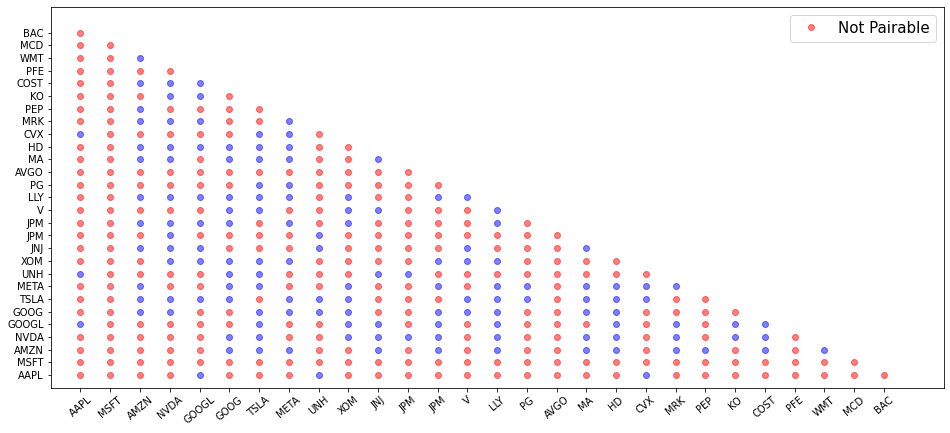

<Figure size 432x288 with 0 Axes>

In [158]:
Pairable = get_pairable(data,np.array(Covariance), np.array(Correlation))

In [65]:
Pairable

array([[0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
        0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
        0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
        0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
        0., 1., 1., 1., 1

##  Risk-Adjusted Returns
The **Sharpe ratio**—also known as the modified Sharpe ratio or the Sharpe index—is a way to measure the performance of an investment by taking risk into account. It can be used to evaluate a single security or an entire investment portfolio. In either case, the higher the ratio, the better the investment in terms of risk-adjusted returns.

The Sharpe Ratio is calculated by determining an asset or a portfolio’s “excess return” for a given period of time. This amount is divided by the portfolio’s standard deviation, which is a measure of its volatility. To calculate the Sharpe Ratio, use this formula:

        * Sharpe Ratio = (Rp – Rf) / Standard deviation
**Rp**: return of portfolio/mean return

**Rf**: risk-free rate of 3.7% ie current risk free rate of US market

**Standard Deviation**: standard deviation of the portfolio’s excess return

**Sharpe ratio > 1** is considered **good**

**Sharpe ratio > 2** is considered **very good**

**Sharpe ratio > 3** is considered **excellent**

*Limitations:* Sharpe ratio assumes that an investment’s average returns are normally distributed on a curve.Unfortunately, normal distributions don’t represent the real world of financial markets very well. Over the short term, investment returns don’t follow a normal distribution. Market volatility can be higher or lower, while the distribution of returns on a curve cluster around the tails. This can render standard deviation less effective as a measure of risk.


In [66]:
# Function to calculate the Shapre Ratio
Rf = 0/100;#3.7/100  #risk_free_rate
stocks_rng = range(len(companies))

def sharpe_ratio(pair, portfolio_weights, meanR, cov):
    #print("SR",pair,portfolio_weights, meanR, cov)
    #print (meanR.T)
    Rp = portfolio_weights.dot(meanR.T) 
    SigmaP = portfolio_weights.dot(cov.dot(portfolio_weights.T)) * len(returns)
    s_ratio = (Rp - Rf)/np.sqrt(SigmaP)
    print (s_ratio)#, Rp, SigmaP, Rf)
    return s_ratio


In [67]:
stocks_rng

range(0, 28)

**Checking whether other stocks can be added to selected pair**
* Only those pairs are selected in a portfolio that are not correlated with each other.

In [68]:
def check_pairs(pair):
    not_in_pair = []
    for i in stocks_rng:
        if(i not in pair):
            not_in_pair.append(i)
        else:
            continue
            
    for tick in not_in_pair:
        total_pair = len(pair)
        for i in pair:
            if(Pairable[tick,i]!=1 or Pairable[i,tick]!=1):
                total_pair -= 1
        if(float(total_pair)/len(pair) > 0.5):
            pair.add(tick)              
    return pair

* Just some checks to see what the covariance and correlations 

In [69]:
#symbols = [companies[s] for s in pair] 
symbols =['AAPL', 'MSFT', 'GOOGL', 'META']
len(returns)
returns[symbols[3]].mean()*len(returns)
returns[symbols].cov()

AAPL      MSFT     GOOGL      META
AAPL   0.000011  0.000008  0.000007  0.000010
MSFT   0.000008  0.000034  0.000023  0.000054
GOOGL  0.000007  0.000023  0.000031  0.000051
META   0.000010  0.000054  0.000051  0.000182

Analyzing returns for:  PEP


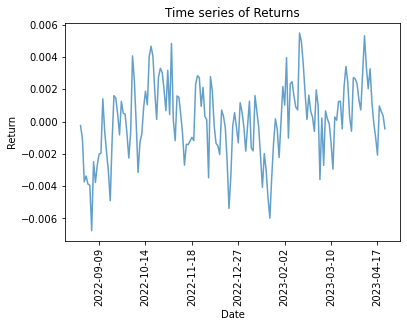

In [70]:
ticker = companies[21]
print("Analyzing returns for: ", ticker)
plt.title('Time series of Returns')
returns[ticker].plot(alpha=0.7)
plt.xticks(rotation=90)
plt.ylabel("Return")
plt.show()

### Selecting Optimized Portfolios
We create all possible combinations of pairs in given list of tickers. For example if we have **n** tickers, then possible pairs will be **C(n,2)= n!/(2!*(n-2)!)**

* For each pair, we then check which other stock can be added together by checking it's correlation and covariance values, and they are added in same portfolio.

* Portfolis with good, better, best Sharpe Ratio are saved separately.

In [71]:
portfolio_collection = []
optim = {'good':[],'better':[],'best': []}

def select(combo):
    pair = set(combo)
    pair = check_pairs(pair)
    #print("new pair by checking pairable: ", pair)
    if pair in portfolio_collection:
        #print('returning')
        return
    portfolio_collection.append(pair)
    #print("portfoilio: ", portfolio_collection)
    sharpe_r = 0
    eff_weights = np.ones(len(pair))

    symbols = [companies[s] for s in pair]  
    mean_returns = np.array(returns[symbols].mean()) * len(returns)
    sub_cov_mat = np.array(returns[symbols].cov())        
    print(symbols)#, mean_returns, sub_cov_mat)
    for _ in range(10):
        weights = [np.random.randint(50,500) for _ in pair]
        weights = np.array(weights, dtype=float)
        weights /= weights.sum()
        s_r = sharpe_ratio(pair, weights, mean_returns, sub_cov_mat)
        #print(pair)
        print(weights)
        #print(mean_returns)
        #print(sub_cov_mat)
        if( s_r > sharpe_r):
            sharpe_r = s_r
            eff_weights = weights
        
    if (sharpe_r >= 1 and sharpe_r < 2) :
        optim['good'].append([[companies[s] for s in pair],eff_weights,sharpe_r])
    if (sharpe_r >= 2 and sharpe_r < 3) :
        optim['better'].append([[companies[s] for s in pair],eff_weights,sharpe_r])
    if(sharpe_r >=3) :
        optim['best'].append([[companies[s] for s in pair],eff_weights,sharpe_r])

In [72]:
#(returns["MSFT"].mean())/returns["MSFT"].std()

* Make stocks combinations with each pair containing 2 stocks and rest of the stocks to be added later

In [73]:
from itertools import combinations
count=0
run = list(combinations(stocks_rng,2))
for combo in run:
    count +=1
    if(Pairable[combo[0],combo[1]]!=1 or Pairable[combo[1],combo[0]]!=1):
        continue
    else:
        #print("taking the combo")
        print(combo)
        select(combo)
print("number of combinations: ", count)

(0, 4)
['AAPL', 'GOOGL']
-0.215848057531847
[0.21327014 0.78672986]
-0.2660478052540199
[0.60571429 0.39428571]
-0.25091884492297306
[0.47666667 0.52333333]
-0.26403604282428167
[0.58616011 0.41383989]
-0.2602417300836765
[0.55204216 0.44795784]
-0.24234297695237306
[0.41212121 0.58787879]
-0.25056349392975713
[0.47393365 0.52606635]
-0.24764222690163712
[0.45170068 0.54829932]
-0.27468428018119745
[0.72344689 0.27655311]
-0.2310115050610421
[0.32846715 0.67153285]
(0, 8)
['AAPL', 'UNH']
-0.6809245237778431
[0.64850615 0.35149385]
-0.927966989183839
[0.43387816 0.56612184]
-0.9629465658244677
[0.39082058 0.60917942]
-0.6550901265707562
[0.66808511 0.33191489]
-1.0242877327043662
[0.2797619 0.7202381]
-0.7867615191255555
[0.56573705 0.43426295]
-0.44864082868916944
[0.82807018 0.17192982]
-1.0246576663918736
[0.27876106 0.72123894]
-0.3853175708513542
[0.88157895 0.11842105]
-1.049932909227203
[0.12315271 0.87684729]
(0, 19)
['AAPL', 'CVX']
0.002290961644925343
[0.5954023 0.4045977]
-0.

In [74]:
portfolio_collection

[{0, 4},
 {0, 8},
 {0, 19},
 {2, 5, 6, 7, 9, 12, 14, 17},
 {2, 10, 17},
 {2, 5, 6, 7, 9, 12, 13, 14},
 {2, 5, 6, 7, 9, 12, 14, 18},
 {2, 7, 12, 14, 20},
 {2, 21},
 {2, 23},
 {2, 25},
 {3, 5, 6, 7, 9, 12, 14, 17},
 {3, 10, 17},
 {3, 11},
 {3, 5, 6, 7, 9, 12, 13, 14},
 {3, 5, 6, 7, 9, 12, 14, 18},
 {3, 20},
 {3, 22},
 {3, 23},
 {4, 6, 9, 12, 14},
 {4, 6, 7, 9, 12, 14},
 {4, 10},
 {4, 9, 12, 14},
 {4, 6, 7, 9, 12, 14, 18},
 {4, 20},
 {4, 22},
 {4, 23},
 {2, 3, 5, 6, 7, 9, 12, 14, 17, 18},
 {5, 6, 7, 8, 9, 12, 14},
 {5, 6, 7, 9, 12, 13, 14},
 {3, 4, 5, 6, 7, 9, 12, 14, 18},
 {6, 7, 9, 14, 15},
 {6, 7, 9, 14, 19},
 {2, 5, 6, 7, 9, 12, 14, 20},
 {8, 10},
 {8, 11},
 {10, 13},
 {2, 3, 5, 6, 7, 9, 10, 12, 14, 17}]

### Look at DataFrame for Good Portfolios

In [75]:
good = pd.DataFrame.from_dict(optim['good'])
good.columns = ['Portfolio', 'Weights', 'Sharpe Ratio']

In [76]:
def build_portfolio_return(df_ret):
    portfolio_return = []
    for row in df_ret.iterrows():
        print(row[1][0])
        print(row[1][1])
        mean = np.array(returns[row[1][0]].mean()) * len(returns)
        portfolio_weights = np.array(row[1][1])
        Rp = portfolio_weights.dot(mean.T) 
        portfolio_return.append(round(Rp * 100, 2))
        #print('Rp:', Rp)
    return portfolio_return

In [77]:
good['Portfolio_Returns'] = build_portfolio_return(good)

['MA', 'JNJ', 'NVDA']
[0.55830389 0.11425206 0.32744405]
['JPM', 'NVDA']
[0.55920114 0.44079886]
['NVDA', 'GOOG', 'TSLA', 'META', 'XOM', 'JPM', 'V', 'LLY']
[0.1519219  0.06101281 0.07443563 0.09151922 0.26845638 0.07138499
 0.1128737  0.16839536]
['NVDA', 'GOOG', 'TSLA', 'META', 'XOM', 'JPM', 'LLY', 'HD']
[0.14345351 0.09297913 0.0455408  0.17647059 0.17343454 0.1426945
 0.14155598 0.08387097]
['NVDA', 'KO']
[0.64294955 0.35705045]
['GOOGL', 'TSLA', 'XOM', 'JPM', 'LLY']
[0.11548791 0.11906893 0.13249776 0.35094002 0.28200537]
['GOOGL', 'TSLA', 'META', 'XOM', 'JPM', 'LLY']
[0.13473054 0.10179641 0.30688623 0.21257485 0.16766467 0.07634731]
['GOOGL', 'TSLA', 'META', 'XOM', 'JPM', 'LLY', 'HD']
[0.10415375 0.08245505 0.25232486 0.1599504  0.10415375 0.20396776
 0.09299442]
['GOOGL', 'MRK']
[0.43209877 0.56790123]
['GOOG', 'TSLA', 'META', 'UNH', 'XOM', 'JPM', 'LLY']
[0.04568966 0.10172414 0.15646552 0.13448276 0.18793103 0.19655172
 0.17715517]
['GOOG', 'TSLA', 'META', 'XOM', 'JPM', 'V', 'L

In [78]:
def build_portfolio_voltality(df_ret):
    portfolio_volatility = []
    for row in df_ret.iterrows():
        portfolio = row[1][0]
        portfolio_weights = row[1][1]
        portfolio_data = data[portfolio]
        portfolio = portfolio_data.mul(portfolio_weights,axis=1).sum(axis=1)
        volatility = np.std(portfolio)
        portfolio_volatility.append(volatility)
    return portfolio_volatility

In [79]:
good['Portfolio_Volatility'] = build_portfolio_voltality(good)
good

Portfolio   
0                                      [MA, JNJ, NVDA]  \
1                                          [JPM, NVDA]   
2           [NVDA, GOOG, TSLA, META, XOM, JPM, V, LLY]   
3          [NVDA, GOOG, TSLA, META, XOM, JPM, LLY, HD]   
4                                           [NVDA, KO]   
5                         [GOOGL, TSLA, XOM, JPM, LLY]   
6                   [GOOGL, TSLA, META, XOM, JPM, LLY]   
7               [GOOGL, TSLA, META, XOM, JPM, LLY, HD]   
8                                         [GOOGL, MRK]   
9               [GOOG, TSLA, META, UNH, XOM, JPM, LLY]   
10                [GOOG, TSLA, META, XOM, JPM, V, LLY]   
11  [NVDA, GOOGL, GOOG, TSLA, META, XOM, JPM, LLY, HD]   
12                          [TSLA, META, XOM, LLY, PG]   
13                         [TSLA, META, XOM, LLY, CVX]   
14                                          [UNH, JPM]   
15                                            [JNJ, V]   

                                                                                                                                                                                         Weights   
0                                                                                                                                  [0.558303886925795, 0.11425206124852769, 0.32744405182567726]  \
1                                                                                                                                                      [0.5592011412268189, 0.44079885877318115]   
2                          [0.15192190359975594, 0.06101281269066504, 0.07443563148261134, 0.09151921903599756, 0.2684563758389262, 0.0713849908480781, 0.11287370347773032, 0.1683953630262355]   
3                        [0.14345351043643265, 0.09297912713472485, 0.04554079696394687, 0.17647058823529413, 0.17343453510436432, 0.1426944971537002, 0.14155597722960153, 0.08387096774193549]   
4                                                                                                                                                      [0.6429495472186287, 0.35705045278137126]   
5                                                                                       [0.11548791405550582, 0.11906893464637422, 0.13249776186213072, 0.35094001790510293, 0.2820053715308863]   
6                                                                    [0.1347305389221557, 0.10179640718562874, 0.3068862275449102, 0.2125748502994012, 0.16766467065868262, 0.07634730538922156]   
7                                              [0.10415375077495351, 0.08245505269683819, 0.2523248605083695, 0.15995040297582144, 0.10415375077495351, 0.20396776193428395, 0.0929944203347799]   
8                                                                                                                                                      [0.43209876543209874, 0.5679012345679012]   
9                                              [0.045689655172413794, 0.10172413793103448, 0.1564655172413793, 0.13448275862068965, 0.1879310344827586, 0.19655172413793104, 0.1771551724137931]   
10                                           [0.18136714443219404, 0.05733186328555678, 0.19459757442116868, 0.10694597574421169, 0.12844542447629548, 0.056780595369349506, 0.2745314222712238]   
11  [0.11854402361042794, 0.07919331037875062, 0.06492867683226758, 0.04476143630103296, 0.11657648794884408, 0.10231185440236104, 0.1647811116576488, 0.22282341367437286, 0.08607968519429415]   
12                                                                                       [0.08867427568042142, 0.1791044776119403, 0.16593503072870938, 0.28094820017559263, 0.2853380158033363]   
13                                                                                      [0.06310254163014899, 0.12357581069237511, 0.3873794916739702, 0.16389132340052587, 0.26205083260297984]   
14                                                                                                                    

In [80]:
optim['better']

[[['AMZN', 'META', 'JPM', 'LLY', 'MRK'],
  array([0.06165541, 0.12584459, 0.10219595, 0.40287162, 0.30743243]),
  2.5828636099904543],
 [['NVDA', 'MRK'], array([0.31555556, 0.68444444]), 2.9996359954170178],
 [['XOM', 'GOOGL', 'JPM', 'LLY'],
  array([0.13402959, 0.13228895, 0.35509138, 0.37859008]),
  2.0899316096646245]]

In [81]:
better = pd.DataFrame.from_dict(optim['better'])
better.columns = ['Portfolio', 'Weights', 'Sharpe Ratio']

In [82]:
better['Portfolio_Returns'] = build_portfolio_return(better)
better['Portfolio_Volatility'] = build_portfolio_voltality(better)

['AMZN', 'META', 'JPM', 'LLY', 'MRK']
[0.06165541 0.12584459 0.10219595 0.40287162 0.30743243]
['NVDA', 'MRK']
[0.31555556 0.68444444]
['XOM', 'GOOGL', 'JPM', 'LLY']
[0.13402959 0.13228895 0.35509138 0.37859008]


In [83]:
better

Portfolio   
0  [AMZN, META, JPM, LLY, MRK]  \
1                  [NVDA, MRK]   
2       [XOM, GOOGL, JPM, LLY]   

                                                                                                   Weights   
0  [0.06165540540540541, 0.1258445945945946, 0.10219594594594594, 0.4028716216216216, 0.30743243243243246]  \
1                                                                [0.31555555555555553, 0.6844444444444444]   
2                        [0.134029590948651, 0.13228894691035684, 0.35509138381201044, 0.3785900783289817]   

   Sharpe Ratio  Portfolio_Returns  Portfolio_Volatility  
0      2.582864              11.64             35.074324  
1      2.999636              10.46             32.084729  
2      2.089932              11.47             33.519018

In [126]:
#train_generator
stocks_data['AAPL'].items()

dict_items([('x',                   open        high         low     volume  Year  Month  Week   
Date                                                                           
2012-09-20   24.969999   25.002144   24.772142  336568400  2012      9    38  \
2012-09-21   25.086071   25.181070   24.977142  571589200  2012      9    38   
2012-09-24   24.530714   24.825714   24.392857  639766400  2012      9    39   
2012-09-25   24.580713   24.742144   24.035713  518789600  2012      9    39   
2012-09-26   23.883572   24.024643   23.614286  576503200  2012      9    39   
...                ...         ...         ...        ...   ...    ...   ...   
2023-04-17  165.089996  165.389999  164.029999   41516200  2023      4    16   
2023-04-18  166.100006  167.410004  165.649994   49923000  2023      4    16   
2023-04-19  165.800003  168.160004  165.539993   47720200  2023      4    16   
2023-04-20  166.089996  167.869995  165.559998   52456400  2023      4    16   
2023-04-21  165.050003

In [85]:
#Defining MAPE function
#def MAPE(Y_actual,Y_Predicted):
#    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
#    return mape


# LSTM Model to Predict Future (30 days ahead)

In [86]:
#model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
#model.add(LSTM(50, activation='relu'))
EPOCHS = 100
early_stopping = [EarlyStopping(monitor='val_loss', patience=10)]
for i, (ticker, ds) in enumerate(stocks_data.items()):
    train_generator = ds['train_generator']
    valid_generator = ds['valid_generator']
    test_generator = ds['test_generator']
    
    OUTPUT_SIZE = 30
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(window_length, 26)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(OUTPUT_SIZE))
    
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mean_absolute_percentage_error'])
    #model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mean_absolute_error'])
    
    # Tensorboard
    tensorboard = TensorBoard(log_dir='logs/{}-{}'.format(ticker, time()))
    
    # Checkpoint
    filepath='models_vanilla/{}.weights.best.hdf5'.format(ticker)
    checkpoint = ModelCheckpoint(filepath, save_best_only=True)
    callbacks_list = [tensorboard,early_stopping,checkpoint]
    
    print('*' * 5 + 'Training for {}'.format(ticker))
    model.fit_generator(
        train_generator, 
        validation_data=valid_generator, 
        shuffle=False,
        epochs=EPOCHS, 
        verbose=1, 
        callbacks=callbacks_list
    )
    model.save(filepath)
    
    
    
    # --Plots while training
    val_loss = model.evaluate_generator(valid_generator)
    print('Val loss for {}: {}'.format(ticker, val_loss))
    
    # Make test predictions
    #test_predict = model.predict_generator(test_generator)
    #predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
    #predicted_df = predicted_df.rename(columns={0: ticker})
    #original_test = stocks_data[ticker]['y_test'].iloc[window_length:]
    #predicted_df.index = original_test.index
    #predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)
    

*****Training for AAPL
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0054 - mean_absolute_percentage_error: 23126.5117 - val_loss: 0.0304 - val_mean_absolute_percentage_error: 17.8162
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0131 - mean_absolute_percentage_error: 178358.1406 - val_loss: 0.0357 - val_mean_absolute_percentage_error: 19.6803
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0072 - mean_absolute_percentage_error: 123155.5938 - val_loss: 0.0153 - val_mean_absolute_percentage_error: 11.3221
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0050 - mean_absolute_percentage_error: 13660.6045 - val_loss: 0.0304 - val_mean_absolute_percentage_error: 18.3742
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0030 - mean_absolute_percentage_error: 50964.8750 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 14.2831
Epoch 6/10

Epoch 30/100
114/114 [==============================] - 3s 25ms/step - loss: 8.7979e-04 - mean_absolute_percentage_error: 58.2662 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 6.9850
Epoch 31/100
114/114 [==============================] - 3s 26ms/step - loss: 5.7903e-04 - mean_absolute_percentage_error: 22.8648 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 7.2110
Epoch 32/100
114/114 [==============================] - 3s 27ms/step - loss: 8.6417e-04 - mean_absolute_percentage_error: 49.1281 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 6.4390
Epoch 33/100
114/114 [==============================] - 3s 28ms/step - loss: 7.1487e-04 - mean_absolute_percentage_error: 38.0527 - val_loss: 0.0152 - val_mean_absolute_percentage_error: 12.0168
Epoch 34/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0012 - mean_absolute_percentage_error: 86.5421 - val_loss: 0.0081 - val_mean_absolute_percentage_error: 7.8091
Val loss for MSFT: [0.00814327225

114/114 [==============================] - 3s 26ms/step - loss: 0.0018 - mean_absolute_percentage_error: 219.0237 - val_loss: 0.0676 - val_mean_absolute_percentage_error: 30.2255
Epoch 6/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0011 - mean_absolute_percentage_error: 203.2158 - val_loss: 0.0862 - val_mean_absolute_percentage_error: 35.4400
Epoch 7/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0029 - mean_absolute_percentage_error: 823.9924 - val_loss: 0.0686 - val_mean_absolute_percentage_error: 30.6940
Epoch 8/100
114/114 [==============================] - 3s 26ms/step - loss: 9.3331e-04 - mean_absolute_percentage_error: 260.9133 - val_loss: 0.0731 - val_mean_absolute_percentage_error: 32.1309
Epoch 9/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0011 - mean_absolute_percentage_error: 469.2455 - val_loss: 0.0824 - val_mean_absolute_percentage_error: 34.6966
Epoch 10/100
114/114 [==============================]

Epoch 13/100
114/114 [==============================] - 3s 25ms/step - loss: 8.5923e-04 - mean_absolute_percentage_error: 16.6660 - val_loss: 0.0142 - val_mean_absolute_percentage_error: 12.1769
Epoch 14/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0014 - mean_absolute_percentage_error: 27.5023 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 6.6747
Epoch 15/100
114/114 [==============================] - 3s 25ms/step - loss: 6.7781e-04 - mean_absolute_percentage_error: 13.6069 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 14.4743
Epoch 16/100
114/114 [==============================] - 3s 25ms/step - loss: 7.0757e-04 - mean_absolute_percentage_error: 13.5484 - val_loss: 0.0139 - val_mean_absolute_percentage_error: 11.9294
Epoch 17/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0010 - mean_absolute_percentage_error: 22.2388 - val_loss: 0.0220 - val_mean_absolute_percentage_error: 15.4253
Epoch 18/100
114/114 [============

Epoch 11/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0020 - mean_absolute_percentage_error: 17.2475 - val_loss: 0.0243 - val_mean_absolute_percentage_error: 18.4123
Epoch 12/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0017 - mean_absolute_percentage_error: 15.7739 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 17.2586
Epoch 13/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0018 - mean_absolute_percentage_error: 15.4610 - val_loss: 0.0219 - val_mean_absolute_percentage_error: 18.3550
Epoch 14/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0017 - mean_absolute_percentage_error: 16.0972 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 17.6539
Epoch 15/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0015 - mean_absolute_percentage_error: 20.0016 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 17.5454
Epoch 16/100
114/114 [=======================

114/114 [==============================] - 3s 25ms/step - loss: 8.7037e-04 - mean_absolute_percentage_error: 45.0210 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 10.1113
Val loss for UNH: [0.00898543931543827, 10.111298561096191]
*****Training for XOM
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0235 - mean_absolute_percentage_error: 88182.6875 - val_loss: 0.0635 - val_mean_absolute_percentage_error: 55.6830
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0084 - mean_absolute_percentage_error: 96892.5703 - val_loss: 0.0903 - val_mean_absolute_percentage_error: 71.2999
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0073 - mean_absolute_percentage_error: 80628.7969 - val_loss: 0.0636 - val_mean_absolute_percentage_error: 58.7473
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0054 - mean_absolute_percentage_error: 59722.1523 - val_loss: 0.0560 - val_mean

Epoch 42/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0016 - mean_absolute_percentage_error: 47371.9492 - val_loss: 0.0142 - val_mean_absolute_percentage_error: 26.3344
Epoch 43/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0016 - mean_absolute_percentage_error: 9034.6611 - val_loss: 0.0114 - val_mean_absolute_percentage_error: 22.0940
Epoch 44/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0016 - mean_absolute_percentage_error: 8471.0791 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 18.1378
Epoch 45/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0017 - mean_absolute_percentage_error: 49874.5898 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 17.5178
Epoch 46/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0016 - mean_absolute_percentage_error: 47551.7969 - val_loss: 0.0129 - val_mean_absolute_percentage_error: 23.0047
Epoch 47/100
114/114 [==========

114/114 [==============================] - 3s 26ms/step - loss: 0.0027 - mean_absolute_percentage_error: 12.1366 - val_loss: 0.0021 - val_mean_absolute_percentage_error: 4.2699
Epoch 16/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0022 - mean_absolute_percentage_error: 10.6843 - val_loss: 0.0042 - val_mean_absolute_percentage_error: 6.7875
Epoch 17/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0021 - mean_absolute_percentage_error: 10.4499 - val_loss: 0.0021 - val_mean_absolute_percentage_error: 4.3753
Epoch 18/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0018 - mean_absolute_percentage_error: 9.8986 - val_loss: 0.0029 - val_mean_absolute_percentage_error: 5.4544
Epoch 19/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0020 - mean_absolute_percentage_error: 9.8762 - val_loss: 0.0020 - val_mean_absolute_percentage_error: 4.3706
Epoch 20/100
114/114 [==============================] - 3s 25ms/s

Epoch 28/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0032 - mean_absolute_percentage_error: 27.7219 - val_loss: 8.7071e-04 - val_mean_absolute_percentage_error: 2.7139
Epoch 29/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0011 - mean_absolute_percentage_error: 11.3795 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 7.9417
Epoch 30/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0017 - mean_absolute_percentage_error: 15.7460 - val_loss: 0.0011 - val_mean_absolute_percentage_error: 3.1611
Epoch 31/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0013 - mean_absolute_percentage_error: 13.3632 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 9.0024
Epoch 32/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0012 - mean_absolute_percentage_error: 16.0074 - val_loss: 9.6410e-04 - val_mean_absolute_percentage_error: 2.8078
Epoch 33/100
114/114 [====================

114/114 [==============================] - 3s 25ms/step - loss: 0.0013 - mean_absolute_percentage_error: 12.6544 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 8.2976
Epoch 33/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0015 - mean_absolute_percentage_error: 19.9498 - val_loss: 0.0022 - val_mean_absolute_percentage_error: 4.5831
Epoch 34/100
114/114 [==============================] - 3s 27ms/step - loss: 0.0025 - mean_absolute_percentage_error: 34.3550 - val_loss: 0.0022 - val_mean_absolute_percentage_error: 4.5935
Epoch 35/100
114/114 [==============================] - 3s 28ms/step - loss: 0.0013 - mean_absolute_percentage_error: 19.6350 - val_loss: 0.0016 - val_mean_absolute_percentage_error: 3.8863
Val loss for V: [0.0016086879186332226, 3.886296033859253]
*****Training for LLY
Epoch 1/100
114/114 [==============================] - 6s 30ms/step - loss: 0.0040 - mean_absolute_percentage_error: 67.7479 - val_loss: 0.0634 - val_mean_absolute_percenta

Epoch 20/100
114/114 [==============================] - 3s 27ms/step - loss: 0.0012 - mean_absolute_percentage_error: 9.9012 - val_loss: 0.0100 - val_mean_absolute_percentage_error: 8.7240
Epoch 21/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0011 - mean_absolute_percentage_error: 9.6064 - val_loss: 0.0096 - val_mean_absolute_percentage_error: 8.7111
Epoch 22/100
114/114 [==============================] - 3s 27ms/step - loss: 9.9954e-04 - mean_absolute_percentage_error: 8.7913 - val_loss: 0.0129 - val_mean_absolute_percentage_error: 10.8794
Epoch 23/100
114/114 [==============================] - 3s 27ms/step - loss: 0.0012 - mean_absolute_percentage_error: 10.3773 - val_loss: 0.0134 - val_mean_absolute_percentage_error: 10.7504
Epoch 24/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0016 - mean_absolute_percentage_error: 14.9499 - val_loss: 0.0109 - val_mean_absolute_percentage_error: 9.0391
Epoch 25/100
114/114 [=========================

114/114 [==============================] - 3s 28ms/step - loss: 7.9900e-04 - mean_absolute_percentage_error: 57.4924 - val_loss: 0.0024 - val_mean_absolute_percentage_error: 3.9118
Epoch 19/100
114/114 [==============================] - 3s 27ms/step - loss: 6.8886e-04 - mean_absolute_percentage_error: 65.9483 - val_loss: 0.0024 - val_mean_absolute_percentage_error: 4.2914
Epoch 20/100
114/114 [==============================] - 3s 28ms/step - loss: 7.5390e-04 - mean_absolute_percentage_error: 42.0338 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 4.7121
Epoch 21/100
114/114 [==============================] - 3s 26ms/step - loss: 7.1126e-04 - mean_absolute_percentage_error: 69.6068 - val_loss: 0.0028 - val_mean_absolute_percentage_error: 4.1600
Val loss for AVGO: [0.002762670861557126, 4.1599602699279785]
*****Training for MA
Epoch 1/100
114/114 [==============================] - 6s 30ms/step - loss: 0.0092 - mean_absolute_percentage_error: 39.3427 - val_loss: 0.0024 - val_mean

114/114 [==============================] - 3s 25ms/step - loss: 0.0101 - mean_absolute_percentage_error: 86.1728 - val_loss: 0.0395 - val_mean_absolute_percentage_error: 21.0061
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0114 - mean_absolute_percentage_error: 97.5296 - val_loss: 0.0366 - val_mean_absolute_percentage_error: 19.9158
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0126 - mean_absolute_percentage_error: 106.3570 - val_loss: 0.0384 - val_mean_absolute_percentage_error: 20.3666
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0053 - mean_absolute_percentage_error: 65.9407 - val_loss: 0.0365 - val_mean_absolute_percentage_error: 19.8437
Epoch 6/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0024 - mean_absolute_percentage_error: 27.8457 - val_loss: 0.0506 - val_mean_absolute_percentage_error: 24.4963
Epoch 7/100
114/114 [==============================] - 3s 25m

114/114 [==============================] - 3s 25ms/step - loss: 0.0040 - mean_absolute_percentage_error: 44429.0508 - val_loss: 0.0371 - val_mean_absolute_percentage_error: 23.4384
Epoch 22/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0039 - mean_absolute_percentage_error: 56427.8516 - val_loss: 0.0361 - val_mean_absolute_percentage_error: 22.3276
Epoch 23/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0045 - mean_absolute_percentage_error: 30910.8730 - val_loss: 0.0366 - val_mean_absolute_percentage_error: 22.3883
Epoch 24/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0045 - mean_absolute_percentage_error: 14900.4492 - val_loss: 0.0363 - val_mean_absolute_percentage_error: 22.1179
Epoch 25/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0050 - mean_absolute_percentage_error: 52897.9453 - val_loss: 0.0452 - val_mean_absolute_percentage_error: 29.9395
Epoch 26/100
114/114 [=====================

Epoch 10/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0016 - mean_absolute_percentage_error: 12.6175 - val_loss: 0.0152 - val_mean_absolute_percentage_error: 14.0564
Epoch 11/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0015 - mean_absolute_percentage_error: 12.8808 - val_loss: 0.0096 - val_mean_absolute_percentage_error: 10.5232
Epoch 12/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0018 - mean_absolute_percentage_error: 14.4772 - val_loss: 0.0111 - val_mean_absolute_percentage_error: 11.8207
Epoch 13/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0015 - mean_absolute_percentage_error: 12.6087 - val_loss: 0.0096 - val_mean_absolute_percentage_error: 10.9542
Epoch 14/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0013 - mean_absolute_percentage_error: 11.7513 - val_loss: 0.0141 - val_mean_absolute_percentage_error: 13.8940
Epoch 15/100
114/114 [=======================

114/114 [==============================] - 3s 25ms/step - loss: 0.0014 - mean_absolute_percentage_error: 13.1389 - val_loss: 0.0020 - val_mean_absolute_percentage_error: 4.4143
Epoch 18/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0014 - mean_absolute_percentage_error: 15.2875 - val_loss: 0.0013 - val_mean_absolute_percentage_error: 3.5500
Epoch 19/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0013 - mean_absolute_percentage_error: 12.5952 - val_loss: 0.0012 - val_mean_absolute_percentage_error: 3.4506
Epoch 20/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0011 - mean_absolute_percentage_error: 11.3175 - val_loss: 0.0014 - val_mean_absolute_percentage_error: 3.6780
Epoch 21/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0011 - mean_absolute_percentage_error: 11.7828 - val_loss: 0.0010 - val_mean_absolute_percentage_error: 3.1901
Epoch 22/100
114/114 [==============================] - 3s 25ms

Epoch 7/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0041 - mean_absolute_percentage_error: 30.2972 - val_loss: 0.0613 - val_mean_absolute_percentage_error: 29.0076
Epoch 8/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0027 - mean_absolute_percentage_error: 23.9341 - val_loss: 0.0475 - val_mean_absolute_percentage_error: 25.2837
Epoch 9/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0017 - mean_absolute_percentage_error: 16.8033 - val_loss: 0.0443 - val_mean_absolute_percentage_error: 24.5264
Epoch 10/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0013 - mean_absolute_percentage_error: 13.2037 - val_loss: 0.0502 - val_mean_absolute_percentage_error: 26.6377
Epoch 11/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0013 - mean_absolute_percentage_error: 12.4884 - val_loss: 0.0531 - val_mean_absolute_percentage_error: 27.4834
Epoch 12/100
114/114 [==========================

114/114 [==============================] - 3s 28ms/step - loss: 0.0014 - mean_absolute_percentage_error: 18163.5840 - val_loss: 0.0015 - val_mean_absolute_percentage_error: 3.8675
Epoch 31/100
114/114 [==============================] - 3s 27ms/step - loss: 0.0012 - mean_absolute_percentage_error: 9874.7490 - val_loss: 8.3087e-04 - val_mean_absolute_percentage_error: 2.7066
Epoch 32/100
114/114 [==============================] - 3s 27ms/step - loss: 0.0012 - mean_absolute_percentage_error: 29941.1699 - val_loss: 0.0013 - val_mean_absolute_percentage_error: 3.4095
Epoch 33/100
114/114 [==============================] - 3s 27ms/step - loss: 0.0012 - mean_absolute_percentage_error: 8091.1084 - val_loss: 0.0089 - val_mean_absolute_percentage_error: 10.5120
Epoch 34/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0015 - mean_absolute_percentage_error: 12859.6250 - val_loss: 0.0028 - val_mean_absolute_percentage_error: 5.3573
Val loss for WMT: [0.0027738879434764385, 5.3

114/114 [==============================] - 3s 25ms/step - loss: 7.4237e-04 - mean_absolute_percentage_error: 13.2754 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 6.0432
Epoch 39/100
114/114 [==============================] - 3s 25ms/step - loss: 7.7124e-04 - mean_absolute_percentage_error: 15.6802 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 8.3577
Epoch 40/100
114/114 [==============================] - 3s 25ms/step - loss: 8.0246e-04 - mean_absolute_percentage_error: 13.6134 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 9.0280
Epoch 41/100
114/114 [==============================] - 3s 25ms/step - loss: 9.4770e-04 - mean_absolute_percentage_error: 15.7701 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 11.4364
Epoch 42/100
114/114 [==============================] - 3s 25ms/step - loss: 9.5465e-04 - mean_absolute_percentage_error: 15.2177 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 6.1014
Epoch 43/100
114/114 [====================

114/114 [==============================] - 3s 25ms/step - loss: 0.0018 - mean_absolute_percentage_error: 12.7519 - val_loss: 0.0016 - val_mean_absolute_percentage_error: 3.9778
Val loss for BAC: [0.0015842061256989837, 3.977799415588379]
*****Training for CRM
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0078 - mean_absolute_percentage_error: 42.0191 - val_loss: 0.0307 - val_mean_absolute_percentage_error: 17.5059
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0114 - mean_absolute_percentage_error: 85.4748 - val_loss: 0.0144 - val_mean_absolute_percentage_error: 13.0993
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0171 - mean_absolute_percentage_error: 117.7245 - val_loss: 0.0155 - val_mean_absolute_percentage_error: 14.0633
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0170 - mean_absolute_percentage_error: 123.8597 - val_loss: 0.0142 - val_mean_absolute_perc

In [87]:
model.summary()

Model: "sequential_111"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_222 (LSTM)             (None, 90, 50)            15400     
                                                                 
 dropout_222 (Dropout)       (None, 90, 50)            0         
                                                                 
 lstm_223 (LSTM)             (None, 50)                20200     
                                                                 
 dropout_223 (Dropout)       (None, 50)                0         
                                                                 
 dense_111 (Dense)           (None, 30)                1530      
                                                                 
Total params: 37,130
Trainable params: 37,130
Non-trainable params: 0
_________________________________________________________________


## Generate Predictions for Next 30 Days:
* We are just showing predictions for one stock for now.

In [88]:
stocks_data["AAPL"].keys()

dict_keys(['x', 'y', 'x_train', 'y_train', 'x_valid', 'y_valid', 'x_test', 'y_test', 'x_values', 'y_values', 'x_train_values', 'y_train_values', 'x_valid_values', 'y_valid_values', 'x_test_values', 'y_test_values', 'x_train_dataset', 'y_train_dataset', 'x_valid_dataset', 'y_valid_dataset', 'x_test_dataset', 'y_test_dataset', 'x_scaler', 'y_scaler', 'train_generator', 'valid_generator', 'test_generator'])

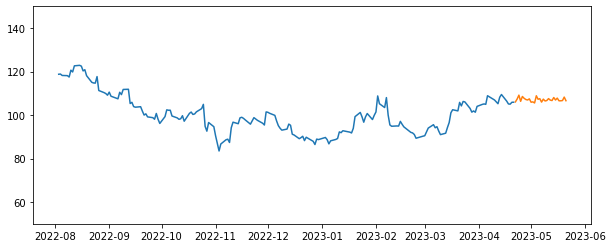

In [121]:
# Make test predictions
ticker ="GOOG"
train_generator = stocks_data[ticker]['train_generator']
valid_generator = stocks_data[ticker]['valid_generator']
test_generator = stocks_data[ticker]['test_generator']
x_scaler = stocks_data[ticker]['x_scaler']
y_scaler = stocks_data[ticker]['y_scaler']

filepath='models_vanilla/{}.weights.best.hdf5'.format(ticker)
OUTPUT_SIZE = 30
    
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(window_length, 26)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(OUTPUT_SIZE))
    
model.load_weights(filepath)

model.compile(loss='mean_squared_error', optimizer='adam')
test_predict = model.predict_generator(test_generator)
Y_ = y_scaler.inverse_transform(test_predict)
predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
predicted_df = predicted_df.rename(columns={0: ticker})
    
original_test = stocks_data[ticker]['y_test'].iloc[window_length:]
predicted_df.index = original_test.index
    
predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)

#predicted_ticker

df_past = predicted_ticker['Adj Close'].reset_index()
#df_past = original_test['Adj Close'].reset_index()

df_past.rename(columns={'index': 'Date', 'Adj Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=30)
df_future['Forecast'] = Y_[-1].flatten()
df_future['Actual'] = np.nan
df_future

list_df = [df_past,df_future]
results = pd.concat(list_df).set_index('Date')
#([predicted_df[ticker], original_test], axis=1)
# plot the results
#results.plot()

plt.figure(figsize=(10, 4))

#plt.plot(predicted_ticker[ticker], linewidth=1, alpha=0.8)
#plt.plot(stocks_data[ticker]['y'], linewidth=1, alpha=0.8)
#plt.title('Plot for {}, val loss: {}'.format(ticker.upper(), val_loss))
plt.plot(results)
plt.ylim(50, 150)
plt.savefig('figures/future_{}.png'.format(ticker))

In [90]:
#stocks_data[ticker]['y_test'].iloc[90:]

In [91]:
model.summary()

Model: "sequential_112"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_224 (LSTM)             (None, 90, 50)            15400     
                                                                 
 dropout_224 (Dropout)       (None, 90, 50)            0         
                                                                 
 lstm_225 (LSTM)             (None, 50)                20200     
                                                                 
 dropout_225 (Dropout)       (None, 50)                0         
                                                                 
 dense_112 (Dense)           (None, 30)                1530      
                                                                 
Total params: 37,130
Trainable params: 37,130
Non-trainable params: 0
_________________________________________________________________


In [92]:
def get_ticker_volatility(portfolio):
    tick_std = np.std(data[portfolio])
    print(tick_std)

In [114]:
get_ticker_volatility(good['Portfolio'][8])

GOOGL    4.666967
MRK      3.033828
dtype: float64


In [117]:
print(good['Portfolio_Volatility'][8],good['Portfolio_Returns'][8])

15.886372299780238 5.96


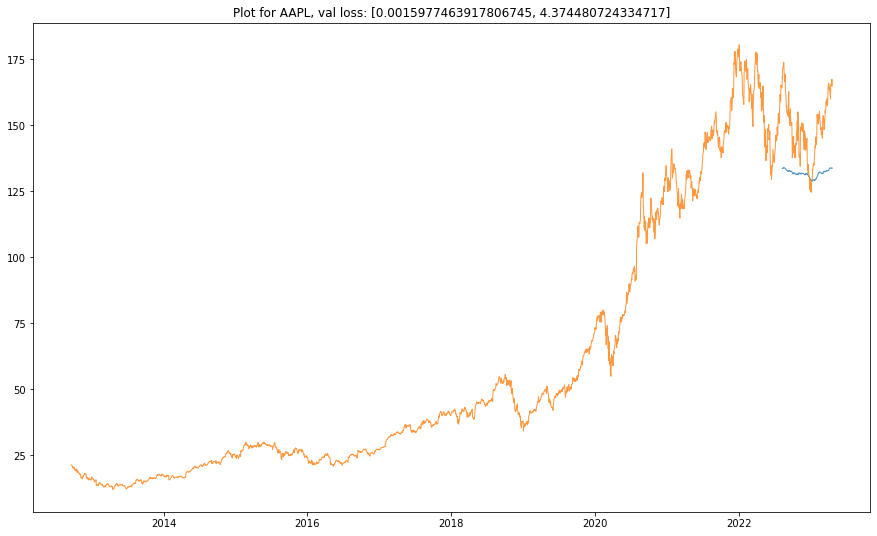

--------------------------
Final Train Loss: 0.0016
Final Test Loss: 0.0141
--------------------------
Final Train MAPE: 349.014404296875
Final Test MAPE: 11.5733003616333




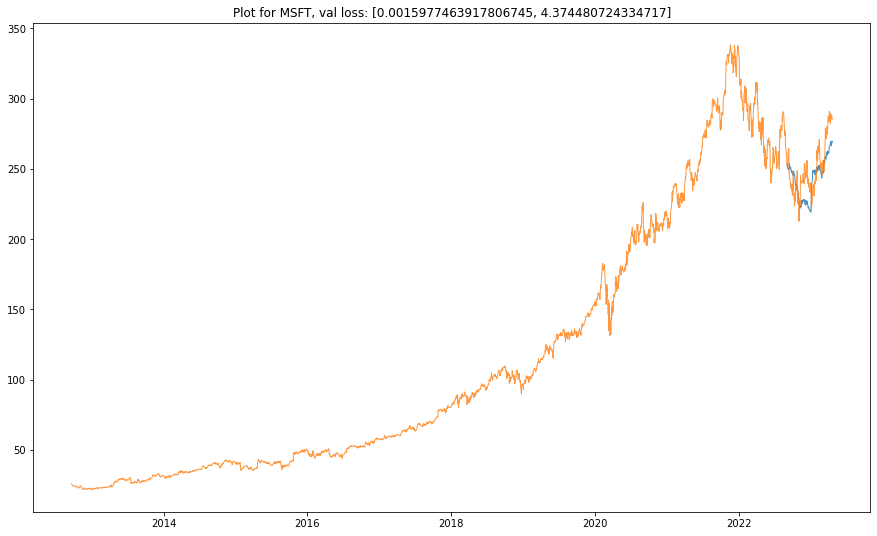

--------------------------
Final Train Loss: 0.0006
Final Test Loss: 0.0022
--------------------------
Final Train MAPE: 335.7856140136719
Final Test MAPE: 7.330599784851074




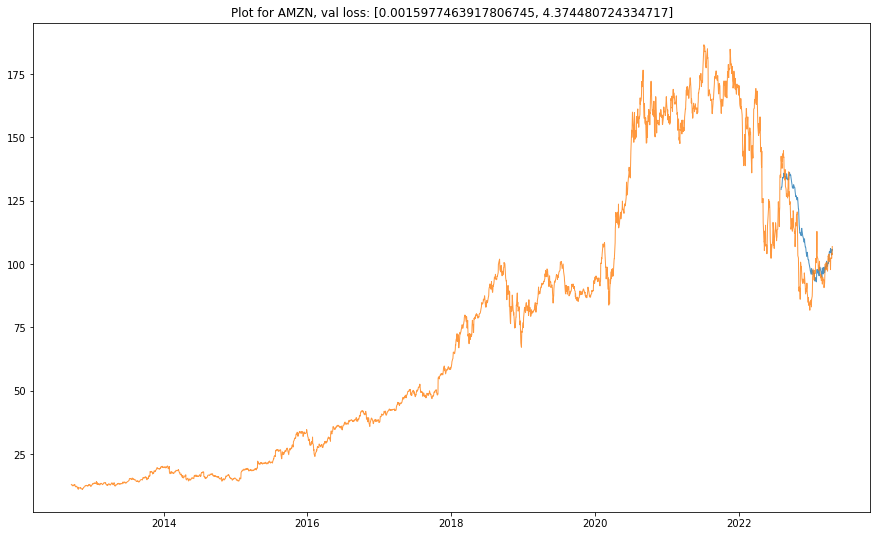

--------------------------
Final Train Loss: 0.0012
Final Test Loss: 0.0057
--------------------------
Final Train MAPE: 251.7967071533203
Final Test MAPE: 17.943700790405273




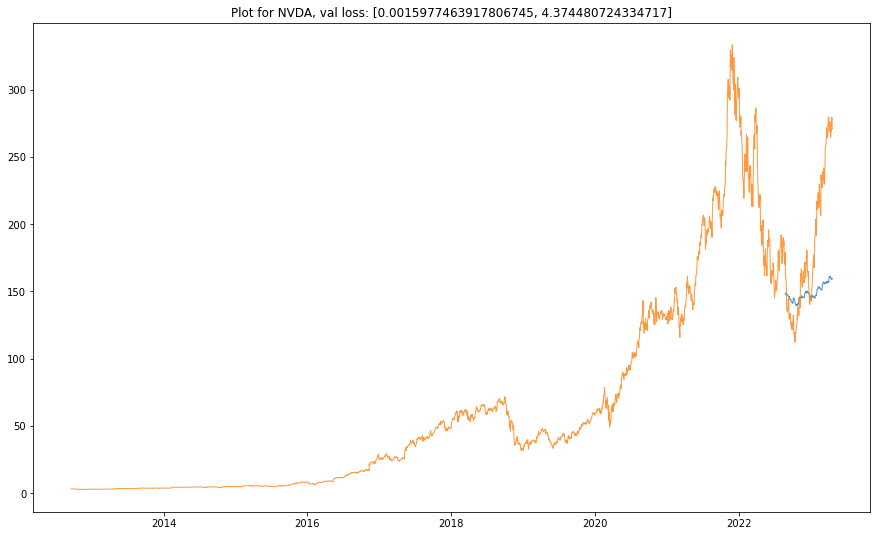

--------------------------
Final Train Loss: 0.0009
Final Test Loss: 0.026
--------------------------
Final Train MAPE: 1447.0443115234375
Final Test MAPE: 21.5093994140625




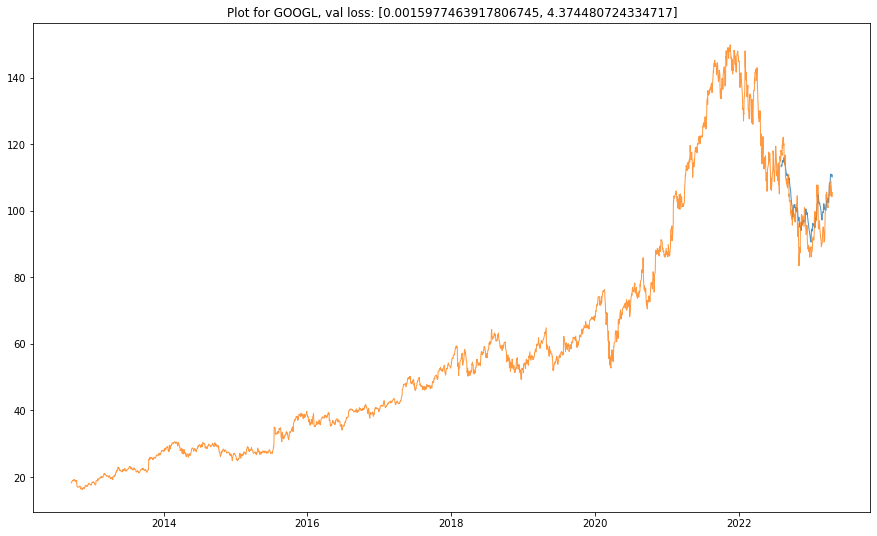

--------------------------
Final Train Loss: 0.0016
Final Test Loss: 0.0015
--------------------------
Final Train MAPE: 161.8148956298828
Final Test MAPE: 8.819600105285645




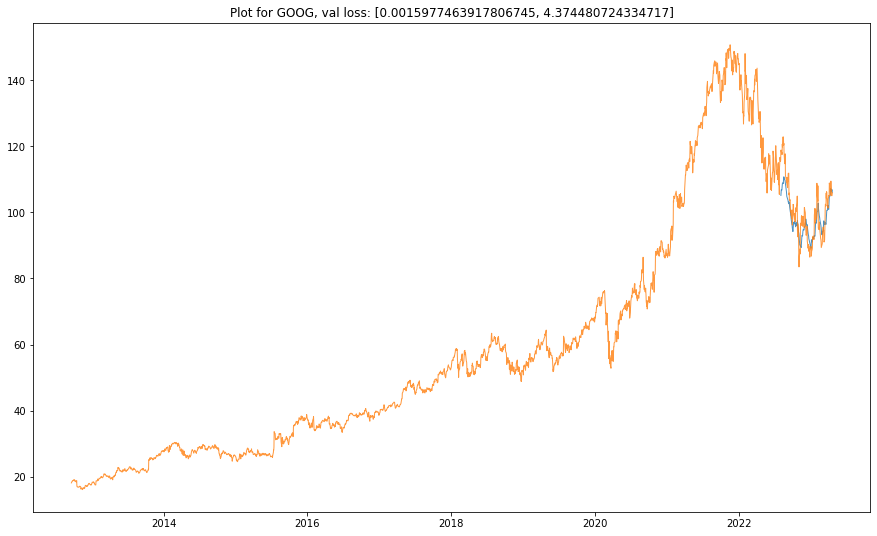

--------------------------
Final Train Loss: 0.0028
Final Test Loss: 0.0013
--------------------------
Final Train MAPE: 155.7783966064453
Final Test MAPE: 8.07229995727539




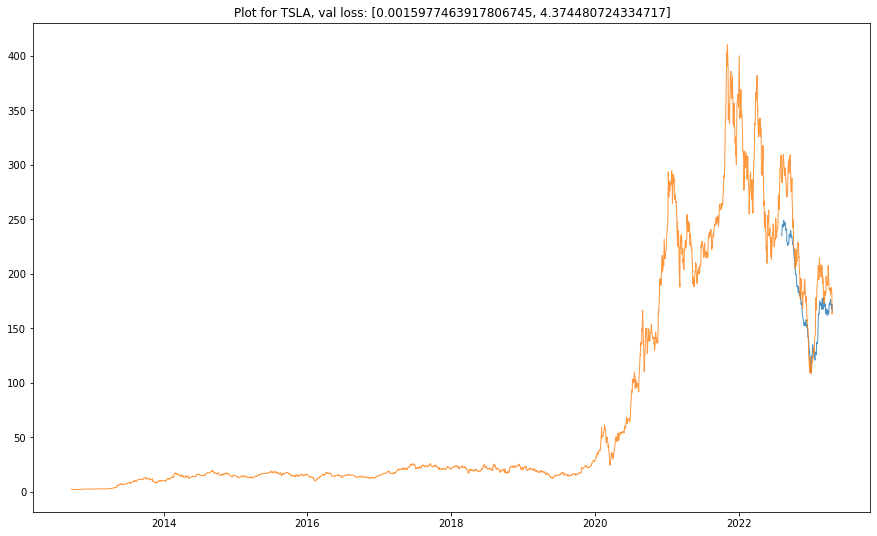

--------------------------
Final Train Loss: 0.0019
Final Test Loss: 0.0076
--------------------------
Final Train MAPE: 1122.0189208984375
Final Test MAPE: 27.28700065612793




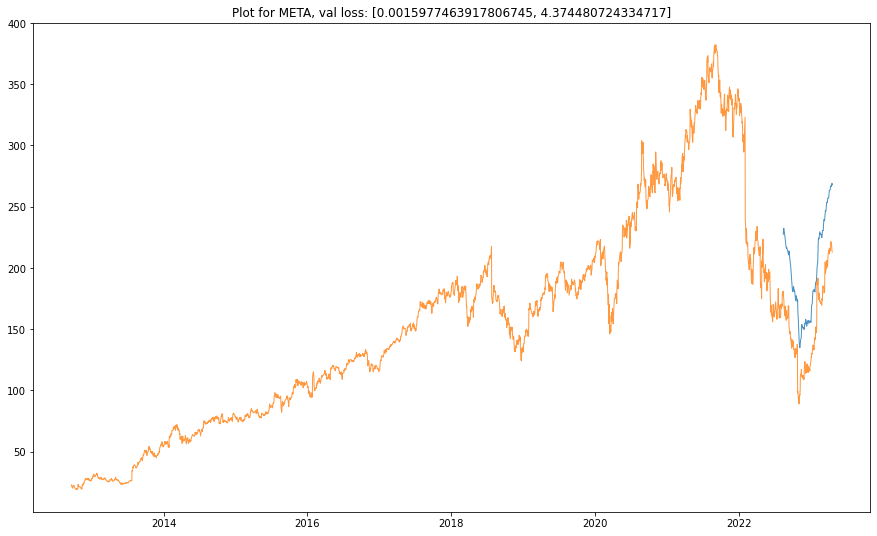

--------------------------
Final Train Loss: 0.0072
Final Test Loss: 0.0145
--------------------------
Final Train MAPE: 117.58399963378906
Final Test MAPE: 43.12590026855469




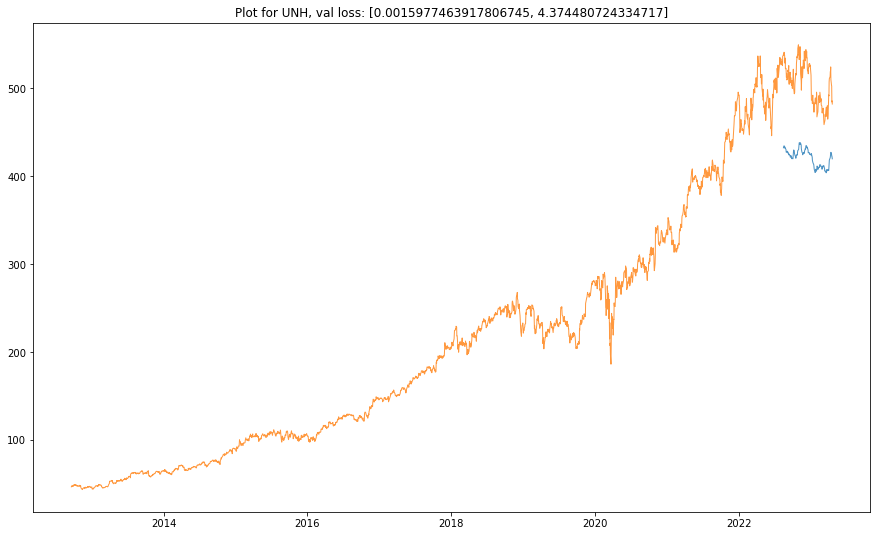

--------------------------
Final Train Loss: 0.0008
Final Test Loss: 0.0291
--------------------------
Final Train MAPE: 246.13580322265625
Final Test MAPE: 16.515499114990234




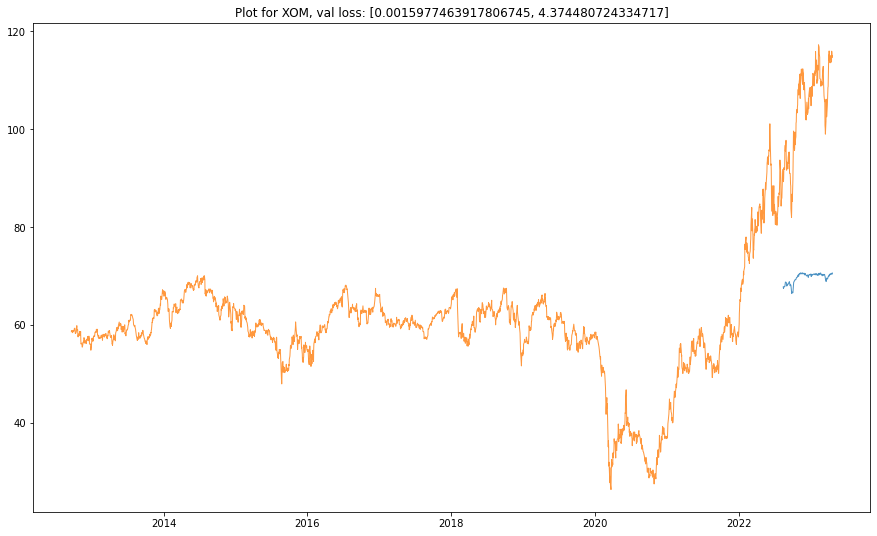

--------------------------
Final Train Loss: 0.002
Final Test Loss: 0.1544
--------------------------
Final Train MAPE: 25.110000610351562
Final Test MAPE: 32.990699768066406




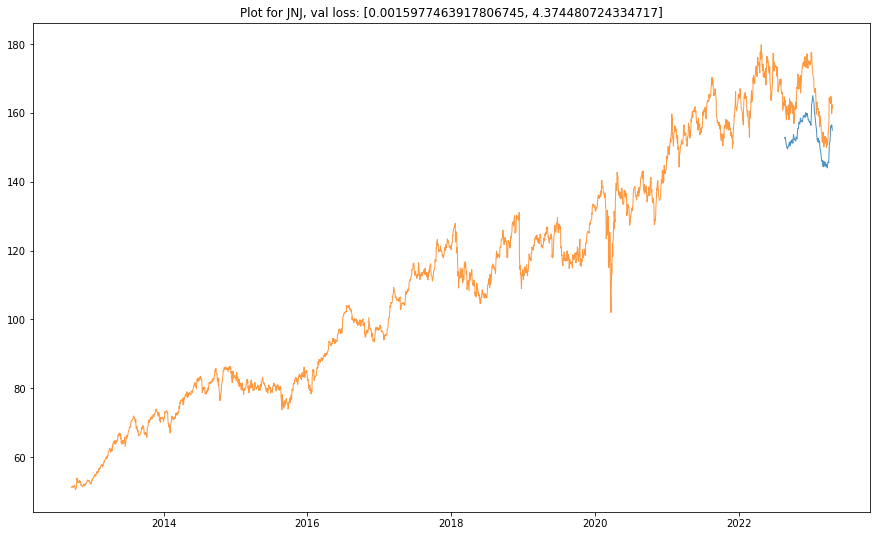

--------------------------
Final Train Loss: 0.0022
Final Test Loss: 0.0065
--------------------------
Final Train MAPE: 59.497501373291016
Final Test MAPE: 6.810400009155273




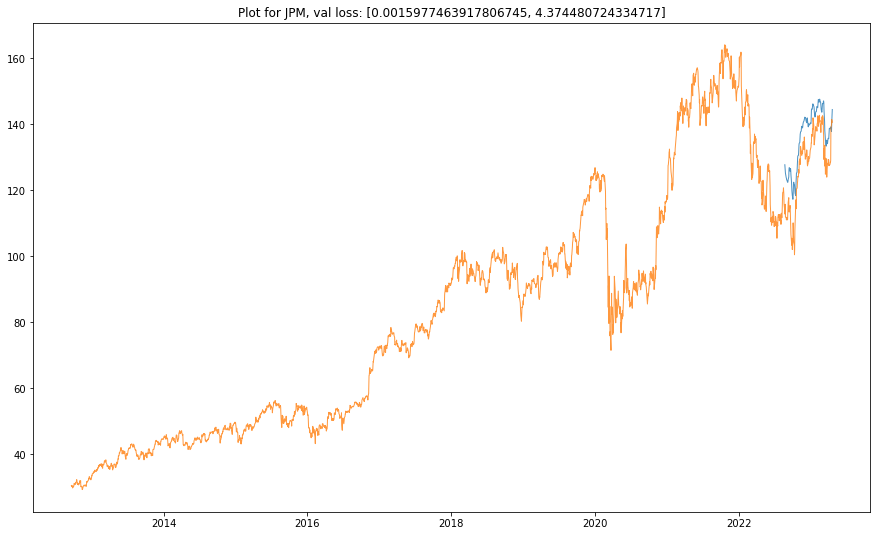

--------------------------
Final Train Loss: 0.01
Final Test Loss: 0.0068
--------------------------
Final Train MAPE: 115.75460052490234
Final Test MAPE: 11.138899803161621




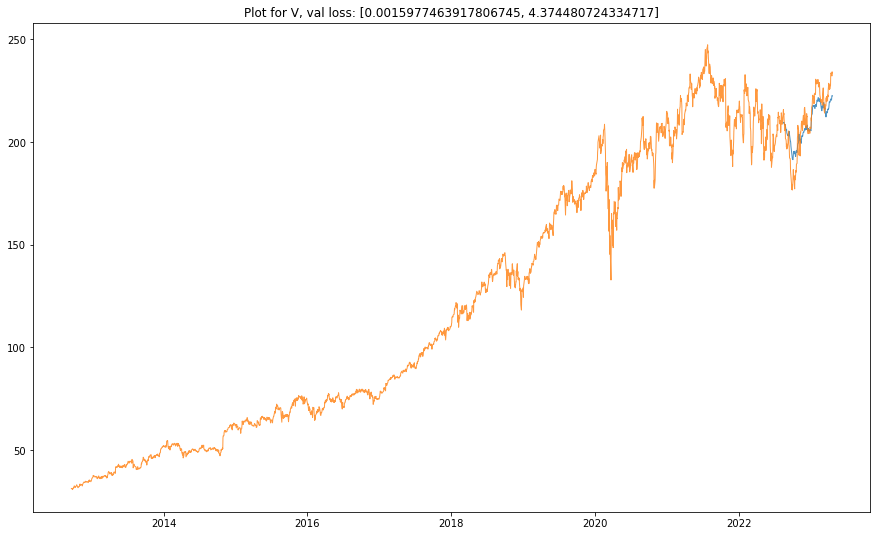

--------------------------
Final Train Loss: 0.0012
Final Test Loss: 0.0013
--------------------------
Final Train MAPE: 159.02220153808594
Final Test MAPE: 6.977499961853027




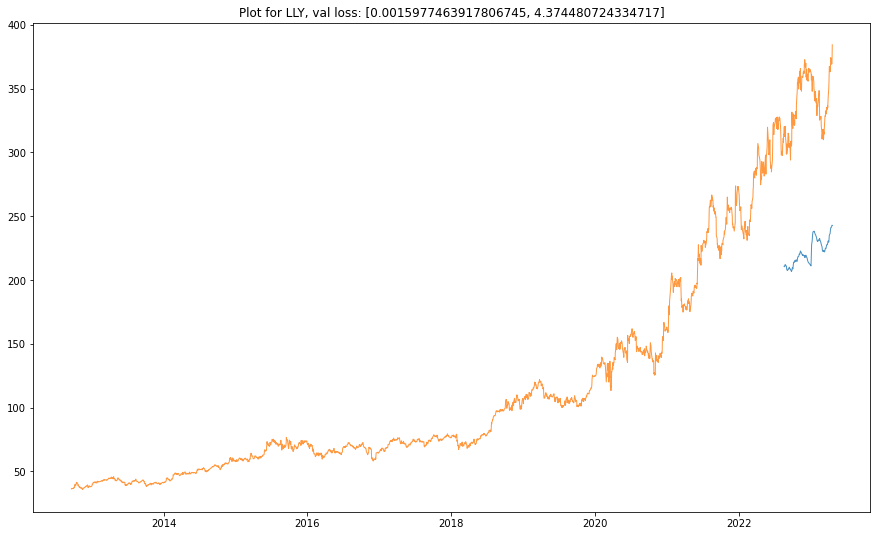

--------------------------
Final Train Loss: 0.0006
Final Test Loss: 0.1149
--------------------------
Final Train MAPE: 213.1436004638672
Final Test MAPE: 34.48509979248047




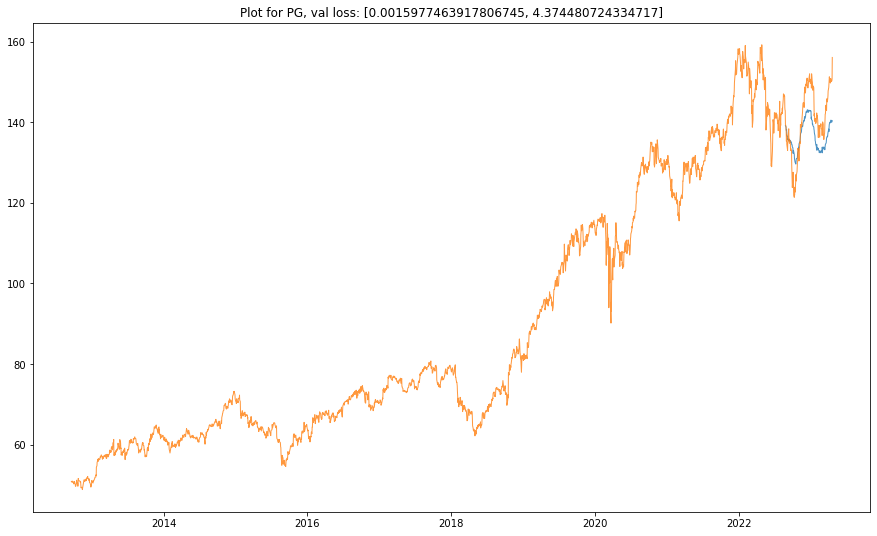

--------------------------
Final Train Loss: 0.0039
Final Test Loss: 0.0033
--------------------------
Final Train MAPE: 82.43720245361328
Final Test MAPE: 5.612100124359131




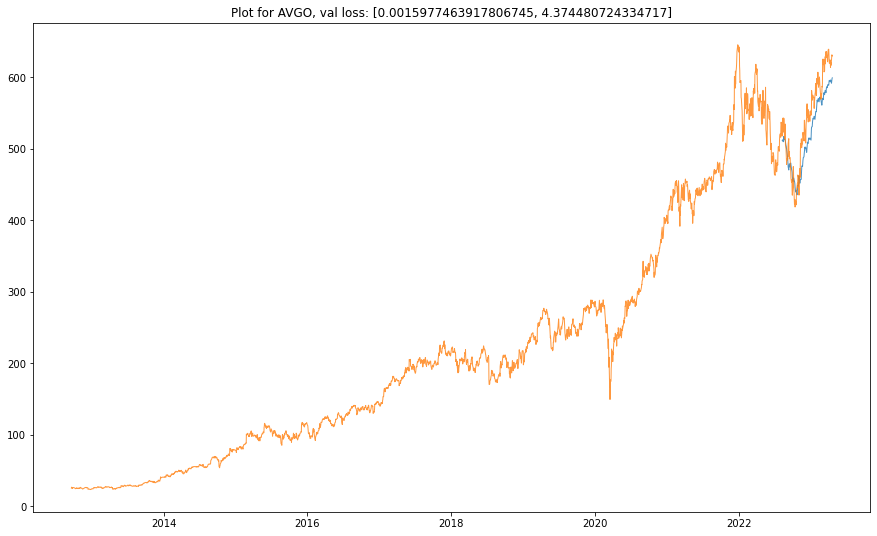

--------------------------
Final Train Loss: 0.0012
Final Test Loss: 0.0033
--------------------------
Final Train MAPE: 450.7388000488281
Final Test MAPE: 12.60219955444336




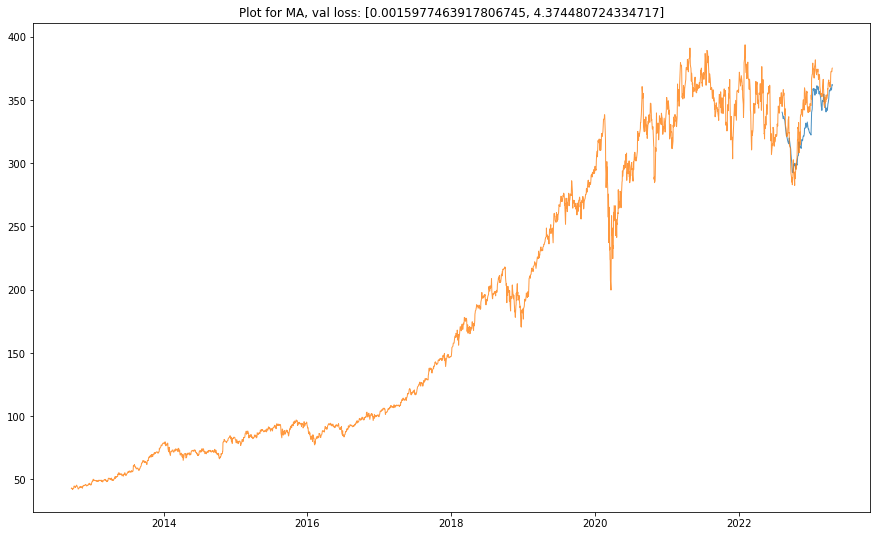

--------------------------
Final Train Loss: 0.0025
Final Test Loss: 0.0019
--------------------------
Final Train MAPE: 201.643798828125
Final Test MAPE: 8.286100387573242




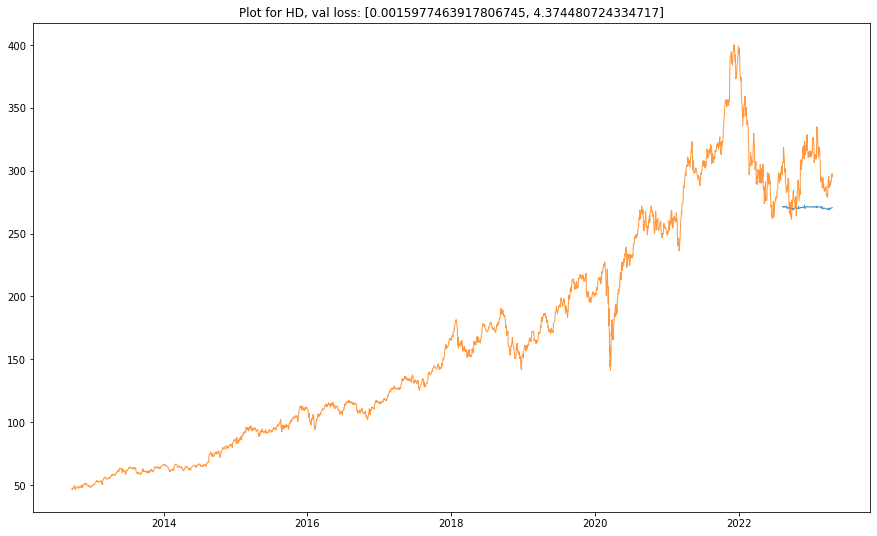

--------------------------
Final Train Loss: 0.0084
Final Test Loss: 0.0069
--------------------------
Final Train MAPE: 144.85740661621094
Final Test MAPE: 8.887700080871582




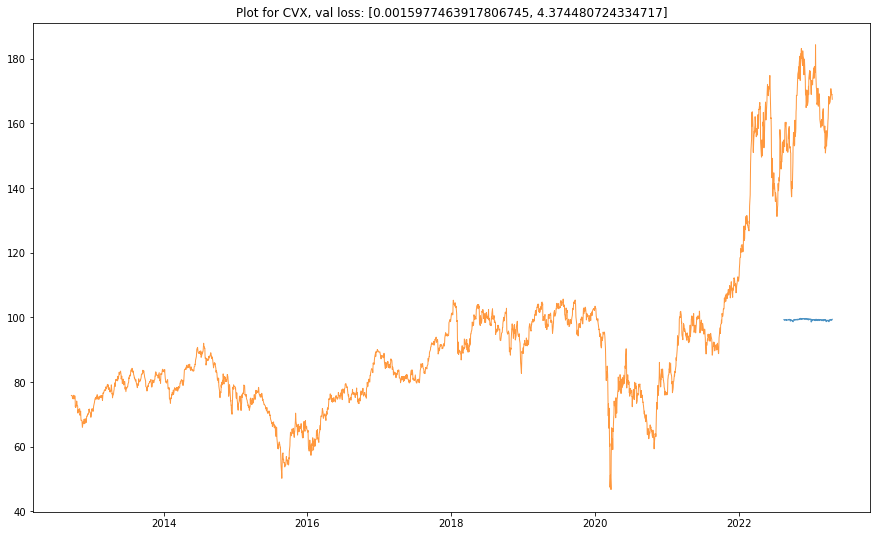

--------------------------
Final Train Loss: 0.0049
Final Test Loss: 0.2333
--------------------------
Final Train MAPE: 22.531999588012695
Final Test MAPE: 39.62699890136719




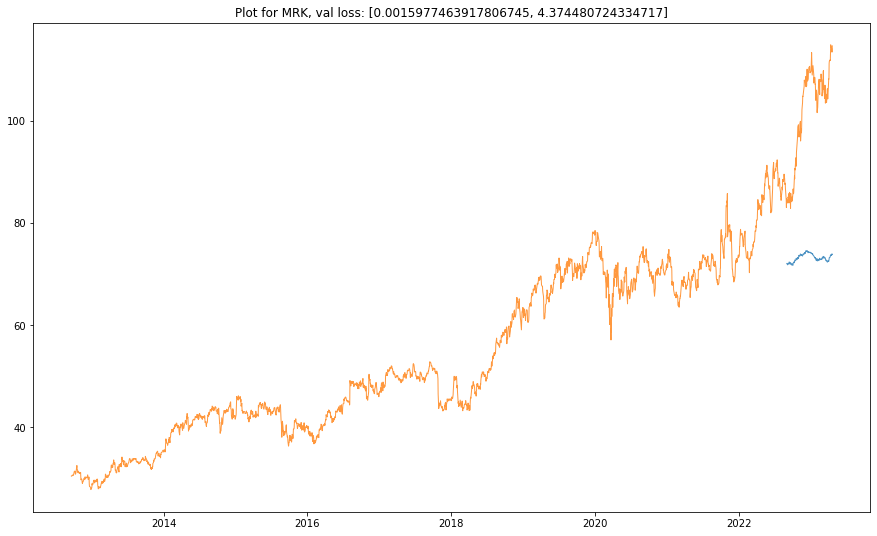

--------------------------
Final Train Loss: 0.0094
Final Test Loss: 0.1289
--------------------------
Final Train MAPE: 53.869300842285156
Final Test MAPE: 27.618600845336914




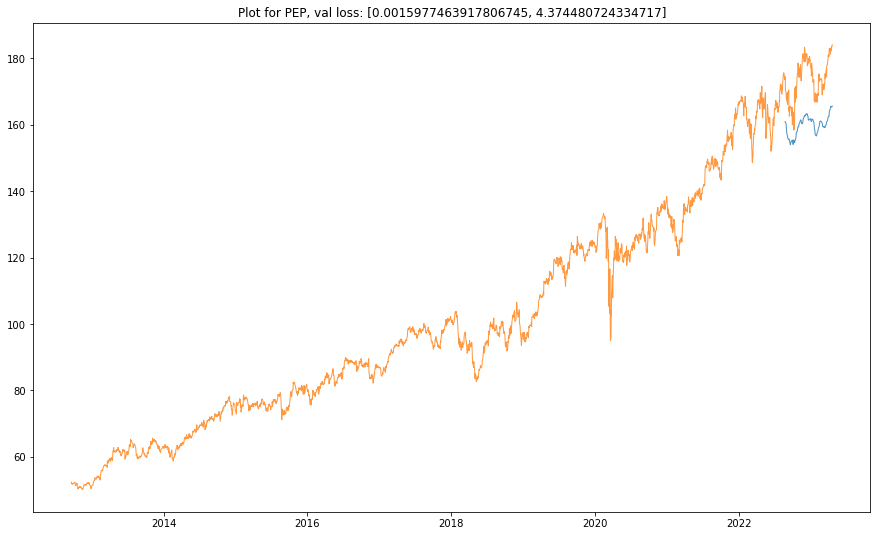

--------------------------
Final Train Loss: 0.0002
Final Test Loss: 0.0131
--------------------------
Final Train MAPE: 84.90339660644531
Final Test MAPE: 7.927499771118164




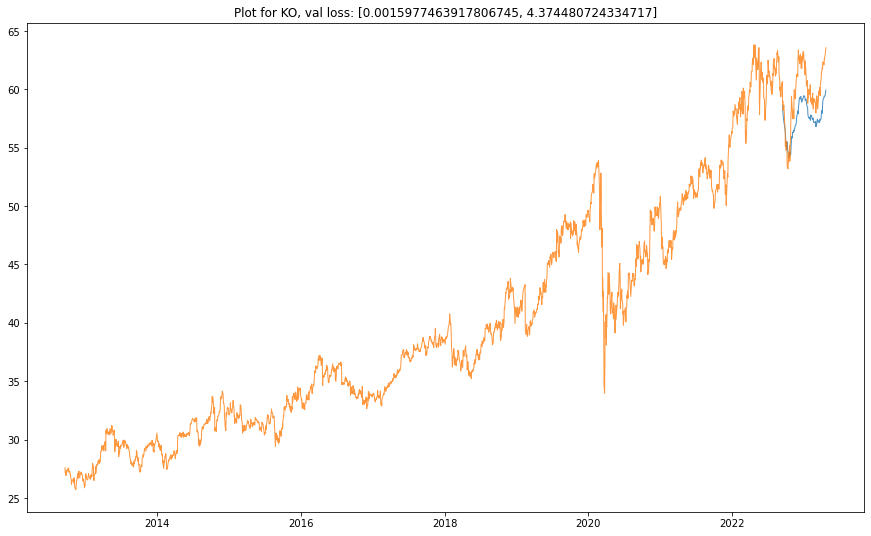

--------------------------
Final Train Loss: 0.0033
Final Test Loss: 0.0036
--------------------------
Final Train MAPE: 59.919898986816406
Final Test MAPE: 4.969799995422363




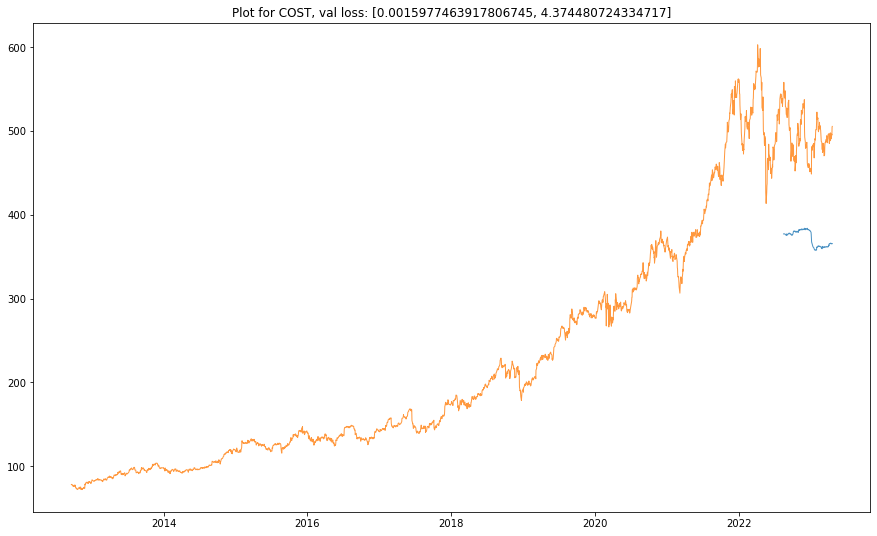

--------------------------
Final Train Loss: 0.001
Final Test Loss: 0.0557
--------------------------
Final Train MAPE: 150.2593994140625
Final Test MAPE: 24.397300720214844




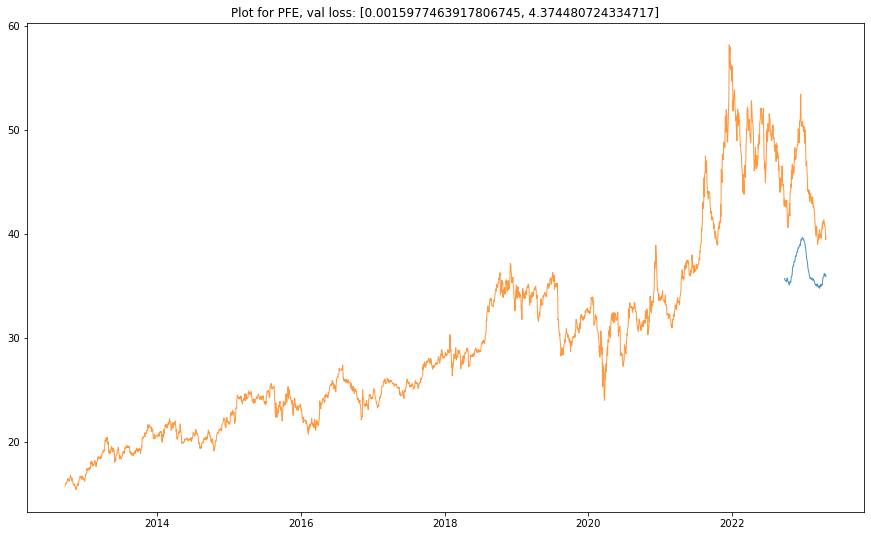

--------------------------
Final Train Loss: 0.0021
Final Test Loss: 0.0371
--------------------------
Final Train MAPE: 43.35660171508789
Final Test MAPE: 16.933500289916992




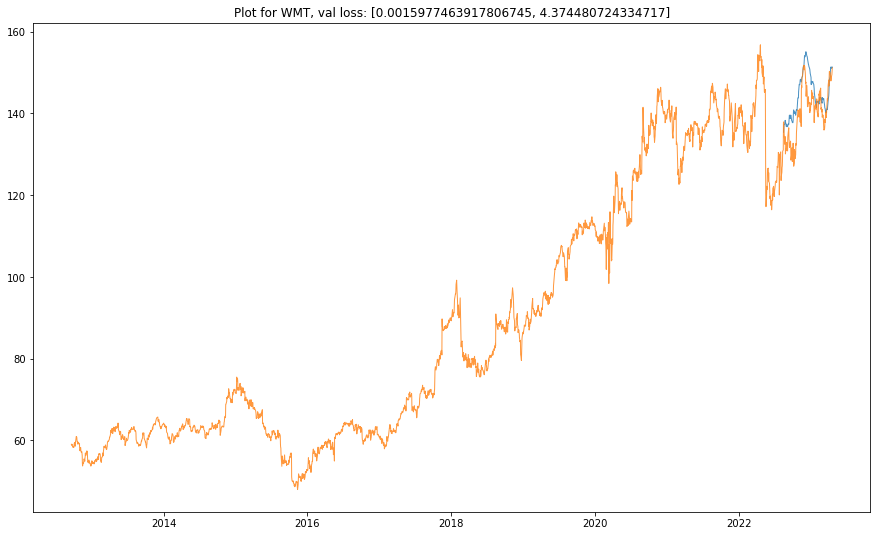

--------------------------
Final Train Loss: 0.0007
Final Test Loss: 0.0024
--------------------------
Final Train MAPE: 95.01309967041016
Final Test MAPE: 5.332200050354004




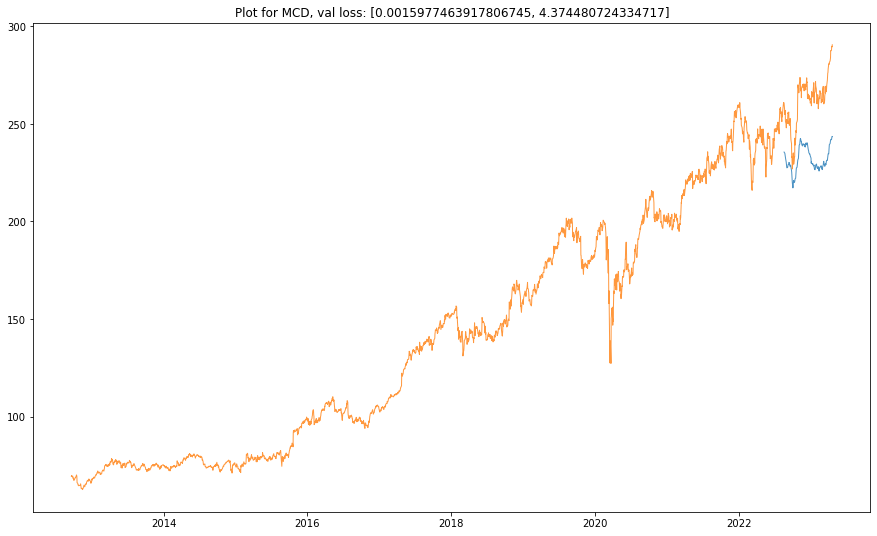

--------------------------
Final Train Loss: 0.0008
Final Test Loss: 0.0193
--------------------------
Final Train MAPE: 111.50299835205078
Final Test MAPE: 11.51099967956543




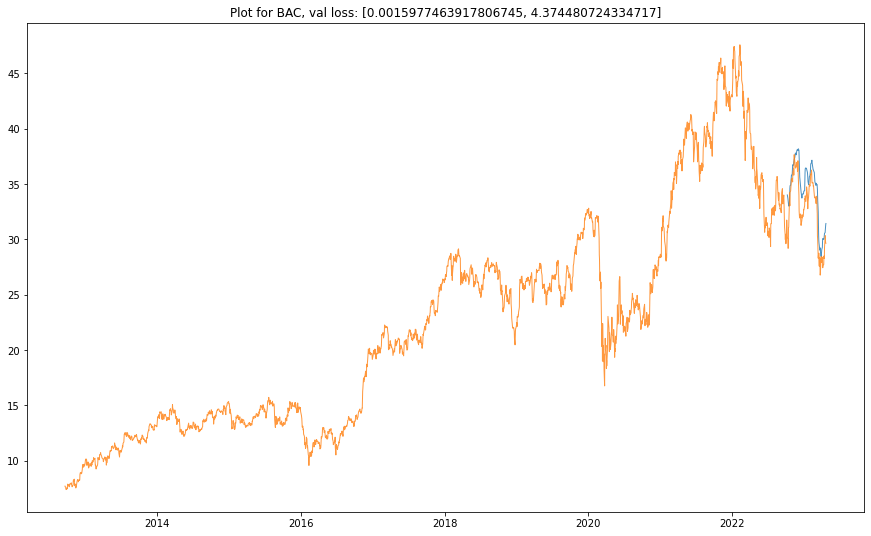

--------------------------
Final Train Loss: 0.0036
Final Test Loss: 0.0022
--------------------------
Final Train MAPE: 98.55860137939453
Final Test MAPE: 11.086400032043457




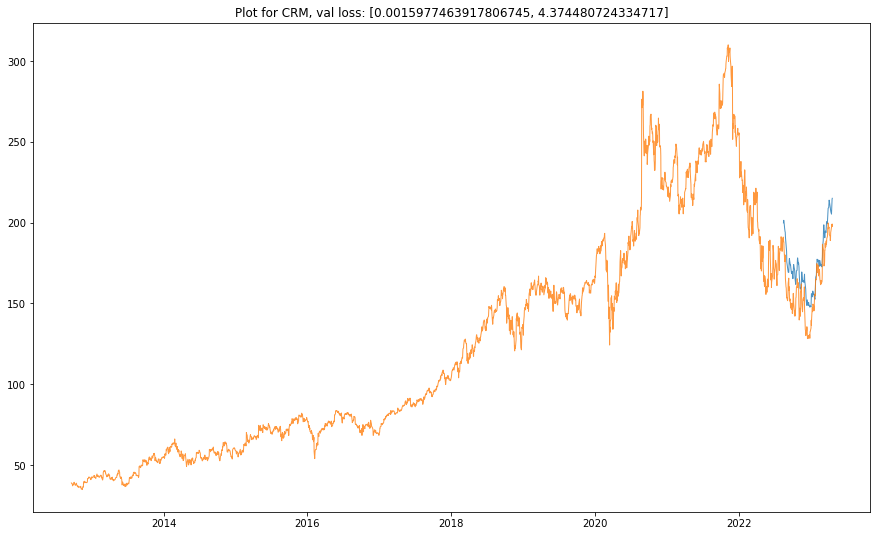

--------------------------
Final Train Loss: 0.0009
Final Test Loss: 0.0036
--------------------------
Final Train MAPE: 113.3302001953125
Final Test MAPE: 15.767000198364258




In [100]:
total_test_mape =0
total_train_mape =0

for i, (ticker, ds) in enumerate(stocks_data.items()):
    train_generator = ds['train_generator']
    valid_generator = ds['valid_generator']
    test_generator = ds['test_generator']
    
    x_scaler = ds['x_scaler']
    y_scaler = ds['y_scaler']
    
    filepath='models_vanilla/{}.weights.best.hdf5'.format(ticker)
    OUTPUT_SIZE = 30

    
    model = Sequential()
    model.add(LSTM(units=50,return_sequences=True, input_shape=(window_length, 26)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(OUTPUT_SIZE))
    
    model.load_weights(filepath)

    model.compile(loss='mean_squared_error', optimizer='adam')
    #model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mean_absolute_percentage_error'])
    
    #val_loss, mape_val = model.evaluate_generator(valid_generator)
    #print('Val loss for {}: {}'.format(ticker, val_loss))
    
    # Make test predictions
    test_predict = model.predict_generator(test_generator)
    predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
    predicted_df = predicted_df.rename(columns={0: ticker})
    original_test = stocks_data[ticker]['y_test'].iloc[window_length:]
    predicted_df.index = original_test.index
    predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)
    test_acc = np.mean(mean_absolute_percentage_error(original_test,predicted_ticker[ticker]))
    
    train_predict = model.predict_generator(train_generator)
    train_predicted_df = pd.DataFrame(y_scaler.inverse_transform(train_predict))
    train_predicted_df = train_predicted_df.rename(columns={0: ticker})
    original_train = stocks_data[ticker]['y_train'].iloc[window_length:]
    train_predicted_df.index = original_train.index
    
    train_predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)
    train_acc = np.mean(mean_absolute_percentage_error(original_train,train_predicted_ticker[ticker]))
    
    total_train_mape+=train_acc
    total_test_mape+=test_acc
    
    %matplotlib inline
    plt.figure(figsize=(15, 9))

    plt.plot(predicted_ticker[ticker], linewidth=1, alpha=0.8)
    plt.plot(stocks_data[ticker]['y'], linewidth=1, alpha=0.8)
    
    plt.title('Plot for {}, val loss: {}'.format(ticker.upper(), val_loss))
    plt.savefig('plots/{}'.format(ticker))
    plt.show()
    
    train_loss = model.evaluate_generator(train_generator);
    test_loss  = model.evaluate_generator(test_generator);
    print('--------------------------')
    print(f'Final Train Loss: {np.round(train_loss,4)}')
    print(f'Final Test Loss: {np.round(test_loss,4)}') 
    print('--------------------------')
    print(f'Final Train MAPE: {np.round(train_acc,4)}')
    print(f'Final Test MAPE: {np.round(test_acc,4)}') 
    print('\n')

In [ ]:
model.summary()
#model.evaluate_generator(valid_generator)

In [ ]:
#model.evaluate_generator(test_generator)

In [ ]:
#test_predict =model.predict_generator(test_generator)
#y_scaler.inverse_transform(test_predict)
#test_predict.shape


In [ ]:
print(f'Final MAPE score: Train={np.round(total_train_mape/len(stocks_data))}')
print(f'Final MAPE score: Test={np.round(total_test_mape/len(stocks_data))}')

# Conclusions
* We have built a basic framework:
    * fits LSTM models on all the stocks that are included in study.
    * build Returns for each individual stocks.
    * predicts combinations of stocks to build profitable portfolios based on Shapre Ratio and Voltality.
    
## Future Improvements
* Check other models such as GARCH, Random Forests etc to get prediction for stocks movement.
* Hyperparameter tuning of Models.
* Explore the models by including few variables versus all the variables that are included in this study.
* Include the sentienet analysis which includes web-carpping for news.
* Also implement the information from SEC reports submitted by companies.
